# Predicción de Desórdenes Genéticos en Niños: Un Enfoque de Machine Learning

## Sobre el Conjunto de datos

El conjunto de datos genómicos y genéticos se basa en la información médica de niños y pacientes adultos que tienen trastornos genéticos. El tipo de conjunto de datos es multi-etiqueta y multi-clase. El conjunto de datos contiene un total de 45 atributos (Figura 1)

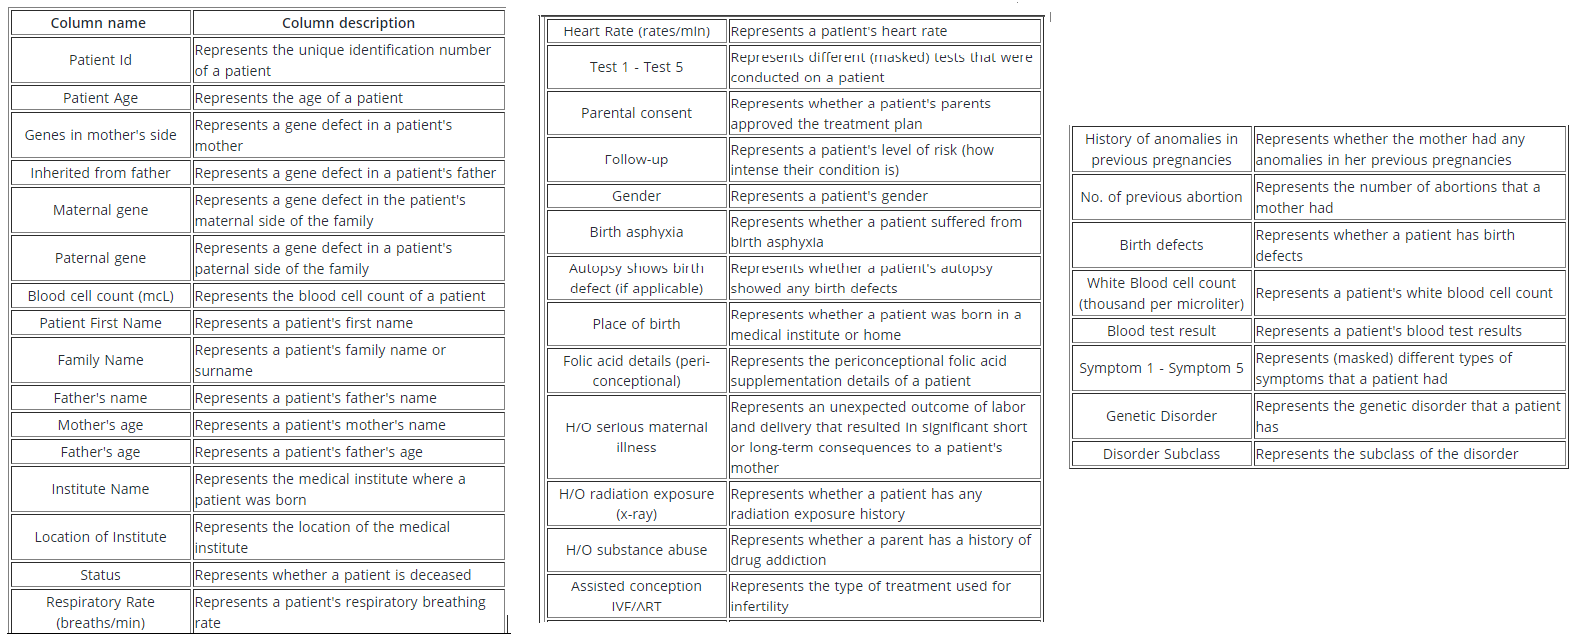

## Analisis Exploratorio de Datos Genéticos (GEDA)
El Análisis Exploratorio de Datos Genéticos (GEDA) se aplica al conjunto de datos genómicos para encontrar patrones ocultos e información importante que pueda ser útil para predecir trastornos genéticos. 

### 1. Cargar las librerías e importar los datos

In [294]:
# Importación de librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, label_binarize
from fancyimpute import KNN
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [295]:
# Carga de datos
train_df = pd.read_csv('Genomes And Genetics/train.csv')
test_df = pd.read_csv('Genomes And Genetics/test.csv')

# Mostrar primeras filas de cada dataframe
print("Primeras filas del conjunto de entrenamiento:")
train_df.head()
print("\nPrimeras filas del conjunto de prueba:")
test_df.head()

Primeras filas del conjunto de entrenamiento:
  Patient Id  Patient Age Genes in mother's side Inherited from father  \
0  PID0x6418          2.0                    Yes                    No   
1  PID0x25d5          4.0                    Yes                   Yes   
2  PID0x4a82          6.0                    Yes                    No   
3  PID0x4ac8         12.0                    Yes                    No   
4  PID0x1bf7         11.0                    Yes                    No   

  Maternal gene Paternal gene  Blood cell count (mcL) Patient First Name  \
0           Yes            No                4.760603            Richard   
1            No            No                4.910669               Mike   
2            No            No                4.893297           Kimberly   
3           Yes            No                4.705280            Jeffery   
4           NaN           Yes                4.720703            Johanna   

  Family Name Father's name  ...  Birth defects  \
0

### 2. Descripción de los datos

In [277]:
# Información general del dataframe de entrenamiento
print("\nInformación general del conjunto de entrenamiento:")
print(train_df.info())


Información general del conjunto de entrenamiento:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22083 entries, 0 to 22082
Data columns (total 45 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Patient Id                                        22083 non-null  object 
 1   Patient Age                                       20656 non-null  float64
 2   Genes in mother's side                            22083 non-null  object 
 3   Inherited from father                             21777 non-null  object 
 4   Maternal gene                                     19273 non-null  object 
 5   Paternal gene                                     22083 non-null  object 
 6   Blood cell count (mcL)                            22083 non-null  float64
 7   Patient First Name                                22083 non-null  object 
 8   Family Name                                 

In [278]:
# Descripción estadística del dataframe de entrenamiento
print("Descripción estadística del conjunto de entrenamiento:")
print(train_df.describe())

Descripción estadística del conjunto de entrenamiento:
        Patient Age  Blood cell count (mcL)  Mother's age  Father's age  \
count  20656.000000            22083.000000  16047.000000  16097.000000   
mean       6.974148                4.898871     34.526454     41.972852   
std        4.319475                0.199663      9.852598     13.035501   
min        0.000000                4.092727     18.000000     20.000000   
25%        3.000000                4.763109     26.000000     31.000000   
50%        7.000000                4.899399     35.000000     42.000000   
75%       11.000000                5.033830     43.000000     53.000000   
max       14.000000                5.609829     51.000000     64.000000   

        Test 1   Test 2   Test 3   Test 4   Test 5  No. of previous abortion  \
count  19956.0  19931.0  19936.0  19943.0  19913.0              19921.000000   
mean       0.0      0.0      0.0      1.0      0.0                  2.003062   
std        0.0      0.0      

In [279]:
# Conteo de valores nulos en el dataframe de entrenamiento
print("\nConteo de valores nulos en el conjunto de entrenamiento:")
print(train_df.isnull().sum())


Conteo de valores nulos en el conjunto de entrenamiento:
Patient Id                                             0
Patient Age                                         1427
Genes in mother's side                                 0
Inherited from father                                306
Maternal gene                                       2810
Paternal gene                                          0
Blood cell count (mcL)                                 0
Patient First Name                                     0
Family Name                                         9691
Father's name                                          0
Mother's age                                        6036
Father's age                                        5986
Institute Name                                      5106
Location of Institute                                  0
Status                                                 0
Respiratory Rate (breaths/min)                      2149
Heart Rate (rates/min         

In [280]:
# Valores únicos para "Genetic Disorders" y "Disorder Subclass"
print("\nTipos de Desórdenes Genéticos:")
print(train_df["Genetic Disorder"].unique())
print("\nEnfermedades (Subclases de Desórdenes):")
print(train_df["Disorder Subclass"].unique())


Tipos de Desórdenes Genéticos:
['Mitochondrial genetic inheritance disorders' nan
 'Multifactorial genetic inheritance disorders'
 'Single-gene inheritance diseases']

Enfermedades (Subclases de Desórdenes):
["Leber's hereditary optic neuropathy" 'Cystic fibrosis' 'Diabetes'
 'Leigh syndrome' 'Cancer' 'Tay-Sachs' 'Hemochromatosis'
 'Mitochondrial myopathy' nan "Alzheimer's"]


### 3. Visualización de los datos

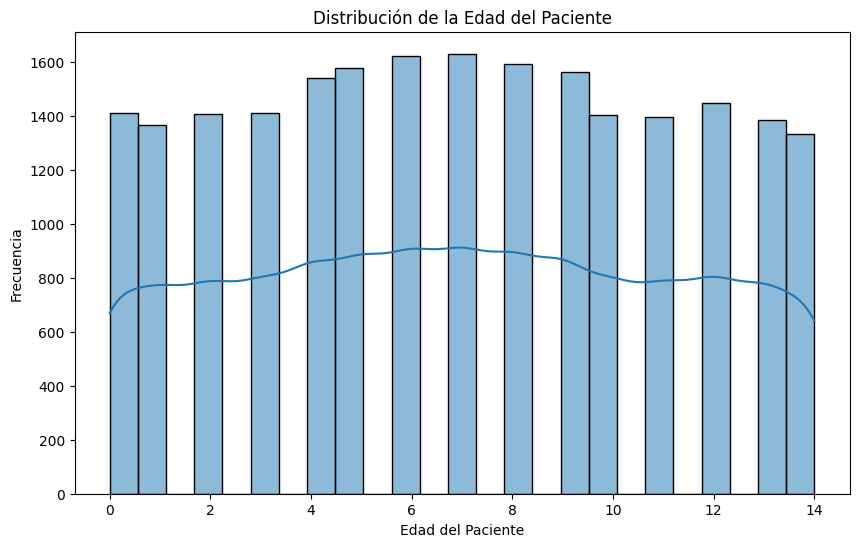

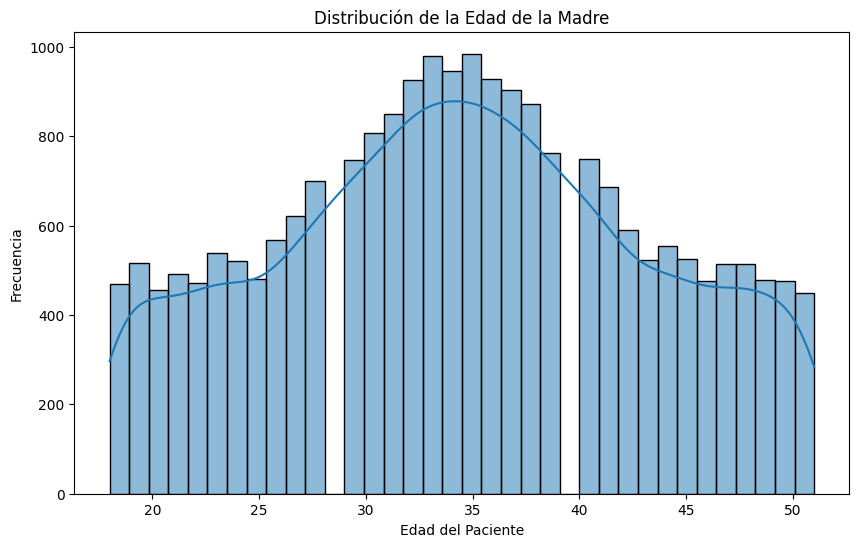

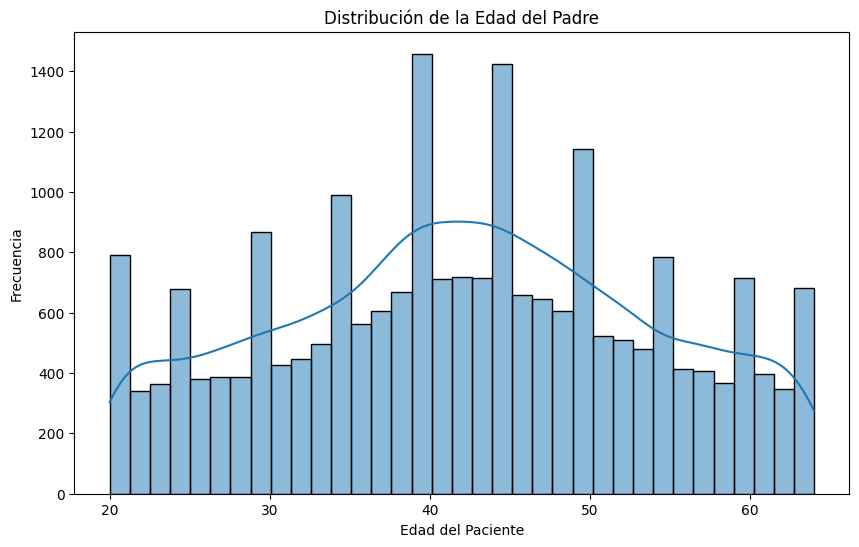

In [302]:
# Histograma de la edad del paciente
plt.figure(figsize=(10,6))
sns.histplot(train_df['Patient Age'].dropna(), kde=True)
plt.title('Distribución de la Edad del Paciente')
plt.xlabel('Edad del Paciente')
plt.ylabel('Frecuencia')
plt.show()

# Histograma de la edad de la madre
plt.figure(figsize=(10,6))
sns.histplot(train_df['Mother\'s age'].dropna(), kde=True)
plt.title('Distribución de la Edad de la Madre')
plt.xlabel('Edad del Paciente')
plt.ylabel('Frecuencia')
plt.show()

# Histograma de la edad del padre
plt.figure(figsize=(10,6))
sns.histplot(train_df['Father\'s age'].dropna(), kde=True)
plt.title('Distribución de la Edad del Padre')
plt.xlabel('Edad del Paciente')
plt.ylabel('Frecuencia')
plt.show()

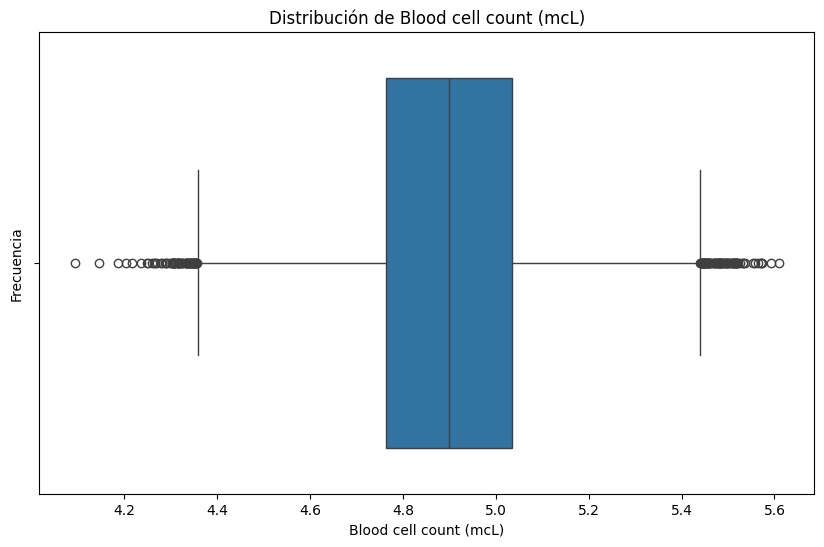

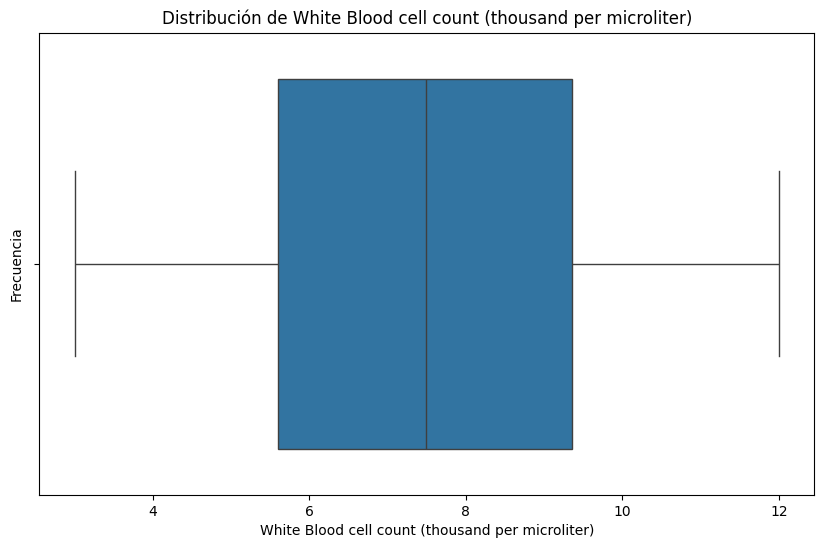

In [301]:
# Boxplots para las columnas de conteos celulares
for columna in ['Blood cell count (mcL)', 'White Blood cell count (thousand per microliter)']:
    plt.figure(figsize=(10,6))
    sns.boxplot(x=train_df[columna])
    plt.title(f'Distribución de {columna}')
    plt.ylabel('Frecuencia')
    plt.show()

#### 3.1 Distribución de las clases

In [176]:
#Etiquetas en español para los gráficos
genetic_disorder_dict = {
    'Mitochondrial genetic inheritance disorders': 'Desórdenes genéticos mitocondriales',
    'Multifactorial genetic inheritance disorders': 'Desórdenes genéticos multifactoriales',
    'Single-gene inheritance diseases': 'Desórdenes monogénicos'
}
disorder_subclass_dict = {
    "Leber's hereditary optic neuropathy": 'Neuropatía óptica hereditaria de Leber',
    'Cystic fibrosis': 'Fibrosis quística',
    'Diabetes': 'Diabetes',
    'Leigh syndrome': 'Síndrome de Leigh',
    'Cancer': 'Cáncer',
    'Tay-Sachs': 'Tay-Sachs',
    'Hemochromatosis': 'Hemocromatosis',
    'Mitochondrial myopathy': 'Miopatía mitocondrial',
    "Alzheimer's": 'Alzheimer'
}

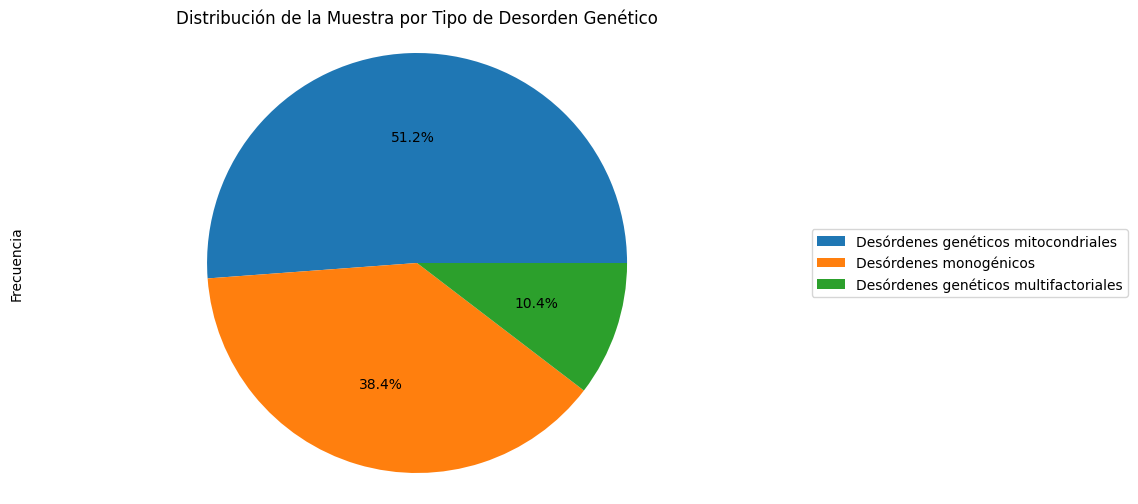

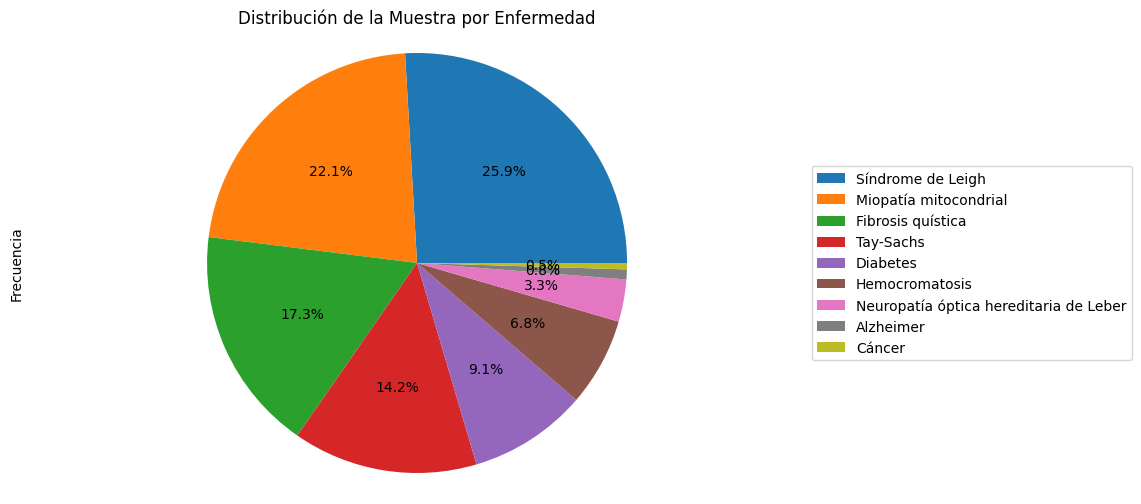

In [177]:
# Función para crear gráficos de pastel
def plot_pie_chart(data, column, labels, title):
    plt.figure(figsize=(10, 6))
    counts = data[column].value_counts()
    labels = [labels.get(idx, 'No label') for idx in counts.index]
    counts.plot(kind='pie', labels=None, autopct='%1.1f%%')
    plt.title(title)
    plt.legend(labels, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.axis('equal')
    plt.ylabel('Frecuencia')  
    plt.show()

# Gráfico de pastel para Desorden Genético
plot_pie_chart(train_df, 'Genetic Disorder', genetic_disorder_dict, 'Distribución de la Muestra por Tipo de Desorden Genético')

# Gráfico de pastel para Subclase del Desorden
plot_pie_chart(train_df, 'Disorder Subclass', disorder_subclass_dict, 'Distribución de la Muestra por Enfermedad')

#### 3.2 Conteo de celulas por tipo de desorden y enfermedad 

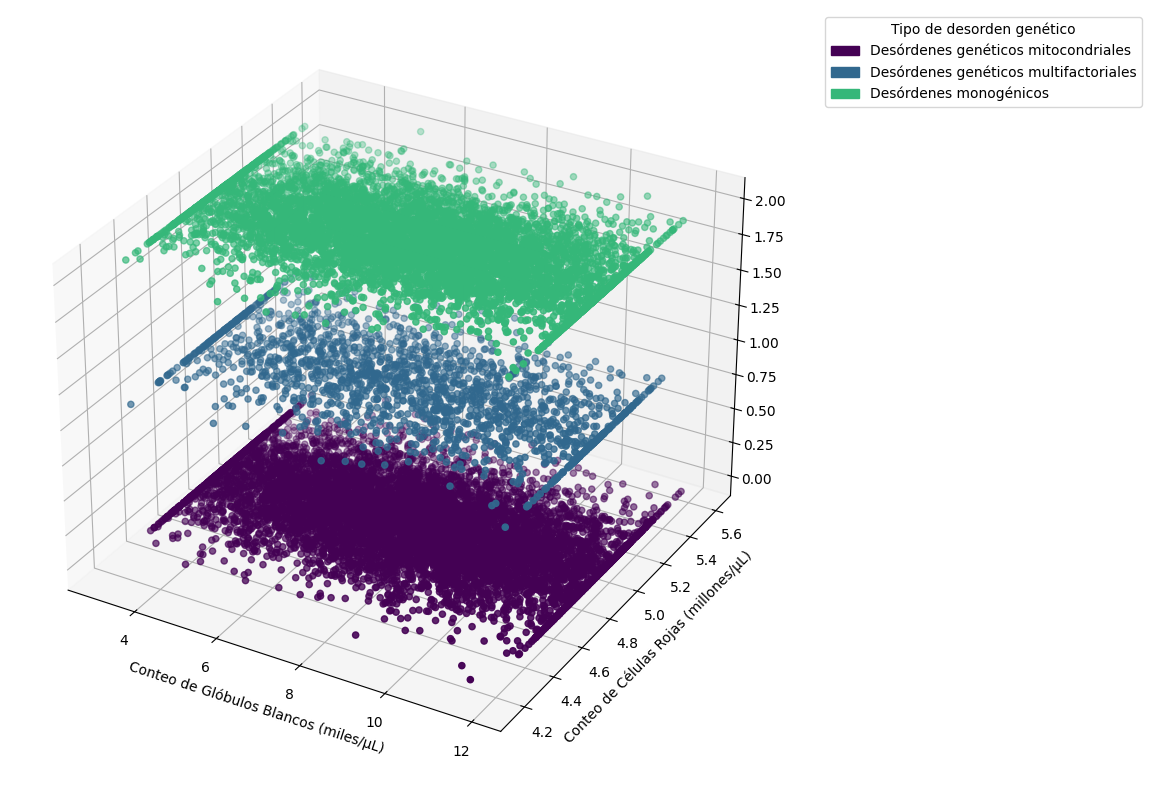

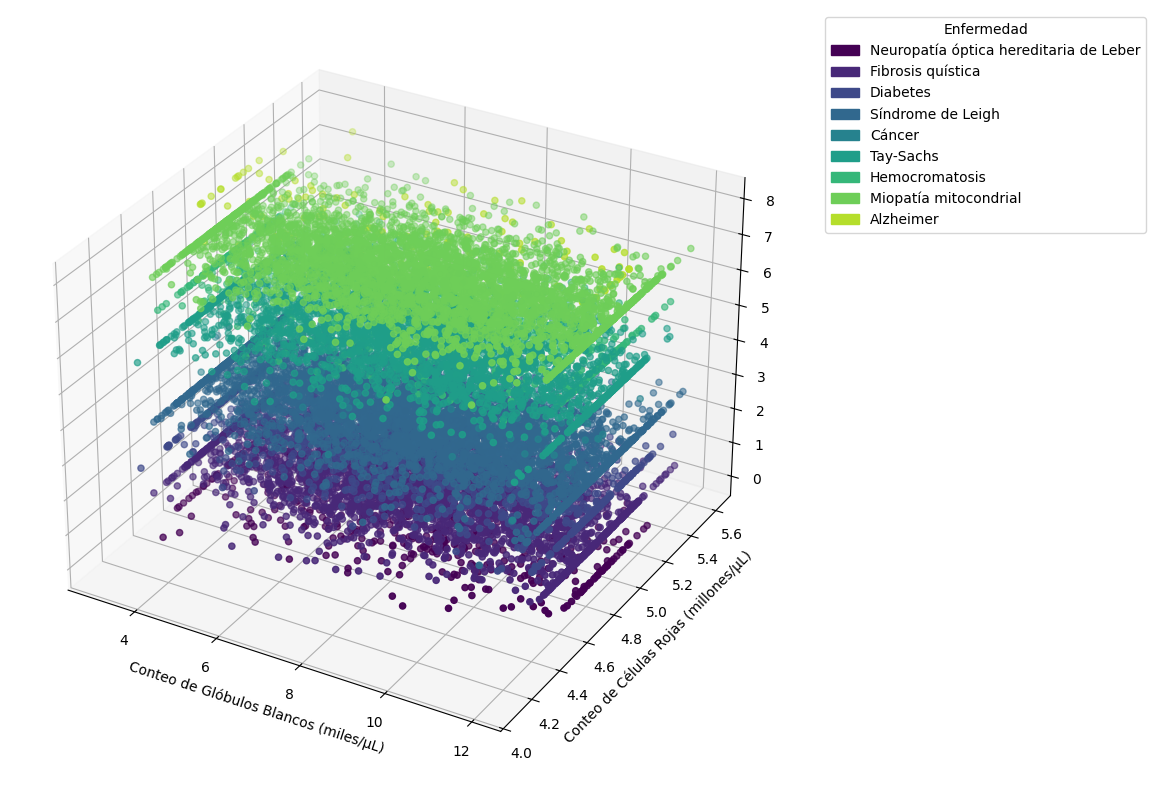

In [179]:
# Función para crear gráficos 3D de dispersión
def plot_3d_scatter(data, x_col, y_col, z_col, color_col, color_map, labels_dict, title):
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Crear una lista de colores basada en las etiquetas únicas en tus datos
    unique_labels = data[color_col].dropna().unique()
    colors = [plt.get_cmap(color_map)(i/len(unique_labels)) for i in range(len(unique_labels))]
    
    # Crear elementos de leyenda basados en las etiquetas únicas y los colores
    legend_elements = [mpatches.Patch(color=colors[int(i)], label=labels_dict.get(i, 'No label')) for i in unique_labels]
    
    # Utilizar los colores al crear el gráfico de dispersión
    for i in unique_labels:
        subset = data[data[color_col] == i]
        ax.scatter(subset[x_col], subset[y_col], subset[z_col], color=colors[int(i)], label=labels_dict.get(int(i), 'No label'))
    
    ax.legend(handles=legend_elements, title=title, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    ax.set_xlabel('Conteo de Glóbulos Blancos (miles/µL)')
    ax.set_ylabel('Conteo de Células Rojas (millones/µL)')
    
    plt.show()

# Mapeo de 'Genetic Disorder' a enteros
train_df['Genetic Disorder Mapped'] = train_df['Genetic Disorder'].map({'Mitochondrial genetic inheritance disorders': 0, 'Multifactorial genetic inheritance disorders': 1, 'Single-gene inheritance diseases': 2})

# Mapeo de 'Disorder Subclass' a enteros
train_df['Disorder Subclass Mapped'] = train_df['Disorder Subclass'].map({'Leber\'s hereditary optic neuropathy': 0, 'Cystic fibrosis': 1, 'Diabetes': 2, 'Leigh syndrome': 3, 'Cancer': 4, 'Tay-Sachs': 5, 'Hemochromatosis': 6, 'Mitochondrial myopathy': 7, 'Alzheimer\'s': 8})    

# Gráfico 3D para Desorden Genético utilizando los valores mapeados
plot_3d_scatter(train_df, 
                'White Blood cell count (thousand per microliter)', 
                'Blood cell count (mcL)', 
                'Genetic Disorder Mapped', 
                'Genetic Disorder Mapped', 
                'viridis', 
                {0: 'Desórdenes genéticos mitocondriales', 
                 1: 'Desórdenes genéticos multifactoriales', 
                 2: 'Desórdenes monogénicos'}, 
                "Tipo de desorden genético")

# Gráfico 3D para Subclase del Desorden utilizando los valores mapeados
plot_3d_scatter(train_df, 
                'White Blood cell count (thousand per microliter)', 
                'Blood cell count (mcL)', 
                'Disorder Subclass Mapped', 
                'Disorder Subclass Mapped', 
                'viridis', 
                {0: 'Neuropatía óptica hereditaria de Leber', 
                 1: 'Fibrosis quística', 
                 2: 'Diabetes', 
                 3: 'Síndrome de Leigh', 
                 4: 'Cáncer', 
                 5: 'Tay-Sachs', 
                 6: 'Hemocromatosis', 
                 7: 'Miopatía mitocondrial', 
                 8: 'Alzheimer'}, 
                "Enfermedad")

#### 3.3 Distribución genómica por desorden y tipo de herencia

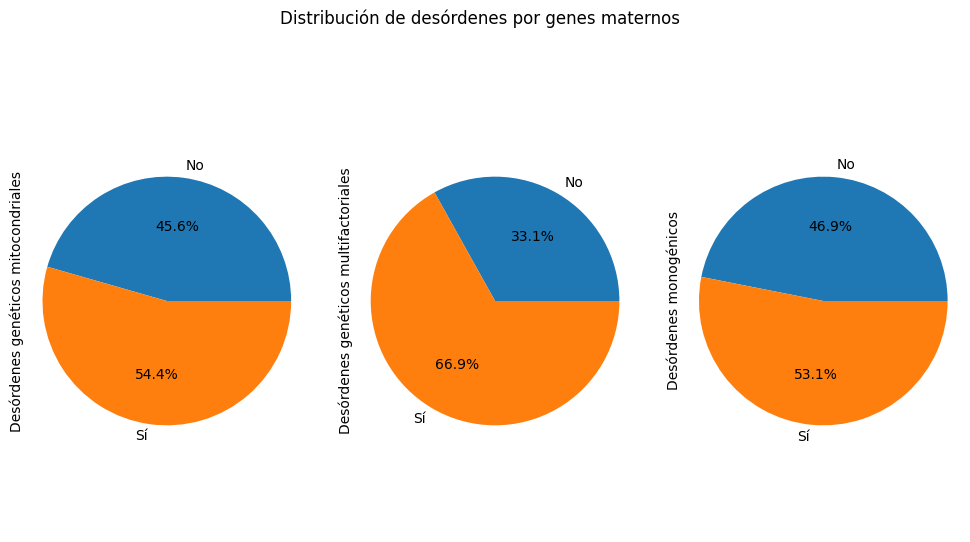

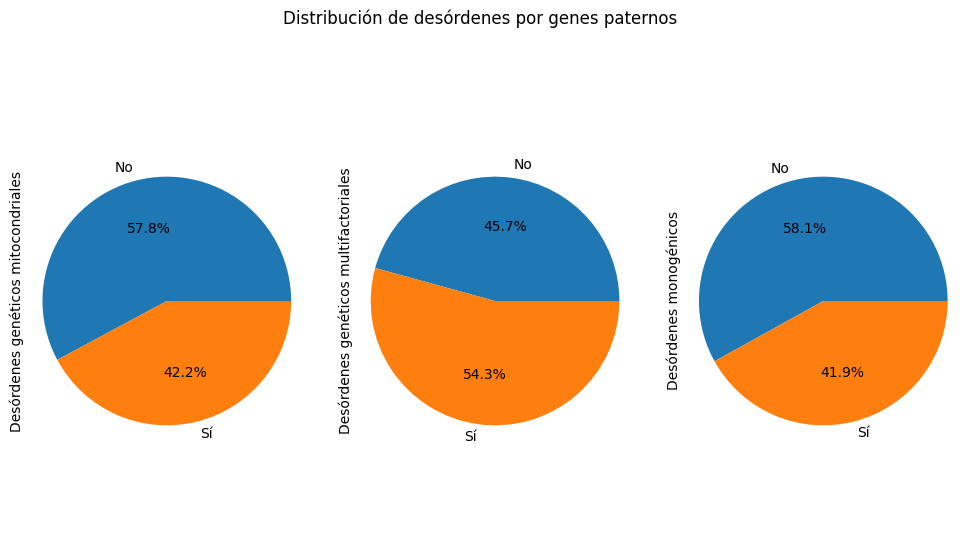

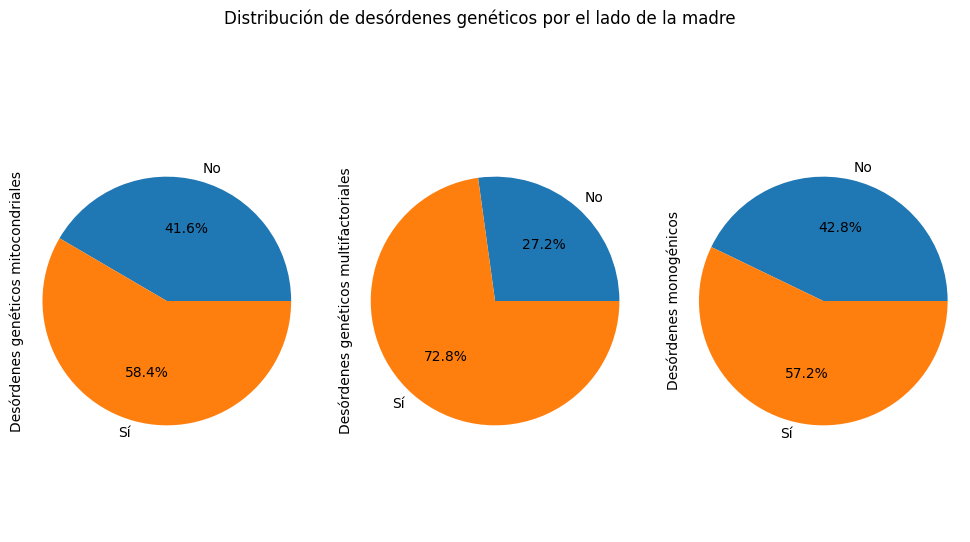

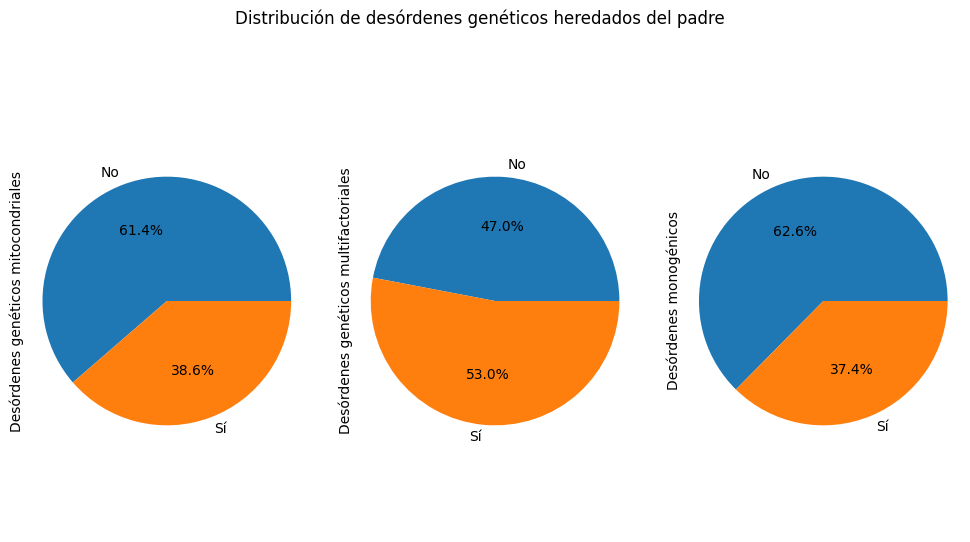

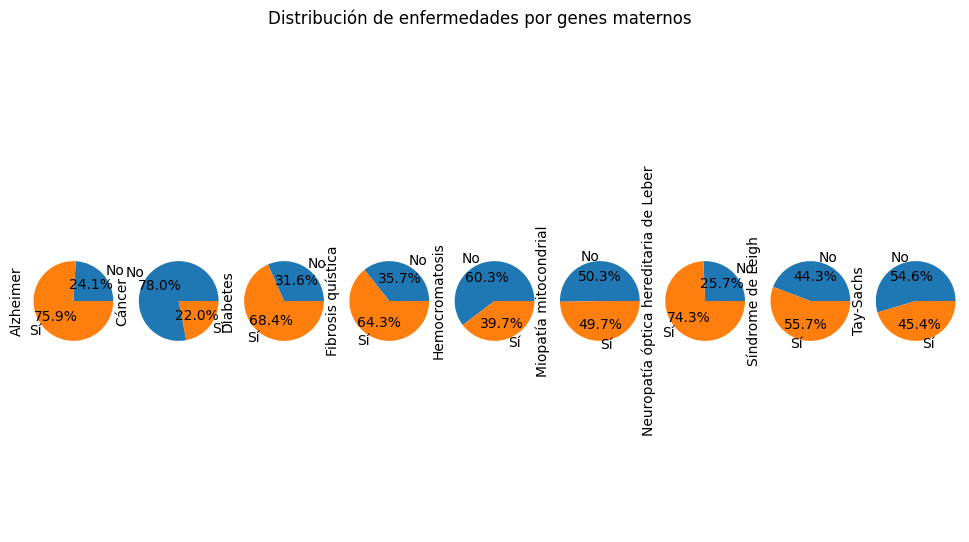

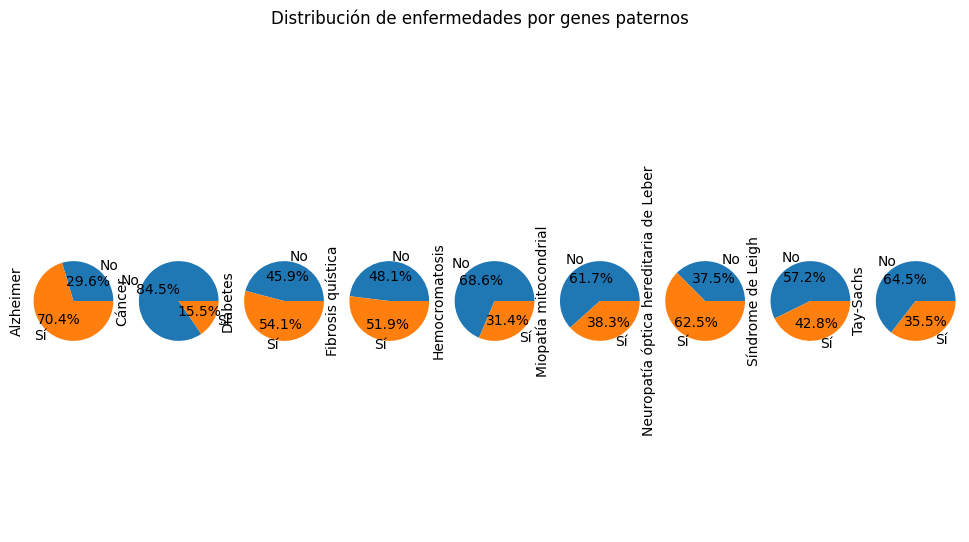

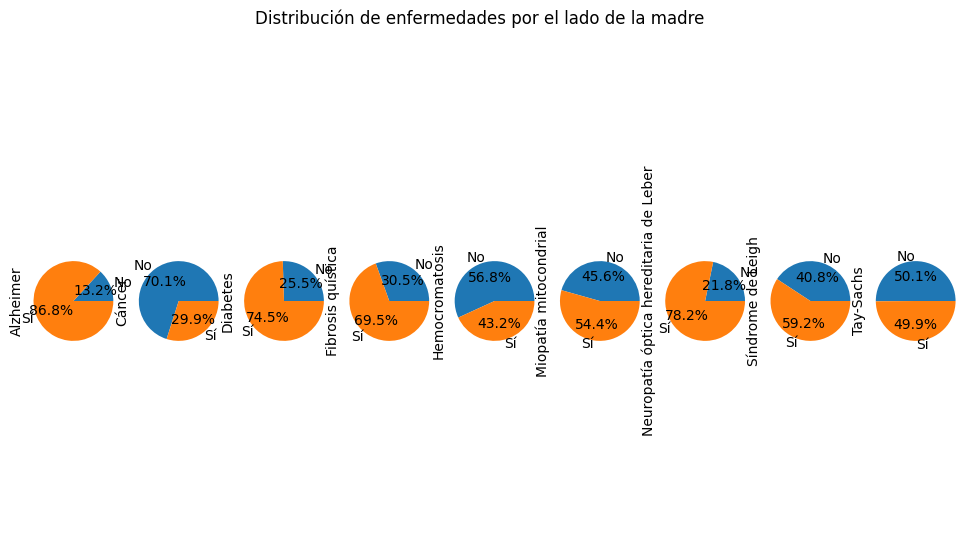

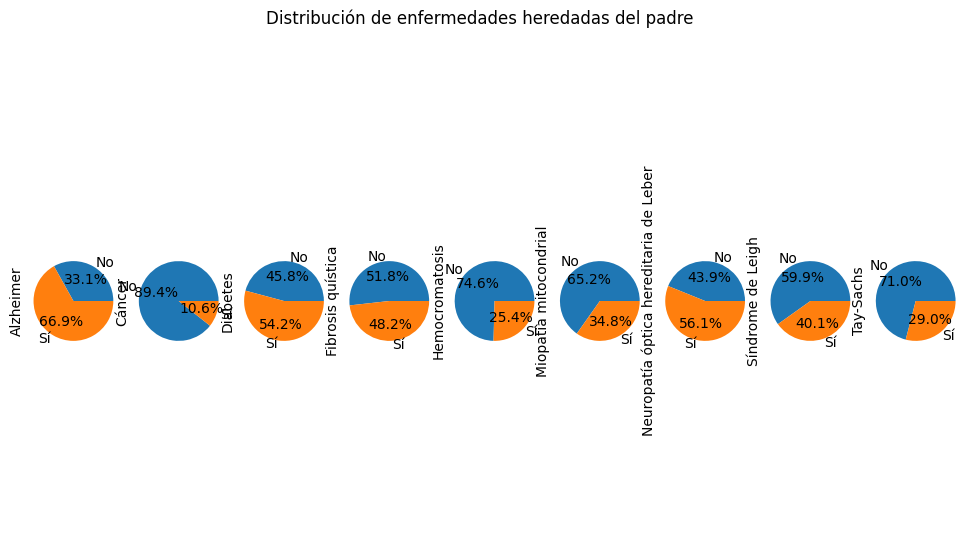

In [216]:
# Función para crear gráficos de pastel apilados
def plot_stacked_pie(data, x_col, hue_col, labels_dict, title):
    
    # Reemplazar los valores en los datos antes de agrupar y contar
    data = data.copy()
    data[hue_col] = data[hue_col].map(labels_dict).fillna(data[hue_col])
    data[x_col] = data[x_col].replace({'Yes': 'Sí', 'No': 'No'})
    
    # Agrupar y contar la frecuencia de cada combinación
    grouped_data = data.groupby([x_col, hue_col]).size().unstack(fill_value=0)
    
    # Crear el gráfico de pastel apilado
    ax = grouped_data.plot(kind='pie', subplots=True, autopct='%1.1f%%', figsize=(12, 6), legend=False) 

    # Modificar las etiquetas en el gráfico
    for a in ax:
        labels = [label.get_text().replace('Yes', 'Sí').replace('No', 'No') for label in a.get_xticklabels()]
        a.set_xticklabels(labels)
    
    # Título del gráfico
    plt.suptitle(title)
    plt.axis('equal')
    plt.show()

# Gráficos de pastel apilados para Desorden Genético
plot_stacked_pie(train_df, 'Maternal gene', 'Genetic Disorder', genetic_disorder_dict, 'Distribución de desórdenes por genes maternos')
plot_stacked_pie(train_df, 'Paternal gene', 'Genetic Disorder', genetic_disorder_dict, 'Distribución de desórdenes por genes paternos')
plot_stacked_pie(train_df, 'Genes in mother\'s side', 'Genetic Disorder', genetic_disorder_dict, 'Distribución de desórdenes genéticos por el lado de la madre')
plot_stacked_pie(train_df, 'Inherited from father', 'Genetic Disorder', genetic_disorder_dict, 'Distribución de desórdenes genéticos heredados del padre')

# Gráficos de pastel apilados para Subclase del Desorden
plot_stacked_pie(train_df, 'Maternal gene', 'Disorder Subclass', disorder_subclass_dict, 'Distribución de enfermedades por genes maternos')
plot_stacked_pie(train_df, 'Paternal gene', 'Disorder Subclass', disorder_subclass_dict, 'Distribución de enfermedades por genes paternos')
plot_stacked_pie(train_df, 'Genes in mother\'s side', 'Disorder Subclass', disorder_subclass_dict, 'Distribución de enfermedades por el lado de la madre')
plot_stacked_pie(train_df, 'Inherited from father', 'Disorder Subclass', disorder_subclass_dict, 'Distribución de enfermedades heredadas del padre')

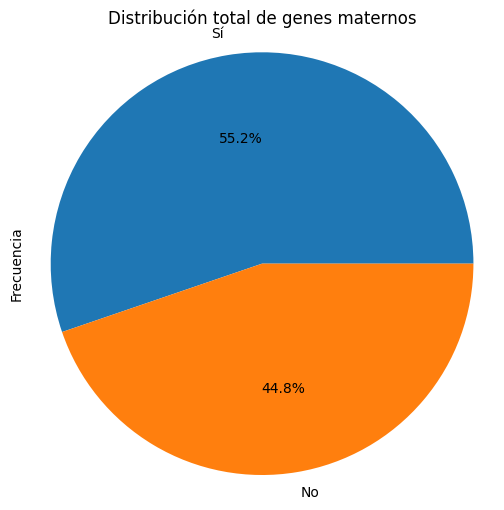

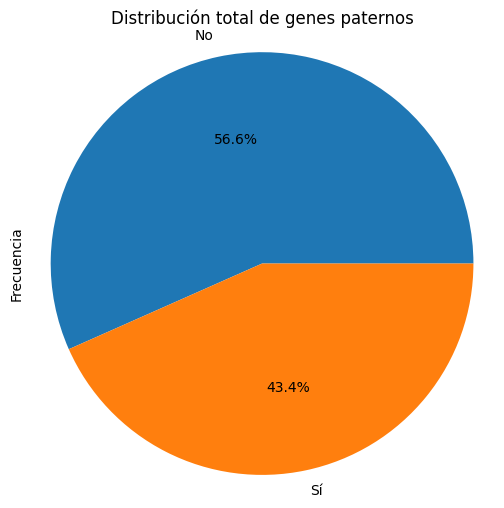

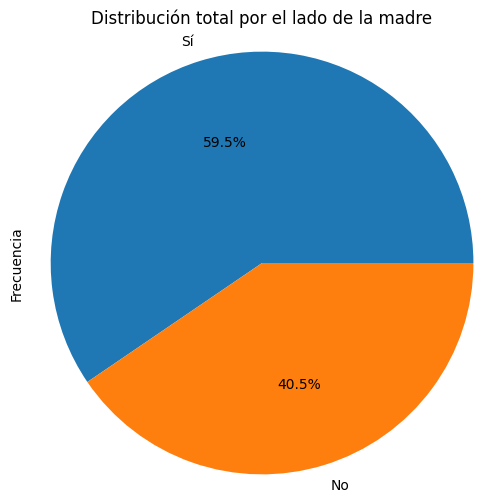

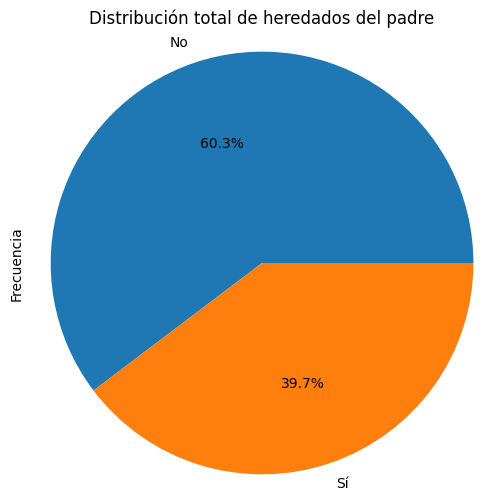

In [225]:
def plot_general_pie(data, hue_col, labels_dict, title):
    # Reemplazar los valores en los datos antes de agrupar y contar
    data = data.copy()
    data[hue_col] = data[hue_col].map(labels_dict).fillna(data[hue_col])
    
    # Agrupar y contar la frecuencia de cada combinación
    grouped_data = data[hue_col].value_counts()
    
    # Crear el gráfico de pastel
    ax = grouped_data.plot(kind='pie', autopct='%1.1f%%', figsize=(6, 6), legend=False, labels=['Sí' if label == 'Yes' else 'No' for label in grouped_data.index]) 
    
    # Título del gráfico
    plt.title(title)
    plt.axis('equal')
    plt.ylabel('Frecuencia')
    plt.show()


# Gráficos de pastel generales
plot_general_pie(train_df, 'Maternal gene', genetic_disorder_dict, 'Distribución total de genes maternos')
plot_general_pie(train_df, 'Paternal gene', genetic_disorder_dict, 'Distribución total de genes paternos')
plot_general_pie(train_df, 'Genes in mother\'s side', genetic_disorder_dict, 'Distribución total por el lado de la madre')
plot_general_pie(train_df, 'Inherited from father', genetic_disorder_dict, 'Distribución total de heredados del padre')


<Figure size 1000x600 with 0 Axes>

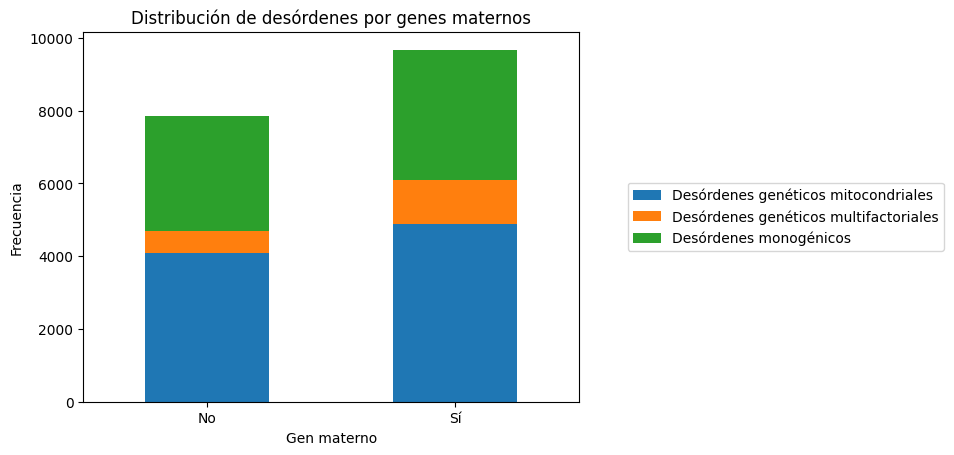

<Figure size 1000x600 with 0 Axes>

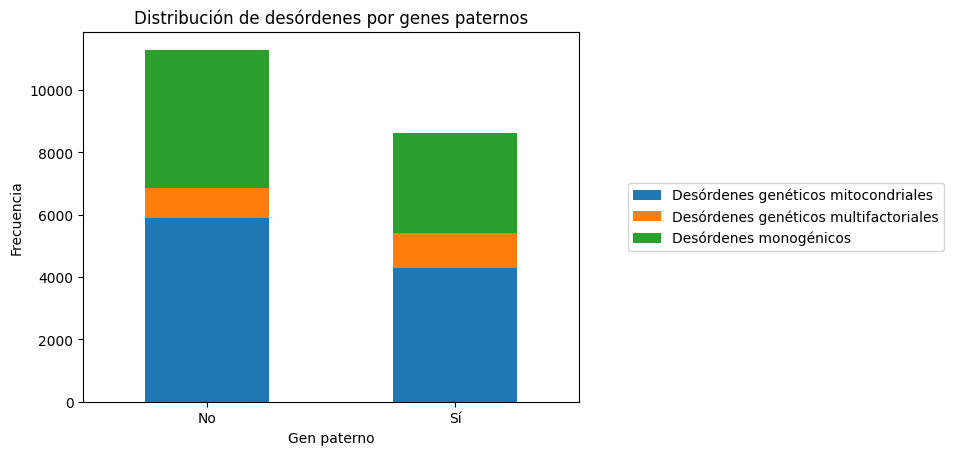

<Figure size 1000x600 with 0 Axes>

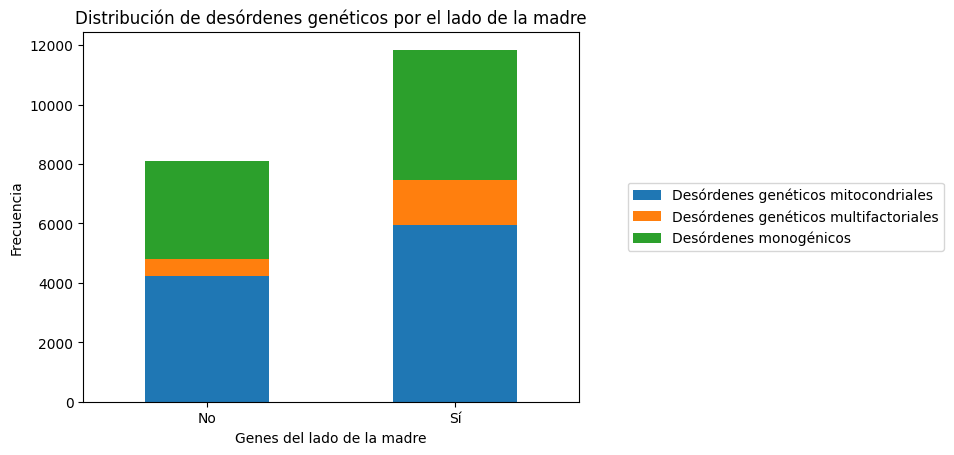

<Figure size 1000x600 with 0 Axes>

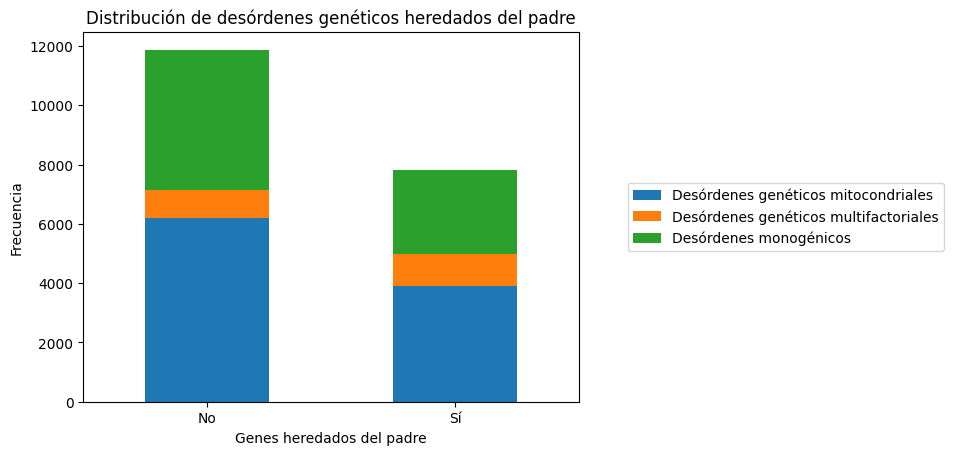

<Figure size 1000x600 with 0 Axes>

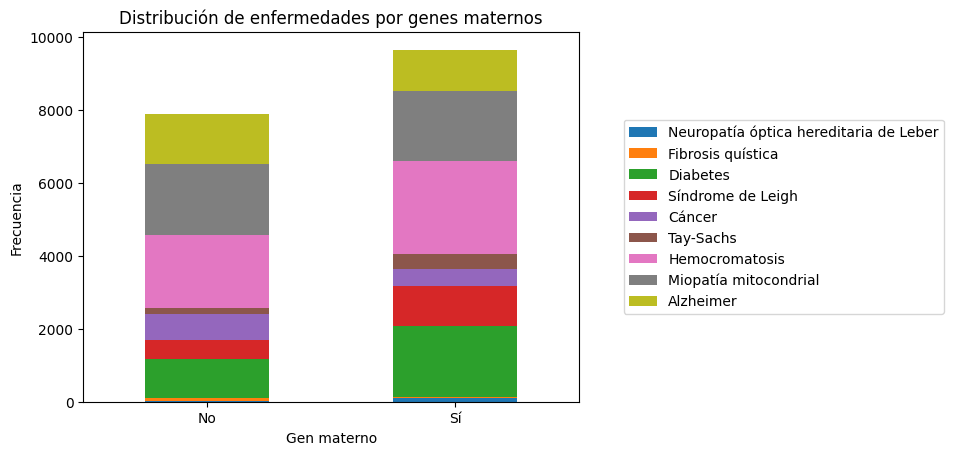

<Figure size 1000x600 with 0 Axes>

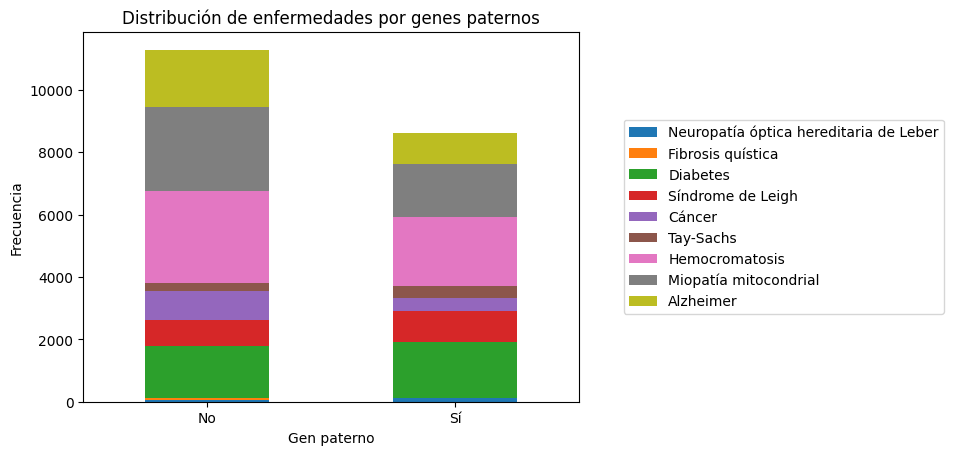

<Figure size 1000x600 with 0 Axes>

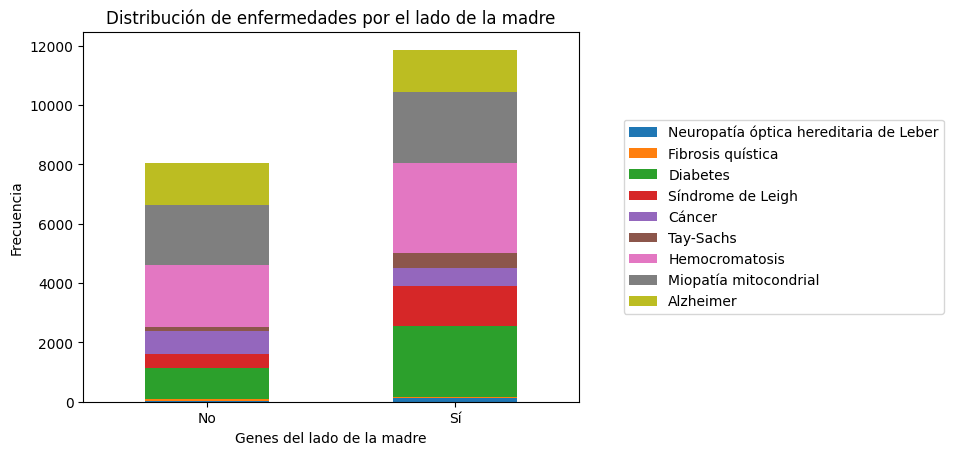

<Figure size 1000x600 with 0 Axes>

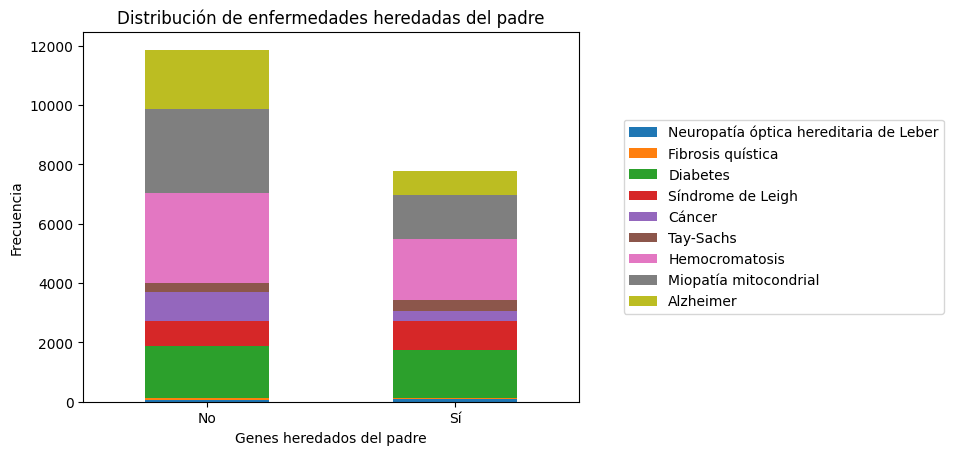

In [233]:
# Función para crear gráficos de barras apiladas
def plot_stacked_bar(data, x_col, hue_col, labels, title, x_label):
    plt.figure(figsize=(10, 6))
    ax = pd.crosstab(data[x_col], data[hue_col]).rename(index={'Yes': 'Sí', 'No': 'No'}).plot(kind='bar', stacked=True)
    plt.title(title)
    ax.set_xlabel(x_label)
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=0)
    
    # Obtén las etiquetas actuales
    handles, _ = ax.get_legend_handles_labels()
    
    # Traduce las etiquetas usando el diccionario proporcionado
    labels = [labels.get(label, label) for label in labels]
    
    # Establece las nuevas etiquetas
    plt.legend(handles, labels, loc='center right', bbox_to_anchor=(1.75, 0.5))  
    
    plt.show()

# Gráficos para Desorden Genético
plot_stacked_bar(train_df, 'Maternal gene', 'Genetic Disorder', genetic_disorder_dict, 'Distribución de desórdenes por genes maternos', 'Gen materno')
plot_stacked_bar(train_df, 'Paternal gene', 'Genetic Disorder', genetic_disorder_dict, 'Distribución de desórdenes por genes paternos', 'Gen paterno')
plot_stacked_bar(train_df, 'Genes in mother\'s side', 'Genetic Disorder', genetic_disorder_dict, 'Distribución de desórdenes genéticos por el lado de la madre', 'Genes del lado de la madre')
plot_stacked_bar(train_df, 'Inherited from father', 'Genetic Disorder', genetic_disorder_dict, 'Distribución de desórdenes genéticos heredados del padre', 'Genes heredados del padre')

# Gráficos para Subclase del Desorden
plot_stacked_bar(train_df, 'Maternal gene', 'Disorder Subclass', disorder_subclass_dict, 'Distribución de enfermedades por genes maternos', 'Gen materno')
plot_stacked_bar(train_df, 'Paternal gene', 'Disorder Subclass', disorder_subclass_dict, 'Distribución de enfermedades por genes paternos', 'Gen paterno')
plot_stacked_bar(train_df, 'Genes in mother\'s side', 'Disorder Subclass', disorder_subclass_dict, 'Distribución de enfermedades por el lado de la madre', 'Genes del lado de la madre')
plot_stacked_bar(train_df, 'Inherited from father', 'Disorder Subclass', disorder_subclass_dict, 'Distribución de enfermedades heredadas del padre', 'Genes heredados del padre')

#### 3.4 Distribución por edad

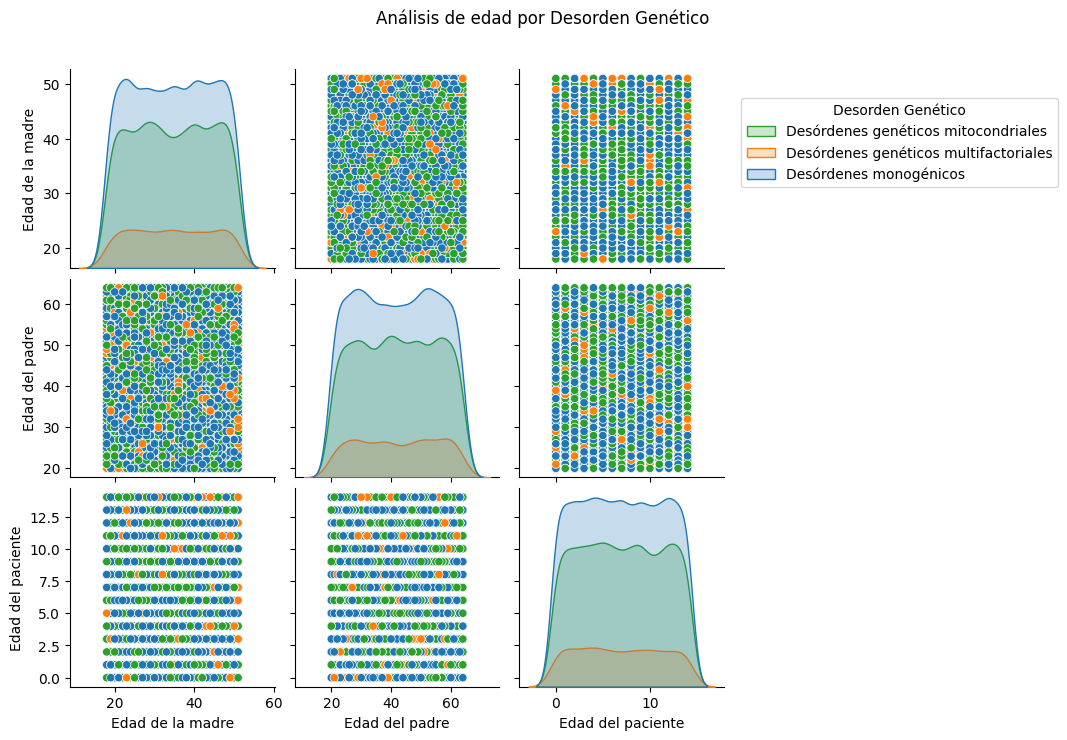

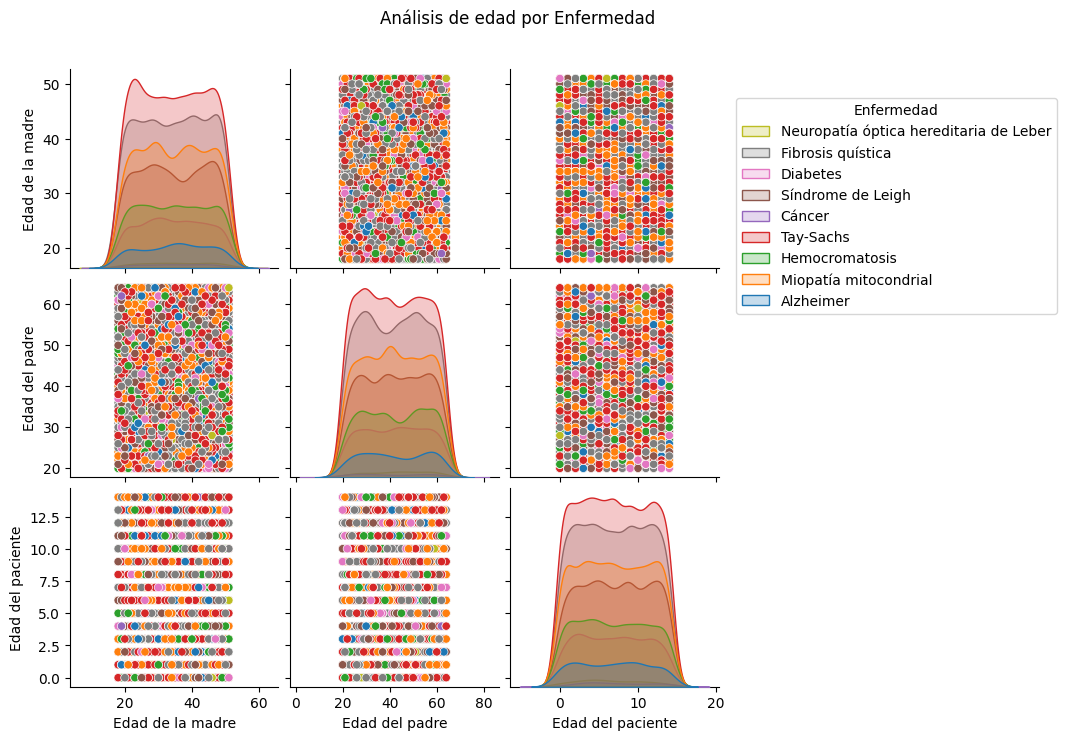

In [235]:
# Función para crear pair plots
def create_pairplot(data, vars, hue, labels, title):
    g = sns.pairplot(data, vars=vars, hue=hue, diag_kind='kde')
    
    g._legend.remove()
    
    # Traduce las etiquetas usando el diccionario proporcionado
    labels = [labels.get(label, label) for label in labels]
    plt.legend(title=title, bbox_to_anchor=(1.05, 3), loc='upper left', labels=labels, ncol=1)
    
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle(f'Análisis de edad por {title}')
    
    for i in range(len(vars)):
        for j in range(len(vars)):
            xlabel = g.axes[i][j].get_xlabel()
            ylabel = g.axes[i][j].get_ylabel()
            if xlabel == 'Mother\'s age':
                g.axes[i][j].set_xlabel('Edad de la madre')
            elif xlabel == 'Father\'s age':
                g.axes[i][j].set_xlabel('Edad del padre')
            elif xlabel == 'Patient Age':
                g.axes[i][j].set_xlabel('Edad del paciente')
            if ylabel == 'Mother\'s age':
                g.axes[i][j].set_ylabel('Edad de la madre')
            elif ylabel == 'Father\'s age':
                g.axes[i][j].set_ylabel('Edad del padre')
            elif ylabel == 'Patient Age':
                g.axes[i][j].set_ylabel('Edad del paciente')
    
    plt.show()

# Crear pair plot para Desorden Genético
create_pairplot(train_df, ['Mother\'s age', 'Father\'s age', 'Patient Age'], 'Genetic Disorder', genetic_disorder_dict, 'Desorden Genético')

# Crear pair plot para Subclase del Desorden
create_pairplot(train_df, ['Mother\'s age', 'Father\'s age', 'Patient Age'], 'Disorder Subclass', disorder_subclass_dict, 'Enfermedad')

### 4 Normalizacion e Ingeniería de Características

#### 4.1. Determinacion de las caractersiticas no importantes  

In [236]:
# Preprocesamiento: convertir las columnas de objeto a categorías para el modelo de árbol de decisión
for column in train_df.columns:
    if train_df[column].dtype == type(object):
        le = LabelEncoder()
        train_df[column] = le.fit_transform(train_df[column].astype(str))

# Función para obtener la importancia de las características
def get_feature_importance(X, y, target_name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train, y_train)
    
    feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
    feature_importance = feature_importance.sort_values('Importance', ascending=False)
    
    print(f"Feature importance for {target_name}:")
    print(feature_importance)
    print("\n")

# Obtener importancia de características para 'Genetic Disorder' y 'Disorder Subclass'
X = train_df.drop(['Genetic Disorder', 'Disorder Subclass'], axis=1)
for target in ['Genetic Disorder', 'Disorder Subclass']:
    get_feature_importance(X, train_df[target], target)

Feature importance for Genetic Disorder:
                                             Feature  Importance
43                           Genetic Disorder Mapped    0.853184
44                          Disorder Subclass Mapped    0.102103
42                                         Symptom 5    0.004052
0                                         Patient Id    0.003887
11                                      Father's age    0.003038
9                                      Father's name    0.002782
36  White Blood cell count (thousand per microliter)    0.002773
6                             Blood cell count (mcL)    0.002631
7                                 Patient First Name    0.002425
41                                         Symptom 4    0.002053
10                                      Mother's age    0.001643
40                                         Symptom 3    0.001637
13                             Location of Institute    0.001632
37                                 Blood test res

#### 4.2 Eliminacion de caracteristicas

In [281]:
# Lista de características a eliminar
drop_features = ['Patient Id', 'Patient First Name', 'Family Name', 'Father\'s name', 'Institute Name', 'Location of Institute', 'Place of birth', 'Parental consent', 'Test 1', 'Test 2', 'Test 3', 'Test 4', 'Test 5']

# Eliminar las características del DataFrame
train_df = train_df.drop(drop_features, axis=1)

print("Primeras filas del DataFrame después de eliminar características:")
train_df.head()

Primeras filas del DataFrame después de eliminar características:


Patient Age Genes in mother's side Inherited from father Maternal gene  \
0          2.0                    Yes                    No           Yes   
1          4.0                    Yes                   Yes            No   
2          6.0                    Yes                    No            No   
3         12.0                    Yes                    No           Yes   
4         11.0                    Yes                    No           NaN   

  Paternal gene  Blood cell count (mcL)  Mother's age  Father's age    Status  \
0            No                4.760603           NaN           NaN     Alive   
1            No                4.910669           NaN          23.0  Deceased   
2            No                4.893297          41.0          22.0     Alive   
3            No                4.705280          21.0           NaN  Deceased   
4           Yes                4.720703          32.0           NaN     Alive   

  Respiratory Rate (breaths/min)  ... Birth defects  \
0                 Normal (30-60)  ...           NaN   
1                      Tachypnea  ...      Multiple   
2                 Normal (30-60)  ...      Singular   
3                      Tachypnea  ...      Singular   
4                      Tachypnea  ...      Multiple   

  White Blood cell count (thousand per microliter) Blood test result  \
0                                         9.857562               NaN   
1                                         5.522560            normal   
2                                              NaN            normal   
3                                         7.919321      inconclusive   
4                                         4.098210               NaN   

  Symptom 1 Symptom 2 Symptom 3 Symptom 4 Symptom 5  \
0       1.0       1.0       1.0       1.0       1.0   
1       1.0       NaN       1.0       1.0       0.0   
2       0.0       1.0       1.0       1.0       1.0   
3       0.0       0.0       1.0       0.0       0.0   
4       0.0       0.0       0.0       0.0       NaN   

                               Genetic Disorder  \
0   Mitochondrial genetic inheritance disorders   
1                                           NaN   
2  Multifactorial genetic inheritance disorders   
3   Mitochondrial genetic inheritance disorders   
4  Multifactorial genetic inheritance disorders   

                     Disorder Subclass  
0  Leber's hereditary optic neuropathy  
1                      Cystic fibrosis  
2                             Diabetes  
3                       Leigh syndrome  
4                               Cancer  

[5 rows x 32 columns]

#### 4.3 Imputacion de valores nulos

In [282]:
# Valores únicos para cada una de las columnas
for column in train_df.columns:
    print(f"\nValores únicos en la columna '{column}':")
    print(train_df[column].unique())

# Verificar si hay filas con todos los valores como NaN
nan_rows = train_df.isnull().all(axis=1)
print(f'Número de filas con todos los valores como NaN: {nan_rows.sum()}')


Valores únicos en la columna 'Patient Age':
[ 2.  4.  6. 12. 11. 14.  3.  7.  1.  0. nan 10.  5. 13.  8.  9.]

Valores únicos en la columna 'Genes in mother's side':
['Yes' 'No']

Valores únicos en la columna 'Inherited from father':
['No' 'Yes' nan]

Valores únicos en la columna 'Maternal gene':
['Yes' 'No' nan]

Valores únicos en la columna 'Paternal gene':
['No' 'Yes']

Valores únicos en la columna 'Blood cell count (mcL)':
[4.76060309 4.91066906 4.89329743 ... 5.1864702  4.85854267 4.73806671]

Valores únicos en la columna 'Mother's age':
[nan 41. 21. 32. 40. 45. 44. 50. 28. 30. 24. 36. 51. 23. 49. 46. 18. 38.
 37. 42. 48. 25. 19. 47. 34. 35. 22. 33. 20. 26. 31. 29. 27. 43. 39.]

Valores únicos en la columna 'Father's age':
[nan 23. 22. 63. 44. 42. 56. 20. 24. 57. 48. 30. 55. 62. 43. 32. 41. 52.
 28. 31. 61. 35. 49. 50. 29. 64. 39. 34. 51. 25. 60. 53. 58. 26. 27. 59.
 47. 38. 54. 21. 37. 36. 33. 46. 40. 45.]

Valores únicos en la columna 'Status':
['Alive' 'Deceased']

Valores úni

##### 4.3.1 Reemplazo de valores nulos con ceros

In [283]:
# Reemplazar los valores NaN en las columnas de predicción con 'None'
for col in ['Genetic Disorder', 'Disorder Subclass']:
    train_df[col] = train_df[col].fillna('None')

# Lista de columnas numéricas para excluir
problem_cols = ['Patient Age', 'Mother\'s age', 'Father\'s age', 'White Blood cell count (thousand per microliter)']

# Reemplazar todos los valores NaN con ceros, excluyendo las columnas problema
for col in train_df.columns:
    if col not in problem_cols:
        train_df[col] = train_df[col].fillna(0).infer_objects(copy=False)

print("Información del DataFrame después de reemplazar valores nulos:")
print(train_df.info())

Información del DataFrame después de reemplazar valores nulos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22083 entries, 0 to 22082
Data columns (total 32 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Patient Age                                       20656 non-null  float64
 1   Genes in mother's side                            22083 non-null  object 
 2   Inherited from father                             22083 non-null  object 
 3   Maternal gene                                     22083 non-null  object 
 4   Paternal gene                                     22083 non-null  object 
 5   Blood cell count (mcL)                            22083 non-null  float64
 6   Mother's age                                      16047 non-null  float64
 7   Father's age                                      16097 non-null  float64
 8   Status                           

##### 4.3.2 Codificación de las características

In [284]:
# Codificar las características categóricas
train_df['Genes in mother\'s side'] = train_df['Genes in mother\'s side'].map({'No': 0, 'Yes': 1})
train_df['Inherited from father'] = train_df['Inherited from father'].map({'No': 0, 'Yes': 1})
train_df['Maternal gene'] = train_df['Maternal gene'].map({'No': 0, 'Yes': 1})
train_df['Paternal gene'] = train_df['Paternal gene'].map({'No': 0, 'Yes': 1})
train_df['Status'] = train_df['Status'].map({'Deceased': 0, 'Alive': 1, })
train_df['Respiratory Rate (breaths/min)'] = train_df['Respiratory Rate (breaths/min)'].map({'Normal (30-60)': 0, 'Tachypnea': 1})
train_df['Heart Rate (rates/min'] = train_df['Heart Rate (rates/min'].map({'Normal': 0, 'Tachycardia': 1})
train_df['Follow-up'] = train_df['Follow-up'].map({'Low': 0, 'High': 1})
train_df['Gender'] = train_df['Gender'].map({'Male': 0, 'Female': 1, 'Ambiguous': 2})
train_df['Birth asphyxia'] = train_df['Birth asphyxia'].map({'No record': 0, 'Not available': 0, 'No': 0, 'Yes': 1})
train_df['Autopsy shows birth defect (if applicable)'] = train_df['Autopsy shows birth defect (if applicable)'].map({'No': 0, 'Yes': 1, 'Not applicable': -1})
train_df['Folic acid details (peri-conceptional)'] = train_df['Folic acid details (peri-conceptional)'].map({'No': 0, 'Yes': 1})
train_df['H/O serious maternal illness'] = train_df['H/O serious maternal illness'].map({'No': 0, 'Yes': 1})
train_df['H/O radiation exposure (x-ray)'] = train_df['H/O radiation exposure (x-ray)'].map({'No': 0, 'Yes': 1})
train_df['H/O substance abuse'] = train_df['H/O substance abuse'].map({'No': 0, 'Yes': 1, 'Not applicable': -1})
train_df['Assisted conception IVF/ART'] = train_df['Assisted conception IVF/ART'].map({'No': 0, 'Yes': 1})
train_df['History of anomalies in previous pregnancies'] = train_df['History of anomalies in previous pregnancies'].map({'No': 0, 'Yes': 1})
train_df['Birth defects'] = train_df['Birth defects'].map({'Singular': 0, 'Multiple': 1})
train_df['Blood test result'] = train_df['Blood test result'].map({'normal': 0, 'inconclusive': 1, 'slightly abnormal': 2, 'abnormal': 3})

In [285]:
print("Primeras filas del DataFrame después de la codificación:")
train_df.head()

Primeras filas del DataFrame después de la codificación:


Patient Age  Genes in mother's side  Inherited from father  Maternal gene  \
0          2.0                       1                    0.0            1.0   
1          4.0                       1                    1.0            0.0   
2          6.0                       1                    0.0            0.0   
3         12.0                       1                    0.0            1.0   
4         11.0                       1                    0.0            NaN   

   Paternal gene  Blood cell count (mcL)  Mother's age  Father's age  Status  \
0              0                4.760603           NaN           NaN       1   
1              0                4.910669           NaN          23.0       0   
2              0                4.893297          41.0          22.0       1   
3              0                4.705280          21.0           NaN       0   
4              1                4.720703          32.0           NaN       1   

   Respiratory Rate (breaths/min)  ...  Birth defects  \
0                             0.0  ...            NaN   
1                             1.0  ...            1.0   
2                             0.0  ...            0.0   
3                             1.0  ...            0.0   
4                             1.0  ...            1.0   

   White Blood cell count (thousand per microliter)  Blood test result  \
0                                          9.857562                NaN   
1                                          5.522560                0.0   
2                                               NaN                0.0   
3                                          7.919321                1.0   
4                                          4.098210                NaN   

   Symptom 1  Symptom 2  Symptom 3  Symptom 4  Symptom 5  \
0        1.0        1.0        1.0        1.0        1.0   
1        1.0        0.0        1.0        1.0        0.0   
2        0.0        1.0        1.0        1.0        1.0   
3        0.0        0.0        1.0        0.0        0.0   
4        0.0        0.0        0.0        0.0        0.0   

                               Genetic Disorder  \
0   Mitochondrial genetic inheritance disorders   
1                                          None   
2  Multifactorial genetic inheritance disorders   
3   Mitochondrial genetic inheritance disorders   
4  Multifactorial genetic inheritance disorders   

                     Disorder Subclass  
0  Leber's hereditary optic neuropathy  
1                      Cystic fibrosis  
2                             Diabetes  
3                       Leigh syndrome  
4                               Cancer  

[5 rows x 32 columns]

##### 4.3.3 Normalización de los valores a enteros

In [286]:
# Lista de columnas que no se deben convertir a enteros
exclude_cols = ['Patient Age', 'Mother\'s age', 'Father\'s age', 'Blood cell count (mcL)', 'White Blood cell count (thousand per microliter)', 'Genetic Disorder', 'Disorder Subclass']

# Convertir todas las columnas relevantes a int
for col in train_df.columns:
    if col not in exclude_cols:
        train_df[col] = train_df[col].fillna(0).astype('Int64')
        
# Convertir las etiquetas a str
train_df[['Genetic Disorder', 'Disorder Subclass']] = train_df[['Genetic Disorder', 'Disorder Subclass']].astype(str)

print("Tipos de datos después de la conversión:")
print(train_df.dtypes)

Tipos de datos después de la conversión:
Patient Age                                         float64
Genes in mother's side                                Int64
Inherited from father                                 Int64
Maternal gene                                         Int64
Paternal gene                                         Int64
Blood cell count (mcL)                              float64
Mother's age                                        float64
Father's age                                        float64
Status                                                Int64
Respiratory Rate (breaths/min)                        Int64
Heart Rate (rates/min                                 Int64
Follow-up                                             Int64
Gender                                                Int64
Birth asphyxia                                        Int64
Autopsy shows birth defect (if applicable)            Int64
Folic acid details (peri-conceptional)                Int64

##### 4.3.4 Imputación de valores faltantes

In [287]:
# Hacer una copia del DataFrame original
train_df_copy = train_df.copy()

# Definir una semilla para la reproducibilidad
np.random.seed(42)

# Aplicar imputación KNN
knn_imputer = KNN()
train_df_copy[problem_cols] = knn_imputer.fit_transform(train_df_copy[problem_cols])

# Verificar valores faltantes después de la imputación
missing_after_imputation = train_df_copy[problem_cols].isnull().sum()
print("Valores faltantes después de la imputación:")
print(missing_after_imputation)

# Advertencia si hay valores imputados como 0
for feature in problem_cols:
    zero_count = (train_df_copy[feature] == 0).sum()
    if zero_count > 0:
        print(f"Advertencia: {zero_count} valores imputados como 0 en la columna '{feature}'")

# Aplicar corrección de rango utilizando los límites del DataFrame original
for feature in problem_cols:
    min_val = train_df[feature].min()
    max_val = train_df[feature].max()
    train_df_copy[feature] = np.clip(train_df_copy[feature], min_val, max_val)

# Redondear los valores imputados al entero más cercano para las columnas de edad
for feature in problem_cols:
    if feature != 'White Blood cell count (thousand per microliter)':
        train_df_copy[feature] = train_df_copy[feature].round().astype('Int64') 



Imputing row 1/22083 with 2 missing, elapsed time: 75.155
Imputing row 101/22083 with 1 missing, elapsed time: 75.173
Imputing row 201/22083 with 1 missing, elapsed time: 75.192
Imputing row 301/22083 with 1 missing, elapsed time: 75.209
Imputing row 401/22083 with 2 missing, elapsed time: 75.222
Imputing row 501/22083 with 0 missing, elapsed time: 75.238
Imputing row 601/22083 with 0 missing, elapsed time: 75.258
Imputing row 701/22083 with 1 missing, elapsed time: 75.280
Imputing row 801/22083 with 1 missing, elapsed time: 75.299
Imputing row 901/22083 with 0 missing, elapsed time: 75.324
Imputing row 1001/22083 with 0 missing, elapsed time: 75.339
Imputing row 1101/22083 with 1 missing, elapsed time: 75.355
Imputing row 1201/22083 with 1 missing, elapsed time: 75.366
Imputing row 1301/22083 with 1 missing, elapsed time: 75.380
Imputing row 1401/22083 with 0 missing, elapsed time: 75.394
Imputing row 1501/22083 with 0 missing, elapsed time: 75.406
Imputing row 1601/22083 with 0 missi

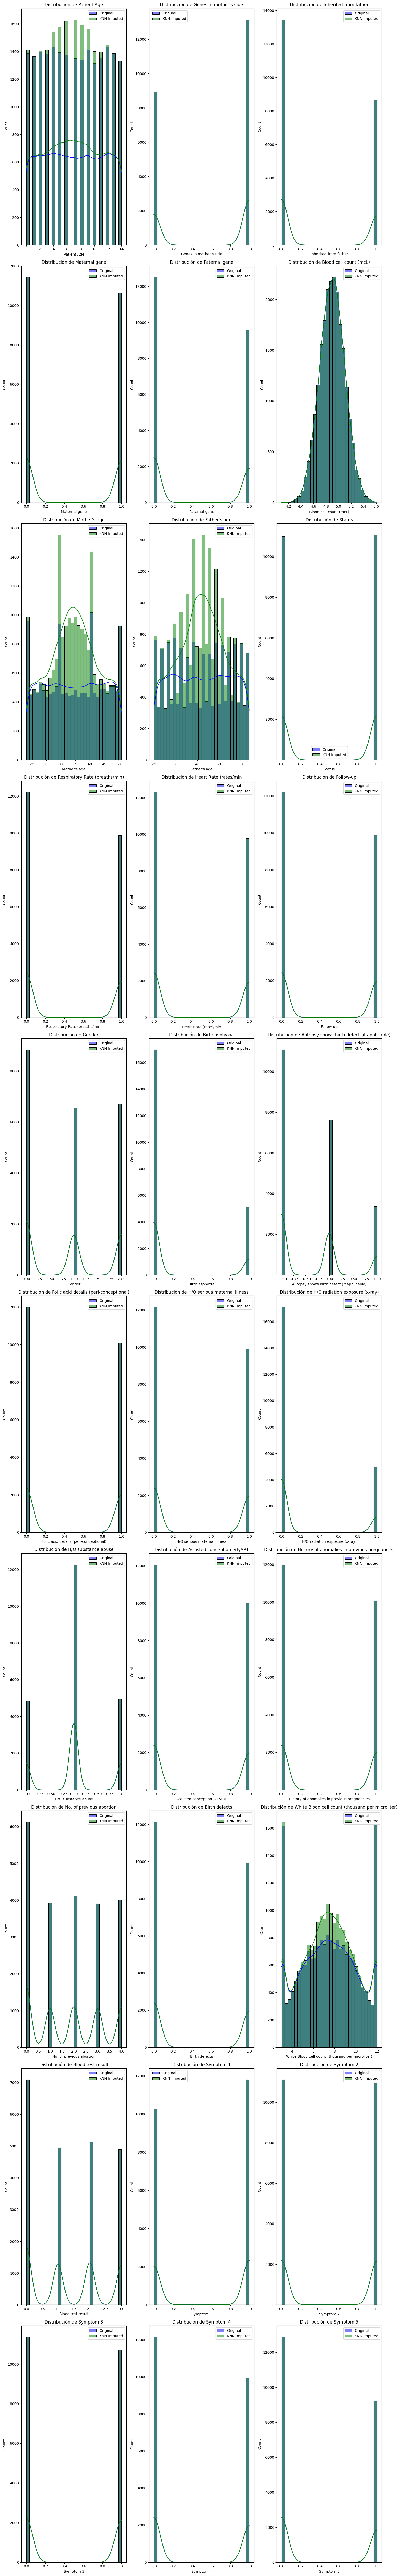

In [288]:
# Crear subtramas para cada conjunto de datos
num_features = train_df.select_dtypes(include=['int64', 'float64']).columns

n = len(num_features)
ncols = 3
nrows = n // ncols if n % ncols == 0 else n // ncols + 1

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*10))

axs = axs.flatten()

# Crear histogramas para cada característica numérica en los conjuntos de datos originales e imputados por KNN
for i, feature in enumerate(num_features):
    sns.histplot(train_df[feature], bins=30, ax=axs[i], color='blue', label='Original', kde=True)
    sns.histplot(train_df_copy[feature], bins=30, ax=axs[i], color='green', label='KNN Imputed', kde=True)
    axs[i].set_title(f'Distribución de {feature}')
    axs[i].legend()

nrowsncols = nrows * ncols
if n < nrowsncols:
    for j in range(i+1, nrowsncols):
        fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

In [424]:
# Sobrescribir train_df con train_df_copy después de la visualización
train_df = train_df_copy.copy()

##### 4.3.5 Revisión final y guardado

In [291]:
print("Primeras filas del DataFrame final:")
train_df.head()
print("\nInformación del DataFrame final:")
train_df.info()

Primeras filas del DataFrame final:

Información del DataFrame final:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22083 entries, 0 to 22082
Data columns (total 32 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Patient Age                                       20656 non-null  float64
 1   Genes in mother's side                            22083 non-null  Int64  
 2   Inherited from father                             22083 non-null  Int64  
 3   Maternal gene                                     22083 non-null  Int64  
 4   Paternal gene                                     22083 non-null  Int64  
 5   Blood cell count (mcL)                            22083 non-null  float64
 6   Mother's age                                      16047 non-null  float64
 7   Father's age                                      16097 non-null  float64
 8   Status                    

In [412]:
#Guardar el CSV limpio
train_df.to_csv('Genomes And Genetics/clean_train.csv', index=False)

#### 4.4 Matriz de Correlación

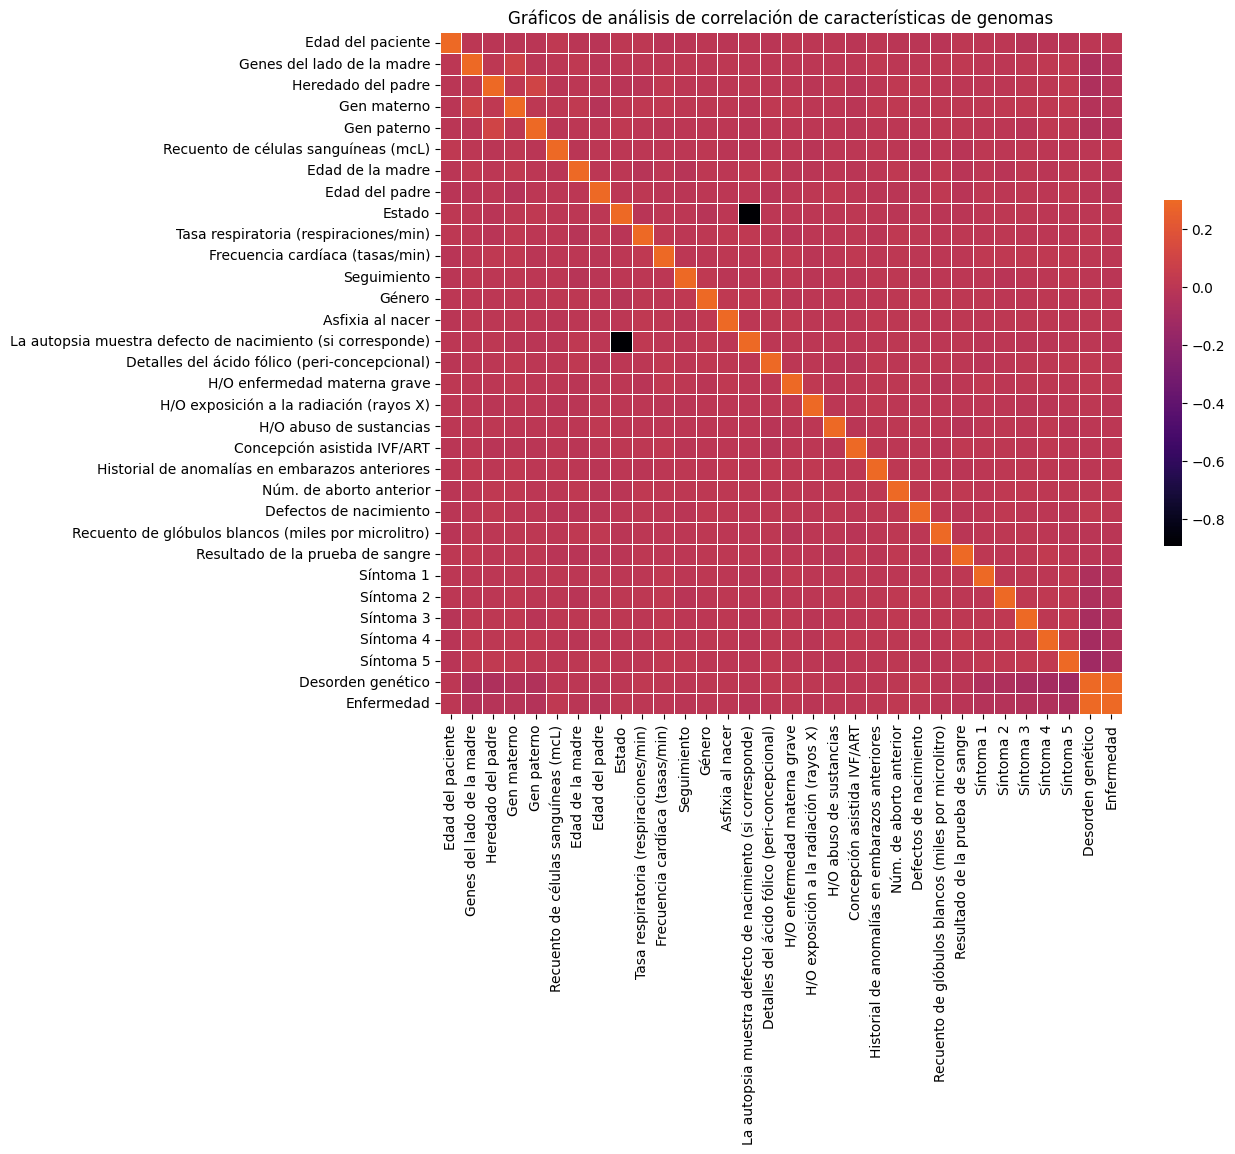

In [266]:
# Definir las etiquetas en español
column_labels = ['Edad del paciente', 'Genes del lado de la madre', 'Heredado del padre', 'Gen materno', 'Gen paterno', 'Recuento de células sanguíneas (mcL)', 'Edad de la madre', 'Edad del padre', 'Estado','Tasa respiratoria (respiraciones/min)', 'Frecuencia cardíaca (tasas/min)', 'Seguimiento', 'Género', 'Asfixia al nacer', 'La autopsia muestra defecto de nacimiento (si corresponde)', 'Detalles del ácido fólico (peri-concepcional)', 'H/O enfermedad materna grave', 'H/O exposición a la radiación (rayos X)', 'H/O abuso de sustancias', 'Concepción asistida IVF/ART', 'Historial de anomalías en embarazos anteriores', 'Núm. de aborto anterior', 'Defectos de nacimiento', 'Recuento de glóbulos blancos (miles por microlitro)', 'Resultado de la prueba de sangre', 'Síntoma 1', 'Síntoma 2', 'Síntoma 3', 'Síntoma 4', 'Síntoma 5', 'Desorden genético', 'Enfermedad']

# Crear una copia del DataFrame original para no sobreescribirlo
train_df_corr = train_df.copy()

# Realizar la codificación de conteo en las columnas 'Genetic Disorders' y 'Disorder Subclass' en el DataFrame copiado
train_df_corr['Genetic Disorder'] = train_df_corr['Genetic Disorder'].map(train_df_corr['Genetic Disorder'].value_counts())
train_df_corr['Disorder Subclass'] = train_df_corr['Disorder Subclass'].map(train_df_corr['Disorder Subclass'].value_counts())

# Calcular la matriz de correlación
corr = train_df_corr.corr()

# Crear una figura de matplotlib
fig, ax = plt.subplots(figsize=(11, 9))

# Generar un mapa de calor de divergencia personalizado
cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center="dark")

# Dibujar el mapa de calor con la máscara y la relación de aspecto correcta
sns.heatmap(corr, cmap='inferno', vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Establecer las etiquetas de los ejes y el título del gráfico
ax.set_xticklabels(column_labels, rotation=90)
ax.set_yticklabels(column_labels, rotation=0)
plt.title('Gráficos de análisis de correlación de características de genomas')

plt.show()

### 5. Balanceo de los Datos

In [267]:
print("Información del DataFrame antes del balanceo:")
print(train_df.info())

print("\nConteo de valores únicos de las subclases antes del balanceo:")
print(train_df['Disorder Subclass'].value_counts())

Información del DataFrame antes del balanceo:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22083 entries, 0 to 22082
Data columns (total 32 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Patient Age                                       20656 non-null  float64
 1   Genes in mother's side                            22083 non-null  Int64  
 2   Inherited from father                             22083 non-null  Int64  
 3   Maternal gene                                     22083 non-null  Int64  
 4   Paternal gene                                     22083 non-null  Int64  
 5   Blood cell count (mcL)                            22083 non-null  float64
 6   Mother's age                                      16047 non-null  float64
 7   Father's age                                      16097 non-null  float64
 8   Status                                            

In [268]:
# Balanceo de Clases por submuestreo

# Identificar el número mínimo de muestras entre las clases
min_class_samples = train_df['Genetic Disorder'].value_counts().min()

# Balancear el dataset por la clase de desorden genético
balanced_train_df = train_df.groupby('Genetic Disorder')[train_df.columns].apply(lambda x: x.sample(min_class_samples, random_state=42)).reset_index(drop=True)

# Verificar el balanceo de clases
print(balanced_train_df['Genetic Disorder'].value_counts())

# Verificar el balanceo de subclases
print(balanced_train_df['Disorder Subclass'].value_counts())

Genetic Disorder
Mitochondrial genetic inheritance disorders     2071
Multifactorial genetic inheritance disorders    2071
None                                            2071
Single-gene inheritance diseases                2071
Name: count, dtype: int64
Disorder Subclass
Diabetes                               1808
Leigh syndrome                         1396
Mitochondrial myopathy                 1265
Cystic fibrosis                        1142
Tay-Sachs                               955
None                                    837
Hemochromatosis                         453
Leber's hereditary optic neuropathy     179
Alzheimer's                             152
Cancer                                   97
Name: count, dtype: int64


In [270]:
print("\nPrimeras filas del DataFrame balanceado:")
balanced_train_df.head()


Primeras filas del DataFrame balanceado:


Patient Age  Genes in mother's side  Inherited from father  Maternal gene  \
0          8.0                       1                      0              0   
1         12.0                       1                      0              0   
2          7.0                       0                      0              1   
3         11.0                       0                      0              0   
4         10.0                       1                      0              0   

   Paternal gene  Blood cell count (mcL)  Mother's age  Father's age  Status  \
0              0                5.097499           NaN          55.0       1   
1              0                5.417897          47.0          37.0       0   
2              1                4.549514          40.0          49.0       0   
3              0                5.054856          20.0          24.0       1   
4              0                5.042533          20.0          57.0       0   

   Respiratory Rate (breaths/min)  ...  Birth defects  \
0                               0  ...              0   
1                               0  ...              0   
2                               1  ...              1   
3                               1  ...              1   
4                               0  ...              0   

   White Blood cell count (thousand per microliter)  Blood test result  \
0                                          6.660652                  3   
1                                          7.196387                  2   
2                                          3.000000                  1   
3                                         11.181075                  1   
4                                          6.330350                  3   

   Symptom 1  Symptom 2  Symptom 3  Symptom 4  Symptom 5  \
0          0          0          1          0          0   
1          0          1          1          1          0   
2          0          1          1          0          0   
3          1          0          0          1          0   
4          0          1          0          1          0   

                              Genetic Disorder       Disorder Subclass  
0  Mitochondrial genetic inheritance disorders          Leigh syndrome  
1  Mitochondrial genetic inheritance disorders  Mitochondrial myopathy  
2  Mitochondrial genetic inheritance disorders          Leigh syndrome  
3  Mitochondrial genetic inheritance disorders                    None  
4  Mitochondrial genetic inheritance disorders          Leigh syndrome  

[5 rows x 32 columns]

In [ ]:
# Guardar el dataset balanceado en un archivo CSV
balanced_train_df.to_csv('Genomes And Genetics/balanced_train.csv', index=False)

### 6. Preprocesamiento y codificacion del conjunto de prueba

In [144]:
# Lista de características a eliminar
drop_features = ['Patient Id', 'Patient First Name', 'Family Name', 'Father\'s name', 'Institute Name', 'Location of Institute', 'Place of birth', 'Parental consent', 'Test 1', 'Test 2', 'Test 3', 'Test 4', 'Test 5']

# Eliminar las características del DataFrame
test_df = test_df.drop(drop_features, axis=1)

# Verificar si hay filas con todos los valores como NaN
nan_rows = test_df.isnull().all(axis=1)
print(f'Número de filas con todos los valores como NaN: {nan_rows.sum()}')

# Contar los valores nulos por columna
null_counts = test_df.isnull().sum()
print("Número de valores nulos por columna:")
print(null_counts)

Número de filas con todos los valores como NaN: 0
Número de valores nulos por columna:
Patient Age                                            0
Genes in mother's side                                 0
Inherited from father                                551
Maternal gene                                       3723
Paternal gene                                          0
Blood cell count (mcL)                                 0
Mother's age                                           0
Father's age                                           0
Status                                                 0
Respiratory Rate (breaths/min)                      2886
Heart Rate (rates/min                               2900
Follow-up                                              0
Gender                                                 0
Birth asphyxia                                         0
Autopsy shows birth defect (if applicable)          1200
Folic acid details (peri-conceptional)                 0
H

In [146]:
# Ver los valores únicos para cada una de las columnas
for column in test_df.columns:
    print(f"\nValores únicos en la columna '{column}':")
    print(test_df[column].unique())


Valores únicos en la columna 'Patient Age':
[ 6 10  5 13  9  4 12  3  1  0 14  8  2 11  7]

Valores únicos en la columna 'Genes in mother's side':
['No' 'Yes']

Valores únicos en la columna 'Inherited from father':
['Yes' 'No' nan]

Valores únicos en la columna 'Maternal gene':
['No' nan 'Yes']

Valores únicos en la columna 'Paternal gene':
['No' 'Yes']

Valores únicos en la columna 'Blood cell count (mcL)':
[4.98165485 5.11888952 4.87620391 ... 4.89835233 4.80483966 5.42123643]

Valores únicos en la columna 'Mother's age':
[38 33 48 25 41 27 19 37 28 39 49 40 22 21 46 24 30 47 20 42 35 36 51 50
 45 34 44 43 32 26 31 18 23 29]

Valores únicos en la columna 'Father's age':
[61 53 60 55 38 25 22 24 51 56 23 48 33 37 45 62 64 36 58 43 27 46 50 30
 40 26 47 44 49 63 39 21 41 29 20 54 31 52 59 57 42 35 28 34 32]

Valores únicos en la columna 'Status':
['Alive' 'Deceased']

Valores únicos en la columna 'Respiratory Rate (breaths/min)':
['Tachypnea' nan '-99' 'Normal (30-60)']

Valores único

In [147]:
# Codificar las características categóricas
# NaN y valores nulos se codifican como -999
# Los valores -99 se mantienen

test_df['Genes in mother\'s side'] = test_df['Genes in mother\'s side'].map({'No': 0, 'Yes': 1})
test_df['Inherited from father'] = test_df['Inherited from father'].map({'No': 0, 'Yes': 1, np.nan: -999})
test_df['Maternal gene'] = test_df['Maternal gene'].map({'No': 0, 'Yes': 1, np.nan: -999})
test_df['Paternal gene'] = test_df['Paternal gene'].map({'No': 0, 'Yes': 1})
test_df['Status'] = test_df['Status'].map({'Deceased': 0, 'Alive': 1})
test_df['Respiratory Rate (breaths/min)'] = test_df['Respiratory Rate (breaths/min)'].map({'Normal (30-60)': 0, 'Tachypnea': 1, '-99': -99, np.nan: -999})
test_df['Heart Rate (rates/min'] = test_df['Heart Rate (rates/min'].map({'Normal': 0, 'Tachycardia': 1, '-99': -99, np.nan: -999})
test_df['Follow-up'] = test_df['Follow-up'].map({'Low': 0, 'High': 1, '-99': -99})
test_df['Gender'] = test_df['Gender'].map({'Male': 0, 'Female': 1, 'Ambiguous': 2, '-99': -99})
test_df['Birth asphyxia'] = test_df['Birth asphyxia'].map({'No record': 0, 'Not available': 0, 'No': 0, 'Yes': 1, '-99': -99})
test_df['Autopsy shows birth defect (if applicable)'] = test_df['Autopsy shows birth defect (if applicable)'].map({'No': 0, 'Yes': 1, 'Not applicable': -1, '-99': -99, np.nan: -999})
test_df['Folic acid details (peri-conceptional)'] = test_df['Folic acid details (peri-conceptional)'].map({'No': 0, 'Yes': 1, '-99': -99})
test_df['H/O serious maternal illness'] = test_df['H/O serious maternal illness'].map({'No': 0, 'Yes': 1, '-99': -99})
test_df['H/O radiation exposure (x-ray)'] = test_df['H/O radiation exposure (x-ray)'].map({'No': 0, 'Yes': 1, 'Not applicable': -1, '-99': -99, '-': -999})
test_df['H/O substance abuse'] = test_df['H/O substance abuse'].map({'No': 0, 'Yes': 1, 'Not applicable': -1, '-99': -99, '-': -999})
test_df['Assisted conception IVF/ART'] = test_df['Assisted conception IVF/ART'].map({'No': 0, 'Yes': 1, '-99': -99})
test_df['History of anomalies in previous pregnancies'] = test_df['History of anomalies in previous pregnancies'].map({'No': 0, 'Yes': 1, '-99': -99})
test_df['Birth defects'] = test_df['Birth defects'].map({'Singular': 0, 'Multiple': 1, '-99': -99})
test_df['Blood test result'] = test_df['Blood test result'].map({'normal': 0, 'inconclusive': 1, 'slightly abnormal': 2, 'abnormal': 3, '-99': -99})
test_df['Symptom 1'] = test_df['Symptom 1'].map({True: 1, False: 0})
test_df['Symptom 2'] = test_df['Symptom 2'].map({True: 1, False: 0})
test_df['Symptom 3'] = test_df['Symptom 3'].map({True: 1, False: 0})
test_df['Symptom 4'] = test_df['Symptom 4'].map({True: 1, False: 0})
test_df['Symptom 5'] = test_df['Symptom 5'].map({True: 1, False: 0})


In [148]:
print("\nPrimeras filas del DataFrame:")
test_df.head()

Patient Age  Genes in mother's side  Inherited from father  Maternal gene  \
0            6                       0                      1              0   
1           10                       1                      0           -999   
2            5                       0                   -999              0   
3           13                       0                      1              1   
4            5                       0                   -999           -999   

   Paternal gene  Blood cell count (mcL)  Mother's age  Father's age  Status  \
0              0                4.981655            38            61       1   
1              1                5.118890            33            53       1   
2              0                4.876204            48            60       0   
3              0                4.687767            25            55       1   
4              1                5.152362            41            38       0   

   Respiratory Rate (breaths/min)  ...  \
0                               1  ...   
1                            -999  ...   
2                            -999  ...   
3                             -99  ...   
4                               1  ...   

   History of anomalies in previous pregnancies  No. of previous abortion  \
0                                           -99                         2   
1                                             1                       -99   
2                                             0                         0   
3                                             1                       -99   
4                                             0                       -99   

   Birth defects  White Blood cell count (thousand per microliter)  \
0              1                                        -99.000000   
1              1                                          8.179584   
2              0                                        -99.000000   
3              0                                          6.884071   
4              1                                          6.195178   

   Blood test result  Symptom 1  Symptom 2  Symptom 3  Symptom 4  Symptom 5  
0                  2          1          1          1          1          1  
1                  0          0          0          0          1          0  
2                  2          0          0          1          1          0  
3                  0          1          0          1          0          1  
4                  0          1          1          1          1          0  

[5 rows x 30 columns]

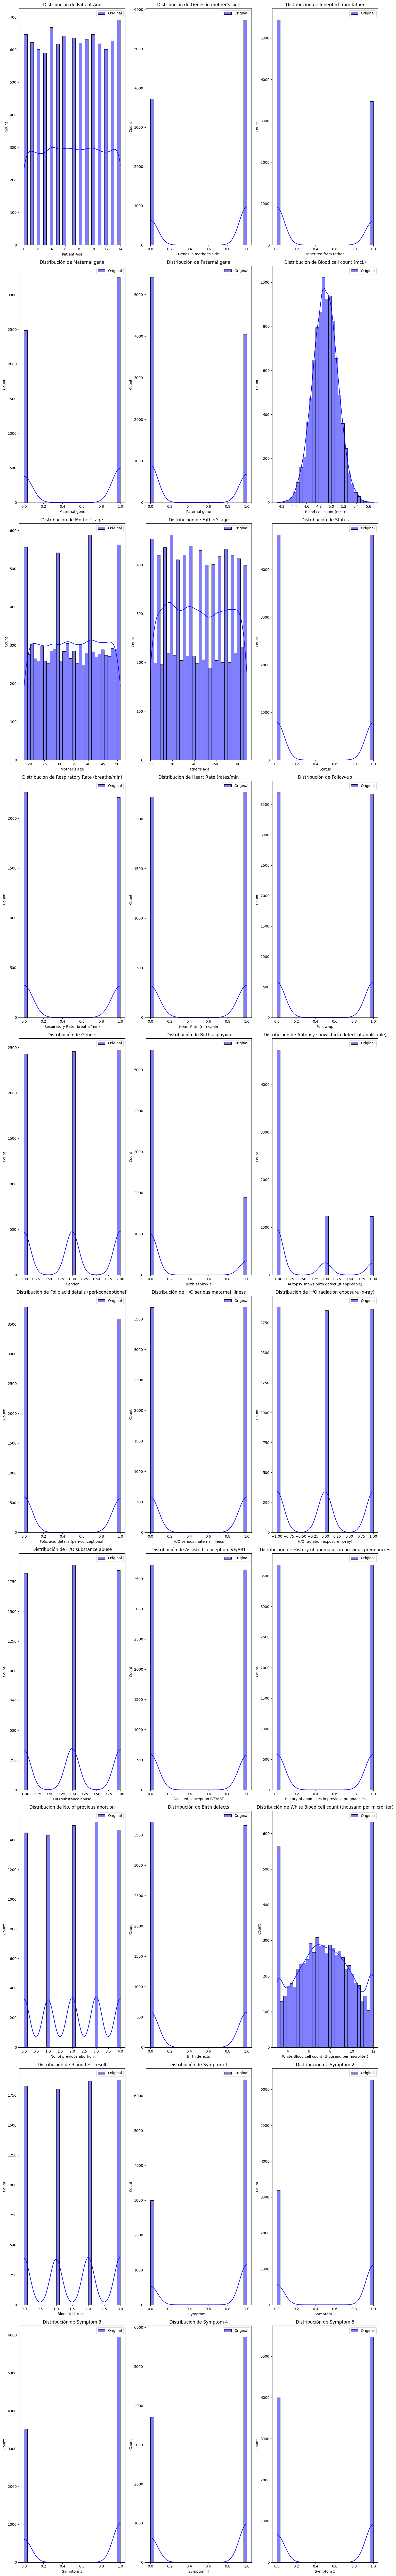

In [150]:
# Crear subplots para cada conjunto de datos
num_features = test_df.select_dtypes(include=['int64', 'float64']).columns

n = len(num_features)
ncols = 3
nrows = n // ncols if n % ncols == 0 else n // ncols + 1

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*10))

axs = axs.flatten()

# Crear histogramas para cada característica numérica en el conjunto de datos
for i, feature in enumerate(num_features):
    # Filtrar los valores -999
    data = test_df[(test_df[feature] != -999) & (test_df[feature] != -99)]
    sns.histplot(data[feature], bins=30, ax=axs[i], color='blue', label='Original', kde=True)
    axs[i].set_title(f'Distribución de {feature}')
    axs[i].legend()

if n < nrows*ncols:
    for j in range(i+1, nrows*ncols):
        fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

In [151]:
# Guardar el dataset limpio en un archivo CSV
test_df.to_csv('Genomes And Genetics/clean_test.csv', index=False)

## Entrenamiento de los modelos

#### 7.1 Cargar los datos nuevamente (Si es necesario)

In [297]:
# Cargar  y verificar los archivos CSV (Si es necesario)
train_df = pd.read_csv('Genomes And Genetics/clean_train.csv')

# Mostrar primeras filas del df
#print("Primeras filas del conjunto de entrenamiento:")
train_df.head()

# Cargar  y verificar el archivo balanceado(Si es necesario)
#balanced_train_df = pd.read_csv('Genomes And Genetics/balanced_train.csv')

# Mostrar primeras filas del df balanceado
#print("Primeras filas del conjunto de entrenamiento balanceado:")
#balanced_train_df.head()

Patient Age  Genes in mother's side  Inherited from father  Maternal gene  \
0            2                       1                      0              1   
1            4                       1                      1              0   
2            6                       1                      0              0   
3           12                       1                      0              1   
4           11                       1                      0              0   

   Paternal gene  Blood cell count (mcL)  Mother's age  Father's age  Status  \
0              0                4.760603            38            48       1   
1              0                4.910669            32            23       0   
2              0                4.893297            41            22       1   
3              0                4.705280            21            38       0   
4              1                4.720703            32            52       1   

   Respiratory Rate (breaths/min)  ...  Birth defects  \
0                               0  ...              0   
1                               1  ...              1   
2                               0  ...              0   
3                               1  ...              0   
4                               1  ...              1   

   White Blood cell count (thousand per microliter)  Blood test result  \
0                                          9.857562                  0   
1                                          5.522560                  0   
2                                          8.229498                  0   
3                                          7.919321                  1   
4                                          4.098210                  0   

   Symptom 1  Symptom 2  Symptom 3  Symptom 4  Symptom 5  \
0          1          1          1          1          1   
1          1          0          1          1          0   
2          0          1          1          1          1   
3          0          0          1          0          0   
4          0          0          0          0          0   

                               Genetic Disorder  \
0   Mitochondrial genetic inheritance disorders   
1                                           NaN   
2  Multifactorial genetic inheritance disorders   
3   Mitochondrial genetic inheritance disorders   
4  Multifactorial genetic inheritance disorders   

                     Disorder Subclass  
0  Leber's hereditary optic neuropathy  
1                      Cystic fibrosis  
2                             Diabetes  
3                       Leigh syndrome  
4                               Cancer  

[5 rows x 32 columns]

In [298]:
# Reemplazar NaN con el objeto None (Unicamente si se volvieron a cargar los datos)
train_df = train_df.applymap(lambda x: None if pd.isna(x) else x)
train_df['Genetic Disorder'] = train_df['Genetic Disorder'].fillna('None')
train_df['Disorder Subclass'] = train_df['Disorder Subclass'].fillna('None')

C:\Users\Dark Knight\AppData\Local\Temp\ipykernel_14692\266726617.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train_df = train_df.applymap(lambda x: None if pd.isna(x) else x)


#### 7.2 Modelo ETRF

##### 7.2.1 Entrenamiento Directo de Modelos ExtraTrees y RandomForest

In [202]:
# Entrenar el modelo ExtraTrees
et_model = ExtraTreesClassifier(n_estimators=100, random_state=42)
et_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Entrenar el modelo RandomForest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

In [211]:
# Obtener las probabilidades predichas por ET y RF para cada etiqueta
et_probs_genetic = et_probs[0]
et_probs_subclass = et_probs[1]
rf_probs_genetic = rf_probs[0]
rf_probs_subclass = rf_probs[1]

# Convertir las probabilidades a etiquetas predichas para cada etiqueta
et_preds_genetic = np.argmax(et_probs_genetic, axis=1)
et_preds_subclass = np.argmax(et_probs_subclass, axis=1)
rf_preds_genetic = np.argmax(rf_probs_genetic, axis=1)
rf_preds_subclass = np.argmax(rf_probs_subclass, axis=1)

# Convertir las etiquetas predichas a cadenas
et_preds_genetic = et_preds_genetic.astype(str)
et_preds_subclass = et_preds_subclass.astype(str)
rf_preds_genetic = rf_preds_genetic.astype(str)
rf_preds_subclass = rf_preds_subclass.astype(str)

In [231]:
# Evaluar el modelo ExtraTrees para 'Genetic Disorder'
et_accuracy_genetic = accuracy_score(y_test['Genetic Disorder'], et_preds_genetic)
et_hamming_genetic = hamming_loss(y_test['Genetic Disorder'], et_preds_genetic)
et_f1_genetic = f1_score(y_test['Genetic Disorder'], et_preds_genetic, average='weighted')
et_precision_genetic = precision_score(y_test['Genetic Disorder'], et_preds_genetic, average='weighted', zero_division=0)
et_recall_genetic = recall_score(y_test['Genetic Disorder'], et_preds_genetic, average='weighted', zero_division=0)
et_roc_auc_genetic = roc_auc_score(y_test['Genetic Disorder'], et_probs_genetic, average='weighted', multi_class='ovr')
et_logloss_genetic = log_loss(y_test['Genetic Disorder'], et_probs_genetic)

print(f'ET Accuracy (Genetic Disorder): {et_accuracy_genetic}')
print(f'ET Hamming Loss (Genetic Disorder): {et_hamming_genetic}')
print(f'ET F1 Score (Genetic Disorder): {et_f1_genetic}')
print(f'ET ROC AUC Score (Genetic Disorder): {et_roc_auc_genetic}')
print(f'ET Log Loss (Genetic Disorder): {et_logloss_genetic}')

# Evaluar el modelo ExtraTrees para 'Disorder Subclass'
et_accuracy_subclass = accuracy_score(y_test['Disorder Subclass'], et_preds_subclass)
et_hamming_subclass = hamming_loss(y_test['Disorder Subclass'], et_preds_subclass)
et_f1_subclass = f1_score(y_test['Disorder Subclass'], et_preds_subclass, average='weighted')
et_precision_subclass = precision_score(y_test['Disorder Subclass'], et_preds_subclass, average='weighted', zero_division=0)
et_recall_subclass = recall_score(y_test['Disorder Subclass'], et_preds_subclass, average='weighted', zero_division=0)
et_roc_auc_subclass = roc_auc_score(y_test['Disorder Subclass'], et_probs_subclass, average='weighted', multi_class='ovr')
et_logloss_subclass = log_loss(y_test['Disorder Subclass'], et_probs_subclass)

print(f'ET Accuracy (Disorder Subclass): {et_accuracy_subclass}')
print(f'ET Hamming Loss (Disorder Subclass): {et_hamming_subclass}')
print(f'ET F1 Score (Disorder Subclass): {et_f1_subclass}')
print(f'ET ROC AUC Score (Disorder Subclass): {et_roc_auc_subclass}')
print(f'ET Log Loss (Disorder Subclass): {et_logloss_subclass}')

ET Accuracy (Genetic Disorder): 0.0
ET Hamming Loss (Genetic Disorder): 1.0
ET F1 Score (Genetic Disorder): 0.0
ET ROC AUC Score (Genetic Disorder): 0.6656468172911592
ET Log Loss (Genetic Disorder): 1.0704647614795593
ET Accuracy (Disorder Subclass): 0.0
ET Hamming Loss (Disorder Subclass): 1.0
ET F1 Score (Disorder Subclass): 0.0
ET ROC AUC Score (Disorder Subclass): 0.7524892168623581
ET Log Loss (Disorder Subclass): 1.6052680218994888


In [232]:
# Evaluar el modelo RandomForest para 'Genetic Disorder'
rf_accuracy_genetic = accuracy_score(y_test['Genetic Disorder'], rf_preds_genetic)
rf_hamming_genetic = hamming_loss(y_test['Genetic Disorder'], rf_preds_genetic)
rf_f1_genetic = f1_score(y_test['Genetic Disorder'], rf_preds_genetic, average='weighted')
rf_precision_genetic = precision_score(y_test['Genetic Disorder'], rf_preds_genetic, average='weighted', zero_division=0)
rf_recall_genetic = recall_score(y_test['Genetic Disorder'], rf_preds_genetic, average='weighted', zero_division=0)
rf_roc_auc_genetic = roc_auc_score(y_test['Genetic Disorder'], rf_probs_genetic, average='weighted', multi_class='ovr')
rf_logloss_genetic = log_loss(y_test['Genetic Disorder'], rf_probs_genetic)

print(f'RF Accuracy (Genetic Disorder): {rf_accuracy_genetic}')
print(f'RF Hamming Loss (Genetic Disorder): {rf_hamming_genetic}')
print(f'RF F1 Score (Genetic Disorder): {rf_f1_genetic}')
print(f'RF ROC AUC Score (Genetic Disorder): {rf_roc_auc_genetic}')
print(f'RF Log Loss (Genetic Disorder): {rf_logloss_genetic}')

# Evaluar el modelo RandomForest para 'Disorder Subclass'
rf_accuracy_subclass = accuracy_score(y_test['Disorder Subclass'], rf_preds_subclass)
rf_hamming_subclass = hamming_loss(y_test['Disorder Subclass'], rf_preds_subclass)
rf_f1_subclass = f1_score(y_test['Disorder Subclass'], rf_preds_subclass, average='weighted')
rf_precision_subclass = precision_score(y_test['Disorder Subclass'], rf_preds_subclass, average='weighted', zero_division=0)
rf_recall_subclass = recall_score(y_test['Disorder Subclass'], rf_preds_subclass, average='weighted', zero_division=0)
rf_roc_auc_subclass = roc_auc_score(y_test['Disorder Subclass'], rf_probs_subclass, average='weighted', multi_class='ovr')
rf_logloss_subclass = log_loss(y_test['Disorder Subclass'], rf_probs_subclass)

print(f'RF Accuracy (Disorder Subclass): {rf_accuracy_subclass}')
print(f'RF Hamming Loss (Disorder Subclass): {rf_hamming_subclass}')
print(f'RF F1 Score (Disorder Subclass): {rf_f1_subclass}')
print(f'RF ROC AUC Score (Disorder Subclass): {rf_roc_auc_subclass}')
print(f'RF Log Loss (Disorder Subclass): {rf_logloss_subclass}')

RF Accuracy (Genetic Disorder): 0.0
RF Hamming Loss (Genetic Disorder): 1.0
RF F1 Score (Genetic Disorder): 0.0
RF ROC AUC Score (Genetic Disorder): 0.6605200715275324
RF Log Loss (Genetic Disorder): 1.0783557488306594
RF Accuracy (Disorder Subclass): 0.0
RF Hamming Loss (Disorder Subclass): 1.0
RF F1 Score (Disorder Subclass): 0.0
RF ROC AUC Score (Disorder Subclass): 0.7525990454883985
RF Log Loss (Disorder Subclass): 1.6212979577613211


In [223]:
# Validación cruzada para ExtraTrees sin optimizar - Genetic Disorder
cv_scores_et_unoptimized_genetic = cross_val_score(et_model, X_train, y_train['Genetic Disorder'], cv=5, scoring='accuracy')
print(f"Cross-validation scores for unoptimized ExtraTrees (Genetic Disorder): {cv_scores_et_unoptimized_genetic}")
print(f"Mean cross-validation score for unoptimized ExtraTrees (Genetic Disorder): {cv_scores_et_unoptimized_genetic.mean()}")

# Validación cruzada para ExtraTrees sin optimizar - Disorder Subclass
cv_scores_et_unoptimized_subclass = cross_val_score(et_model, X_train, y_train['Disorder Subclass'], cv=5, scoring='accuracy')
print(f"Cross-validation scores for unoptimized ExtraTrees (Disorder Subclass): {cv_scores_et_unoptimized_subclass}")
print(f"Mean cross-validation score for unoptimized ExtraTrees (Disorder Subclass): {cv_scores_et_unoptimized_subclass.mean()}")

# Validación cruzada para RandomForest sin optimizar - Genetic Disorder
cv_scores_rf_unoptimized_genetic = cross_val_score(rf_model, X_train, y_train['Genetic Disorder'], cv=5, scoring='accuracy')
print(f"Cross-validation scores for unoptimized RandomForest (Genetic Disorder): {cv_scores_rf_unoptimized_genetic}")
print(f"Mean cross-validation score for unoptimized RandomForest (Genetic Disorder): {cv_scores_rf_unoptimized_genetic.mean()}")

# Validación cruzada para RandomForest sin optimizar - Disorder Subclass
cv_scores_rf_unoptimized_subclass = cross_val_score(rf_model, X_train, y_train['Disorder Subclass'], cv=5, scoring='accuracy')
print(f"Cross-validation scores for unoptimized RandomForest (Disorder Subclass): {cv_scores_rf_unoptimized_subclass}")
print(f"Mean cross-validation score for unoptimized RandomForest (Disorder Subclass): {cv_scores_rf_unoptimized_subclass.mean()}")

Cross-validation scores for unoptimized ExtraTrees (Genetic Disorder): [0.508206   0.52787999 0.51061421 0.52108689 0.50919898]
Mean cross-validation score for unoptimized ExtraTrees (Genetic Disorder): 0.5153972144919973
Cross-validation scores for unoptimized ExtraTrees (Disorder Subclass): [0.32739106 0.33682423 0.33031418 0.33144636 0.3260685 ]
Mean cross-validation score for unoptimized ExtraTrees (Disorder Subclass): 0.3304088654934451
Cross-validation scores for unoptimized RandomForest (Genetic Disorder): [0.49349179 0.50976507 0.50750071 0.50608548 0.49929239]
Mean cross-validation score for unoptimized RandomForest (Genetic Disorder): 0.5032270879256155
Cross-validation scores for unoptimized RandomForest (Disorder Subclass): [0.31550651 0.32040759 0.33710727 0.33455986 0.32465327]
Mean cross-validation score for unoptimized RandomForest (Disorder Subclass): 0.326446900282581


In [221]:
# Definir los parámetros para GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Crear el modelo ExtraTrees
et_model = ExtraTreesClassifier(random_state=42)

# Crear el GridSearchCV para ExtraTrees
grid_search_et_genetic = GridSearchCV(estimator=et_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_et_subclass = GridSearchCV(estimator=et_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Ajustar el modelo con el conjunto de datos balanceado
grid_search_et_genetic.fit(X_train, y_train['Genetic Disorder'])
grid_search_et_subclass.fit(X_train, y_train['Disorder Subclass'])

# Mejor modelo y parámetros
best_et_model_genetic = grid_search_et_genetic.best_estimator_
best_et_model_subclass = grid_search_et_subclass.best_estimator_
print(f"Best parameters for ExtraTrees (Genetic Disorder): {grid_search_et_genetic.best_params_}")
print(f"Best parameters for ExtraTrees (Disorder Subclass): {grid_search_et_subclass.best_params_}")

# Crear el modelo RandomForest
rf_model = RandomForestClassifier(random_state=42)

# Crear el GridSearchCV para RandomForest
grid_search_rf_genetic = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf_subclass = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Ajustar el modelo con el conjunto de datos balanceado
grid_search_rf_genetic.fit(X_train, y_train['Genetic Disorder'])
grid_search_rf_subclass.fit(X_train, y_train['Disorder Subclass'])

# Mejor modelo y parámetros
best_rf_model_genetic = grid_search_rf_genetic.best_estimator_
best_rf_model_subclass = grid_search_rf_subclass.best_estimator_
print(f"Best parameters for RandomForest (Genetic Disorder): {grid_search_rf_genetic.best_params_}")
print(f"Best parameters for RandomForest (Disorder Subclass): {grid_search_rf_subclass.best_params_}")

Best parameters for ExtraTrees (Genetic Disorder): {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best parameters for ExtraTrees (Disorder Subclass): {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best parameters for RandomForest (Genetic Disorder): {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best parameters for RandomForest (Disorder Subclass): {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [222]:
# Validación cruzada para ExtraTrees - Genetic Disorder
cv_scores_et_genetic = cross_val_score(best_et_model_genetic, X_train, y_train['Genetic Disorder'], cv=5, scoring='accuracy')
print(f"Cross-validation scores for ExtraTrees (Genetic Disorder): {cv_scores_et_genetic}")
print(f"Mean cross-validation score for ExtraTrees (Genetic Disorder): {cv_scores_et_genetic.mean()}")

# Validación cruzada para ExtraTrees - Disorder Subclass
cv_scores_et_subclass = cross_val_score(best_et_model_subclass, X_train, y_train['Disorder Subclass'], cv=5, scoring='accuracy')
print(f"Cross-validation scores for ExtraTrees (Disorder Subclass): {cv_scores_et_subclass}")
print(f"Mean cross-validation score for ExtraTrees (Disorder Subclass): {cv_scores_et_subclass.mean()}")

# Validación cruzada para RandomForest - Genetic Disorder
cv_scores_rf_genetic = cross_val_score(best_rf_model_genetic, X_train, y_train['Genetic Disorder'], cv=5, scoring='accuracy')
print(f"Cross-validation scores for RandomForest (Genetic Disorder): {cv_scores_rf_genetic}")
print(f"Mean cross-validation score for RandomForest (Genetic Disorder): {cv_scores_rf_genetic.mean()}")

# Validación cruzada para RandomForest - Disorder Subclass
cv_scores_rf_subclass = cross_val_score(best_rf_model_subclass, X_train, y_train['Disorder Subclass'], cv=5, scoring='accuracy')
print(f"Cross-validation scores for RandomForest (Disorder Subclass): {cv_scores_rf_subclass}")
print(f"Mean cross-validation score for RandomForest (Disorder Subclass): {cv_scores_rf_subclass.mean()}")


Cross-validation scores for ExtraTrees (Genetic Disorder): [0.51358234 0.53863572 0.53580526 0.53325785 0.52023776]
Mean cross-validation score for ExtraTrees (Genetic Disorder): 0.5283037881492808
Cross-validation scores for ExtraTrees (Disorder Subclass): [0.33729485 0.35182564 0.34757996 0.34588169 0.35295783]
Mean cross-validation score for ExtraTrees (Disorder Subclass): 0.3471079934984417
Cross-validation scores for RandomForest (Genetic Disorder): [0.51103565 0.52901217 0.50976507 0.52759694 0.50665157]
Mean cross-validation score for RandomForest (Genetic Disorder): 0.516812282159431
Cross-validation scores for RandomForest (Disorder Subclass): [0.32427844 0.33993773 0.34390037 0.34814605 0.3453156 ]
Mean cross-validation score for RandomForest (Disorder Subclass): 0.34031563665790937


In [226]:
# Entrenar el modelo ExtraTrees para 'Genetic Disorder'
et_model_genetic = ExtraTreesClassifier(max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=200, random_state=42)
et_model_genetic.fit(X_train, y_train['Genetic Disorder'])

# Entrenar el modelo ExtraTrees para 'Disorder Subclass'
et_model_subclass = ExtraTreesClassifier(max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100, random_state=42)
et_model_subclass.fit(X_train, y_train['Disorder Subclass'])

# Entrenar el modelo RandomForest para 'Genetic Disorder'
rf_model_genetic = RandomForestClassifier(max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200, random_state=42)
rf_model_genetic.fit(X_train, y_train['Genetic Disorder'])

# Entrenar el modelo RandomForest para 'Disorder Subclass'
rf_model_subclass = RandomForestClassifier(max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200, random_state=42)
rf_model_subclass.fit(X_train, y_train['Disorder Subclass'])


RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=200,
                       random_state=42)

In [245]:
# Obtener las probabilidades predichas por ET y RF para cada etiqueta
et_probs_genetic = et_model_genetic.predict_proba(X_val)
et_probs_subclass = et_model_subclass.predict_proba(X_val)
rf_probs_genetic = rf_model_genetic.predict_proba(X_val)
rf_probs_subclass = rf_model_subclass.predict_proba(X_val)

# Convertir las probabilidades a etiquetas predichas para cada etiqueta
et_preds_genetic = np.argmax(et_probs_genetic, axis=1)
et_preds_subclass = np.argmax(et_probs_subclass, axis=1)
rf_preds_genetic = np.argmax(rf_probs_genetic, axis=1)
rf_preds_subclass = np.argmax(rf_probs_subclass, axis=1)

# Convertir las etiquetas predichas a cadenas
et_preds_genetic = et_preds_genetic.astype(str)
et_preds_subclass = et_preds_subclass.astype(str)
rf_preds_genetic = rf_preds_genetic.astype(str)
rf_preds_subclass = rf_preds_subclass.astype(str)

In [246]:
# Evaluar el modelo ExtraTrees para 'Genetic Disorder'
et_accuracy_genetic = accuracy_score(y_test['Genetic Disorder'], et_preds_genetic)
et_hamming_genetic = hamming_loss(y_test['Genetic Disorder'], et_preds_genetic)
et_f1_genetic = f1_score(y_test['Genetic Disorder'], et_preds_genetic, average='weighted')
et_roc_auc_genetic = roc_auc_score(y_test['Genetic Disorder'], et_probs_genetic, average='weighted', multi_class='ovr')
et_logloss_genetic = log_loss(y_test['Genetic Disorder'], et_probs_genetic)

print(f'ET Accuracy (Genetic Disorder): {et_accuracy_genetic}')
print(f'ET Hamming Loss (Genetic Disorder): {et_hamming_genetic}')
print(f'ET F1 Score (Genetic Disorder): {et_f1_genetic}')
print(f'ET ROC AUC Score (Genetic Disorder): {et_roc_auc_genetic}')
print(f'ET Log Loss (Genetic Disorder): {et_logloss_genetic}')

# Evaluar el modelo ExtraTrees para 'Disorder Subclass'
et_accuracy_subclass = accuracy_score(y_test['Disorder Subclass'], et_preds_subclass)
et_hamming_subclass = hamming_loss(y_test['Disorder Subclass'], et_preds_subclass)
et_f1_subclass = f1_score(y_test['Disorder Subclass'], et_preds_subclass, average='weighted')
et_roc_auc_subclass = roc_auc_score(y_test['Disorder Subclass'], et_probs_subclass, average='weighted', multi_class='ovr')
et_logloss_subclass = log_loss(y_test['Disorder Subclass'], et_probs_subclass)

print(f'ET Accuracy (Disorder Subclass): {et_accuracy_subclass}')
print(f'ET Hamming Loss (Disorder Subclass): {et_hamming_subclass}')
print(f'ET F1 Score (Disorder Subclass): {et_f1_subclass}')
print(f'ET ROC AUC Score (Disorder Subclass): {et_roc_auc_subclass}')
print(f'ET Log Loss (Disorder Subclass): {et_logloss_subclass}')

# Evaluar el modelo RandomForest para 'Genetic Disorder'
rf_accuracy_genetic = accuracy_score(y_test['Genetic Disorder'], rf_preds_genetic)
rf_hamming_genetic = hamming_loss(y_test['Genetic Disorder'], rf_preds_genetic)
rf_f1_genetic = f1_score(y_test['Genetic Disorder'], rf_preds_genetic, average='weighted')
rf_roc_auc_genetic = roc_auc_score(y_test['Genetic Disorder'], rf_probs_genetic, average='weighted', multi_class='ovr')
rf_logloss_genetic = log_loss(y_test['Genetic Disorder'], rf_probs_genetic)

print(f'RF Accuracy (Genetic Disorder): {rf_accuracy_genetic}')
print(f'RF Hamming Loss (Genetic Disorder): {rf_hamming_genetic}')
print(f'RF F1 Score (Genetic Disorder): {rf_f1_genetic}')
print(f'RF ROC AUC Score (Genetic Disorder): {rf_roc_auc_genetic}')
print(f'RF Log Loss (Genetic Disorder): {rf_logloss_genetic}')

# Evaluar el modelo RandomForest para 'Disorder Subclass'
rf_accuracy_subclass = accuracy_score(y_test['Disorder Subclass'], rf_preds_subclass)
rf_hamming_subclass = hamming_loss(y_test['Disorder Subclass'], rf_preds_subclass)
rf_f1_subclass = f1_score(y_test['Disorder Subclass'], rf_preds_subclass, average='weighted')
rf_roc_auc_subclass = roc_auc_score(y_test['Disorder Subclass'], rf_probs_subclass, average='weighted', multi_class='ovr')
rf_logloss_subclass = log_loss(y_test['Disorder Subclass'], rf_probs_subclass)

print(f'RF Accuracy (Disorder Subclass): {rf_accuracy_subclass}')
print(f'RF Hamming Loss (Disorder Subclass): {rf_hamming_subclass}')
print(f'RF F1 Score (Disorder Subclass): {rf_f1_subclass}')
print(f'RF ROC AUC Score (Disorder Subclass): {rf_roc_auc_subclass}')
print(f'RF Log Loss (Disorder Subclass): {rf_logloss_subclass}')

ET Accuracy (Genetic Disorder): 0.0
ET Hamming Loss (Genetic Disorder): 1.0
ET F1 Score (Genetic Disorder): 0.0
ET ROC AUC Score (Genetic Disorder): 0.6656468172911592
ET Log Loss (Genetic Disorder): 1.0704647614795593
ET Accuracy (Disorder Subclass): 0.0
ET Hamming Loss (Disorder Subclass): 1.0
ET F1 Score (Disorder Subclass): 0.0
ET ROC AUC Score (Disorder Subclass): 0.7524892168623581
ET Log Loss (Disorder Subclass): 1.6052680218994888
RF Accuracy (Genetic Disorder): 0.0
RF Hamming Loss (Genetic Disorder): 1.0
RF F1 Score (Genetic Disorder): 0.0
RF ROC AUC Score (Genetic Disorder): 0.6605200715275324
RF Log Loss (Genetic Disorder): 1.0783557488306594
RF Accuracy (Disorder Subclass): 0.0
RF Hamming Loss (Disorder Subclass): 1.0
RF F1 Score (Disorder Subclass): 0.0
RF ROC AUC Score (Disorder Subclass): 0.7525990454883985
RF Log Loss (Disorder Subclass): 1.6212979577613211


##### 7.2.2 Entrenamiento de Modelos con MultiOutputClassifier

In [309]:
# Separar características y etiquetas
X = train_df.drop(columns=['Genetic Disorder', 'Disorder Subclass'])
y = train_df[['Genetic Disorder', 'Disorder Subclass']]

In [310]:
# División del conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [314]:
# Definir los modelos base
base_et = ExtraTreesClassifier(n_estimators=100, random_state=42)
base_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Envolver los modelos base en MultiOutputClassifier
et_model = MultiOutputClassifier(base_et)
rf_model = MultiOutputClassifier(base_rf)

print("Modelo ETRF construido.")

Modelo ETRF construido.


In [315]:
# Entrenar los modelos
et_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

print("Modelos Extra Trees y Random Forest entrenados.")

Modelos Extra Trees y Random Forest entrenados.


In [323]:
# Imprimir las dimensiones y tipos de los conjuntos de prueba
print("Forma de X_test:", X_test.shape)
print("Tipo de X_test:", type(X_test))
print("Forma de y_test:", y_test.shape)
print("Tipo de y_test:", type(y_test))

# Imprimir el número de clases por etiqueta
print("Número de clases por etiqueta:")
for i in range(y_test.shape[1]):
    if isinstance(y_test, pd.DataFrame):
        print(f"Etiqueta {i}: {y_test.iloc[:, i].nunique()} clases")
    else:
        print(f"Etiqueta {i}: {np.unique(y_test[:, i]).shape[0]} clases")

Forma de X_test: (4417, 30)
Tipo de X_test: <class 'pandas.core.frame.DataFrame'>
Forma de y_test: (4417, 2)
Tipo de y_test: <class 'pandas.core.frame.DataFrame'>
Número de clases por etiqueta:
Etiqueta 0: 4 clases
Etiqueta 1: 10 clases


In [321]:
# Definición de la función para evaluar el modelo
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    
    # Convertir a numpy array si es un DataFrame
    if isinstance(y_test, pd.DataFrame):
        y_test_np = y_test.values
    else:
        y_test_np = y_test
    
    if isinstance(y_pred, pd.DataFrame):
        y_pred_np = y_pred.values
    else:
        y_pred_np = y_pred
    
    accuracies = [accuracy_score(y_test_np[:, i], y_pred_np[:, i]) for i in range(y_test_np.shape[1])]
    f1_scores = [f1_score(y_test_np[:, i], y_pred_np[:, i], average='macro') for i in range(y_test_np.shape[1])]
    
    # Calcular Hamming Loss manualmente
    hamming = np.mean([np.mean(y_test_np[:, i] != y_pred_np[:, i]) for i in range(y_test_np.shape[1])])
    
    print(f"Evaluación del modelo {model_name}:")
    print(f"Exactitud por etiqueta: {accuracies}")
    print(f"F1-score por etiqueta (macro): {f1_scores}")
    print(f"Hamming Loss: {hamming}")
    print("\n")

# Evaluar cada modelo por separado
evaluate_model(et_model, X_test, y_test, "Extra Trees")
evaluate_model(rf_model, X_test, y_test, "Random Forest")

Evaluación del modelo Extra Trees:
Exactitud por etiqueta: [0.5241113878197872, 0.33574824541544035]
F1-score por etiqueta (macro): [0.33935349554232236, 0.2153589870672567]
Hamming Loss: 0.5700701833823862


Evaluación del modelo Random Forest:
Exactitud por etiqueta: [0.5136970794657008, 0.3389178175232058]
F1-score por etiqueta (macro): [0.32132332430499455, 0.20265160839056517]
Hamming Loss: 0.5736925515055468




In [372]:
def grid_evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    
    y_test_np = y_test.values if isinstance(y_test, pd.DataFrame) else y_test
    y_pred_np = y_pred.values if isinstance(y_pred, pd.DataFrame) else y_pred
    
    accuracies = [accuracy_score(y_test_np[:, i], y_pred_np[:, i]) for i in range(y_test_np.shape[1])]
    f1_scores = [f1_score(y_test_np[:, i], y_pred_np[:, i], average='macro') for i in range(y_test_np.shape[1])]
    hamming = np.mean([np.mean(y_test_np[:, i] != y_pred_np[:, i]) for i in range(y_test_np.shape[1])])
    
    return {
        'model_name': model_name,
        'accuracies': accuracies,
        'f1_scores': f1_scores,
        'hamming_loss': hamming,
        'mean_accuracy': np.mean(accuracies),
        'mean_f1': np.mean(f1_scores)
    }

# Definición de la función para realizar la búsqueda de hiperparámetros
def grid_search_manual(base_model, params, X_train, y_train, X_test, y_test, model_name):
    results = []
    
    param_names = list(params.keys())
    param_values = list(params.values())
    
    for param_combination in product(*param_values):
        current_params = dict(zip(param_names, param_combination))
        
        # Crear y entrenar el modelo con los parámetros actuales
        model = MultiOutputClassifier(base_model.set_params(**current_params))
        model.fit(X_train, y_train)
        
        # Evaluar el modelo
        eval_results = grid_evaluate_model(model, X_test, y_test, model_name)
        eval_results['params'] = current_params
        
        results.append(eval_results)
        
        print(f"Evaluado {model_name} con parámetros: {current_params}")
        print(f"Accuracy promedio: {eval_results['mean_accuracy']:.4f}")
        print(f"F1-score promedio: {eval_results['mean_f1']:.4f}")
        print(f"Hamming Loss: {eval_results['hamming_loss']:.4f}")
        print("--------------------")
    
    return results

# Definir los parámetros para la búsqueda
et_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Realizar la búsqueda manual para Extra Trees
et_results = grid_search_manual(ExtraTreesClassifier(random_state=42), et_params, X_train, y_train, X_test, y_test, "Extra Trees")

# Realizar la búsqueda manual para Random Forest
rf_results = grid_search_manual(RandomForestClassifier(random_state=42), rf_params, X_train, y_train, X_test, y_test, "Random Forest")

# Encontrar el mejor modelo para cada tipo
best_et = max(et_results, key=lambda x: x['mean_accuracy'])
best_rf = max(rf_results, key=lambda x: x['mean_accuracy'])

# Imprimir los resultados del mejor modelo Extra Trees
print("\nMejor modelo Extra Trees:")
print(f"Parámetros: {best_et['params']}")
print(f"Accuracy promedio: {best_et['mean_accuracy']:.4f}")
print(f"F1-score promedio: {best_et['mean_f1']:.4f}")
print(f"Hamming Loss: {best_et['hamming_loss']:.4f}")

# Imprimir los resultados del mejor modelo Random Forest
print("\nMejor modelo Random Forest:")
print(f"Parámetros: {best_rf['params']}")
print(f"Accuracy promedio: {best_rf['mean_accuracy']:.4f}")
print(f"F1-score promedio: {best_rf['mean_f1']:.4f}")
print(f"Hamming Loss: {best_rf['hamming_loss']:.4f}")

Evaluado Extra Trees con parámetros: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}
Accuracy promedio: 0.4299
F1-score promedio: 0.2774
Hamming Loss: 0.5701
--------------------
Evaluado Extra Trees con parámetros: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 2}
Accuracy promedio: 0.4369
F1-score promedio: 0.2797
Hamming Loss: 0.5631
--------------------
Evaluado Extra Trees con parámetros: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 4}
Accuracy promedio: 0.4422
F1-score promedio: 0.2697
Hamming Loss: 0.5578
--------------------
Evaluado Extra Trees con parámetros: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 1}
Accuracy promedio: 0.4354
F1-score promedio: 0.2828
Hamming Loss: 0.5646
--------------------
Evaluado Extra Trees con parámetros: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 2}

In [373]:
# Entrenamiento del modelo

# Paso 1: Crear y entrenar los modelos optimizados
et_model = MultiOutputClassifier(ExtraTreesClassifier(n_estimators=300, max_depth=None, 
                                                      min_samples_split=5, min_samples_leaf=2, 
                                                      random_state=42))

rf_model = MultiOutputClassifier(RandomForestClassifier(n_estimators=200, max_depth=None, 
                                                        min_samples_split=2, min_samples_leaf=4, 
                                                        random_state=42))

et_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# Paso 2: Extraer las probabilidades de clase
def get_probabilities(model, X):
    probas = model.predict_proba(X)
    return np.hstack([proba for proba in probas])

et_train_probas = get_probabilities(et_model, X_train)
rf_train_probas = get_probabilities(rf_model, X_train)

et_test_probas = get_probabilities(et_model, X_test)
rf_test_probas = get_probabilities(rf_model, X_test)

# Paso 3: Combinar las características para formar el conjunto híbrido
hybrid_train_features = np.hstack([et_train_probas, rf_train_probas])
hybrid_test_features = np.hstack([et_test_probas, rf_test_probas])

# Convertir a DataFrame para mejor manipulación (opcional)
columns = [f'ET_prob_{i}' for i in range(et_train_probas.shape[1])] + \
          [f'RF_prob_{i}' for i in range(rf_train_probas.shape[1])]

hybrid_train_df = pd.DataFrame(hybrid_train_features, columns=columns)
hybrid_test_df = pd.DataFrame(hybrid_test_features, columns=columns)

# Guardar las características híbridas (opcional)
hybrid_train_df.to_csv('hybrid_train_features.csv', index=False)
hybrid_test_df.to_csv('hybrid_test_features.csv', index=False)

print("Forma de las características híbridas de entrenamiento:", hybrid_train_features.shape)
print("Forma de las características híbridas de prueba:", hybrid_test_features.shape)

Forma de las características híbridas de entrenamiento: (17666, 28)
Forma de las características híbridas de prueba: (4417, 28)


#### 7.3 Red Neuronal Feed-Forward Multisalida

In [16]:
# Separar características y etiquetas
X = train_df.drop(['Genetic Disorder', 'Disorder Subclass'], axis=1)
y = train_df[['Genetic Disorder', 'Disorder Subclass']]

In [17]:
# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### 7.3.1 Modelo FNN 1

In [428]:
# Crear y entrenar los modelos ET y RF
et_model = MultiOutputClassifier(ExtraTreesClassifier(n_estimators=300, max_depth=None, 
                                                      min_samples_split=5, min_samples_leaf=2, 
                                                      random_state=42))

rf_model = MultiOutputClassifier(RandomForestClassifier(n_estimators=200, max_depth=None, 
                                                        min_samples_split=2, min_samples_leaf=4, 
                                                        random_state=42))

et_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# Extraer las probabilidades de clase
def get_probabilities(model, X):
    probas = model.predict_proba(X)
    return np.hstack([proba for proba in probas])

et_train_probas = get_probabilities(et_model, X_train)
rf_train_probas = get_probabilities(rf_model, X_train)

et_test_probas = get_probabilities(et_model, X_test)
rf_test_probas = get_probabilities(rf_model, X_test)

# Combinar las características para formar el conjunto híbrido
hybrid_train_features = np.hstack([et_train_probas, rf_train_probas])
hybrid_test_features = np.hstack([et_test_probas, rf_test_probas])

# Preparar las etiquetas
le1 = LabelEncoder()
le2 = LabelEncoder()

y_train_1 = le1.fit_transform(y_train.iloc[:, 0])
y_train_2 = le2.fit_transform(y_train.iloc[:, 1])

y_test_1 = le1.transform(y_test.iloc[:, 0])
y_test_2 = le2.transform(y_test.iloc[:, 1])

# Convertir a one-hot encoding
y_train_1 = tf.keras.utils.to_categorical(y_train_1)
y_train_2 = tf.keras.utils.to_categorical(y_train_2)
y_test_1 = tf.keras.utils.to_categorical(y_test_1)
y_test_2 = tf.keras.utils.to_categorical(y_test_2)

# Definir la arquitectura de la red
input_layer = Input(shape=(hybrid_train_features.shape[1],))

# Capas compartidas
x = Dense(256, activation='relu')(input_layer)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

# Rama para la primera etiqueta
output1 = Dense(y_train_1.shape[1], activation='softmax', name='output1')(x)

# Concatenar la salida de la primera etiqueta con las características
x_combined = concatenate([x, output1])

# Rama para la segunda etiqueta
x2 = Dense(64, activation='relu')(x_combined)
output2 = Dense(y_train_2.shape[1], activation='softmax', name='output2')(x2)

# Crear el modelo
model = Model(inputs=input_layer, outputs=[output1, output2])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001),
              loss={'output1': 'categorical_crossentropy', 'output2': 'categorical_crossentropy'},
              loss_weights={'output1': 1.0, 'output2': 1.0},
              metrics={'output1': 'accuracy', 'output2': 'accuracy'})

# Entrenar el modelo
history = model.fit(hybrid_train_features, 
                    {'output1': y_train_1, 'output2': y_train_2},
                    validation_split=0.2,
                    epochs=100,
                    batch_size=32,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

# Evaluar el modelo
test_loss, test_acc1, test_acc2 = model.evaluate(hybrid_test_features, [y_test_1, y_test_2])
print(f"Test accuracy - Etiqueta 1: {test_acc1:.4f}, Etiqueta 2: {test_acc2:.4f}")

# Hacer predicciones
predictions = model.predict(hybrid_test_features)
pred_1 = le1.inverse_transform(np.argmax(predictions[0], axis=1))
pred_2 = le2.inverse_transform(np.argmax(predictions[1], axis=1))

# Guardar las predicciones en un DataFrame
results_df = pd.DataFrame({
    'Tipo de Desorden Genético': pred_1,
    'Enfermedad': pred_2
})

print(results_df.head())

Epoch 1/100
442/442 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 1.1338 - output1_accuracy: 0.8979 - output2_accuracy: 0.7916 - val_loss: 0.0077 - val_output1_accuracy: 0.9997 - val_output2_accuracy: 0.9994
Epoch 2/100
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0238 - output1_accuracy: 0.9992 - output2_accuracy: 0.9959 - val_loss: 0.0015 - val_output1_accuracy: 1.0000 - val_output2_accuracy: 1.0000
Epoch 3/100
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0102 - output1_accuracy: 0.9993 - output2_accuracy: 0.9978 - val_loss: 0.0030 - val_output1_accuracy: 0.9997 - val_output2_accuracy: 0.9994
Epoch 4/100
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0081 - output1_accuracy: 0.9998 - output2_accuracy: 0.9981 - val_loss: 4.5339e-04 - val_output1_accuracy: 1.0000 - val_output2_accuracy: 1.0000
Epoch 5/100
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0055 - output1_accuracy: 0.9997 - output2_accuracy: 0.9990 - val_loss: 0.0012 - val_output1_accuracy: 1.0000 - val_output

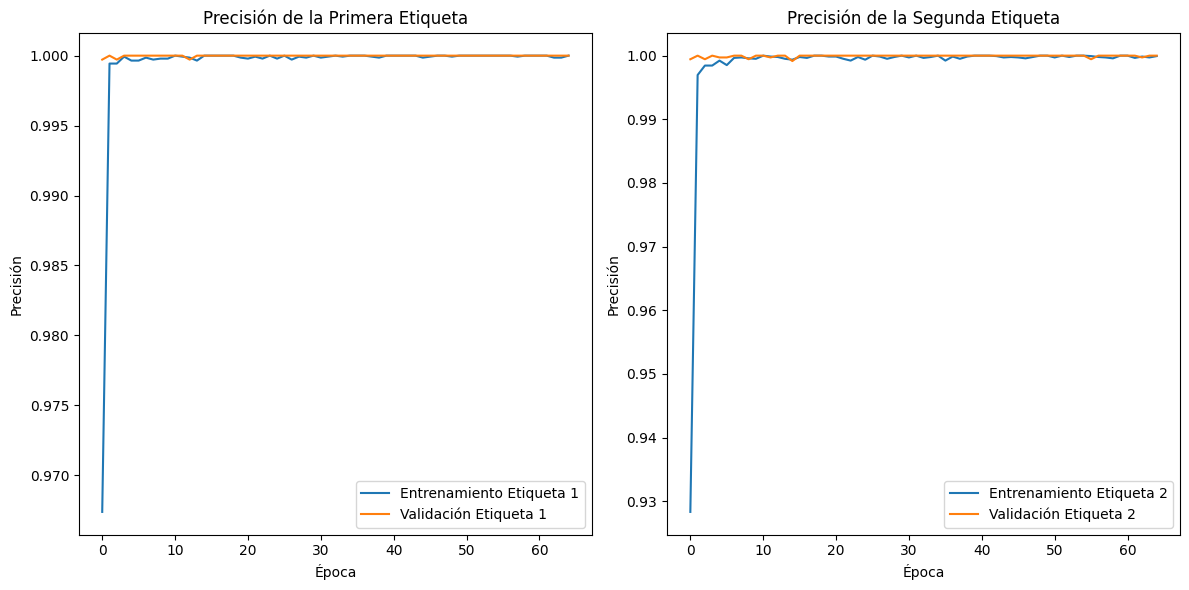

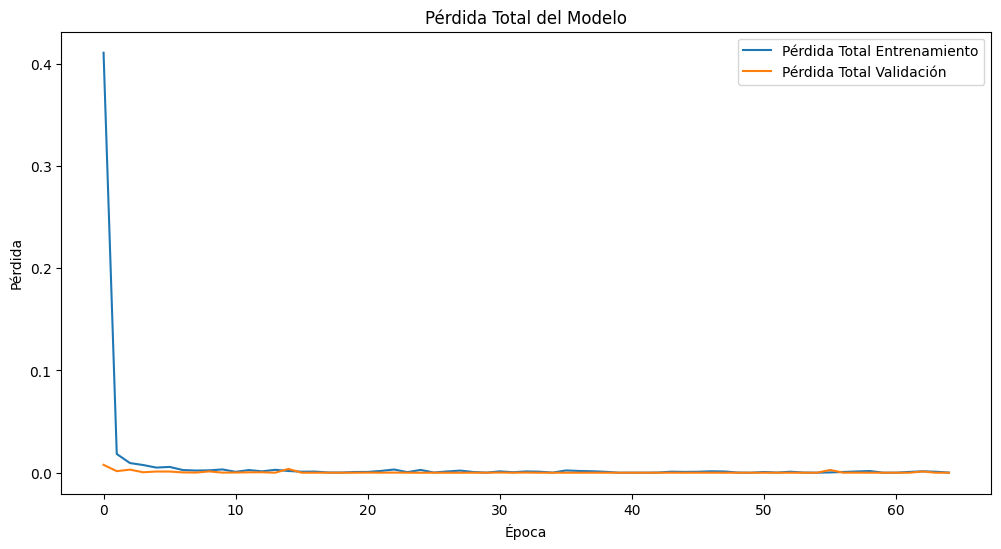

In [429]:
# Graficar la precisión del entrenamiento y validación para ambas etiquetas
def plot_accuracy(history):
    # Graficar la precisión de la primera etiqueta
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['output1_accuracy'], label='Entrenamiento Etiqueta 1')
    plt.plot(history.history['val_output1_accuracy'], label='Validación Etiqueta 1')
    plt.xlabel('Época')
    plt.ylabel('Precisión')
    plt.title('Precisión de la Primera Etiqueta')
    plt.legend()

    # Graficar la precisión de la segunda etiqueta
    plt.subplot(1, 2, 2)
    plt.plot(history.history['output2_accuracy'], label='Entrenamiento Etiqueta 2')
    plt.plot(history.history['val_output2_accuracy'], label='Validación Etiqueta 2')
    plt.xlabel('Época')
    plt.ylabel('Precisión')
    plt.title('Precisión de la Segunda Etiqueta')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Graficar la pérdida del entrenamiento y validación para ambas etiquetas
def plot_loss(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Pérdida Total Entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida Total Validación')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.title('Pérdida Total del Modelo')
    plt.legend()
    plt.show()

# Llamar a las funciones para graficar
plot_accuracy(history)
plot_loss(history)

In [432]:
# Guarda el modelo en el disco
model.save('Genomes And Genetics/HybridET_RF_NN_Model.keras')  

##### 7.3.2 Modelo FNN 2

In [433]:
# Crear y entrenar los modelos ET y RF
et_model = MultiOutputClassifier(ExtraTreesClassifier(n_estimators=300, max_depth=None, 
                                                      min_samples_split=5, min_samples_leaf=2, 
                                                      random_state=42))

rf_model = MultiOutputClassifier(RandomForestClassifier(n_estimators=200, max_depth=None, 
                                                        min_samples_split=2, min_samples_leaf=4, 
                                                        random_state=42))

et_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# Extraer las probabilidades de clase
def get_probabilities(model, X):
    probas = model.predict_proba(X)
    return np.hstack([proba for proba in probas])

et_train_probas = get_probabilities(et_model, X_train)
rf_train_probas = get_probabilities(rf_model, X_train)

et_test_probas = get_probabilities(et_model, X_test)
rf_test_probas = get_probabilities(rf_model, X_test)

# Combinar las características para formar el conjunto híbrido
hybrid_train_features = np.hstack([et_train_probas, rf_train_probas])
hybrid_test_features = np.hstack([et_test_probas, rf_test_probas])

# Preparar las etiquetas
le1 = LabelEncoder()
le2 = LabelEncoder()

y_train_1 = le1.fit_transform(y_train.iloc[:, 0])
y_train_2 = le2.fit_transform(y_train.iloc[:, 1])

y_test_1 = le1.transform(y_test.iloc[:, 0])
y_test_2 = le2.transform(y_test.iloc[:, 1])

# Convertir a one-hot encoding
y_train_1 = tf.keras.utils.to_categorical(y_train_1)
y_train_2 = tf.keras.utils.to_categorical(y_train_2)
y_test_1 = tf.keras.utils.to_categorical(y_test_1)
y_test_2 = tf.keras.utils.to_categorical(y_test_2)

# Definir la arquitectura de la red
input_layer = Input(shape=(hybrid_train_features.shape[1],))

# Capas compartidas
x = Dense(128, activation='relu')(input_layer)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)

# Rama para la primera etiqueta
output1 = Dense(y_train_1.shape[1], activation='softmax', name='output1')(x)

# Concatenar la salida de la primera etiqueta con las características
x_combined = concatenate([x, output1])

# Rama para la segunda etiqueta
x2 = Dense(32, activation='relu')(x_combined)
output2 = Dense(y_train_2.shape[1], activation='softmax', name='output2')(x2)

# Crear el modelo
model = Model(inputs=input_layer, outputs=[output1, output2])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001),
              loss={'output1': 'categorical_crossentropy', 'output2': 'categorical_crossentropy'},
              loss_weights={'output1': 1.0, 'output2': 1.0},
              metrics={'output1': 'accuracy', 'output2': 'accuracy'})

# Entrenar el modelo
history = model.fit(hybrid_train_features, 
                    {'output1': y_train_1, 'output2': y_train_2},
                    validation_split=0.2,
                    epochs=100,
                    batch_size=32,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

# Evaluar el modelo
test_loss, test_acc1, test_acc2 = model.evaluate(hybrid_test_features, [y_test_1, y_test_2])
print(f"Test accuracy - Etiqueta 1: {test_acc1:.4f}, Etiqueta 2: {test_acc2:.4f}")

# Hacer predicciones
predictions = model.predict(hybrid_test_features)
pred_1 = le1.inverse_transform(np.argmax(predictions[0], axis=1))
pred_2 = le2.inverse_transform(np.argmax(predictions[1], axis=1))

# Guardar las predicciones en un DataFrame
results_df = pd.DataFrame({
    'Tipo de Desorden Genético': pred_1,
    'Enfermedad': pred_2
})

print(results_df.head())

Epoch 1/100
442/442 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.0974 - output1_accuracy: 0.8999 - output2_accuracy: 0.7763 - val_loss: 0.0073 - val_output1_accuracy: 1.0000 - val_output2_accuracy: 1.0000
Epoch 2/100
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0216 - output1_accuracy: 0.9991 - output2_accuracy: 0.9979 - val_loss: 0.0021 - val_output1_accuracy: 1.0000 - val_output2_accuracy: 0.9997
Epoch 3/100
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0102 - output1_accuracy: 0.9991 - output2_accuracy: 0.9985 - val_loss: 5.9246e-04 - val_output1_accuracy: 1.0000 - val_output2_accuracy: 1.0000
Epoch 4/100
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0062 - output1_accuracy: 0.9998 - output2_accuracy: 0.9994 - val_loss: 3.4411e-04 - val_output1_accuracy: 1.0000 - val_output2_accuracy: 1.0000
Epoch 5/100
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0034 - output1_accuracy: 0.9999 - output2_accuracy: 0.9996 - val_loss: 8.0057e-04 - val_output1_accuracy: 1.0000 - va

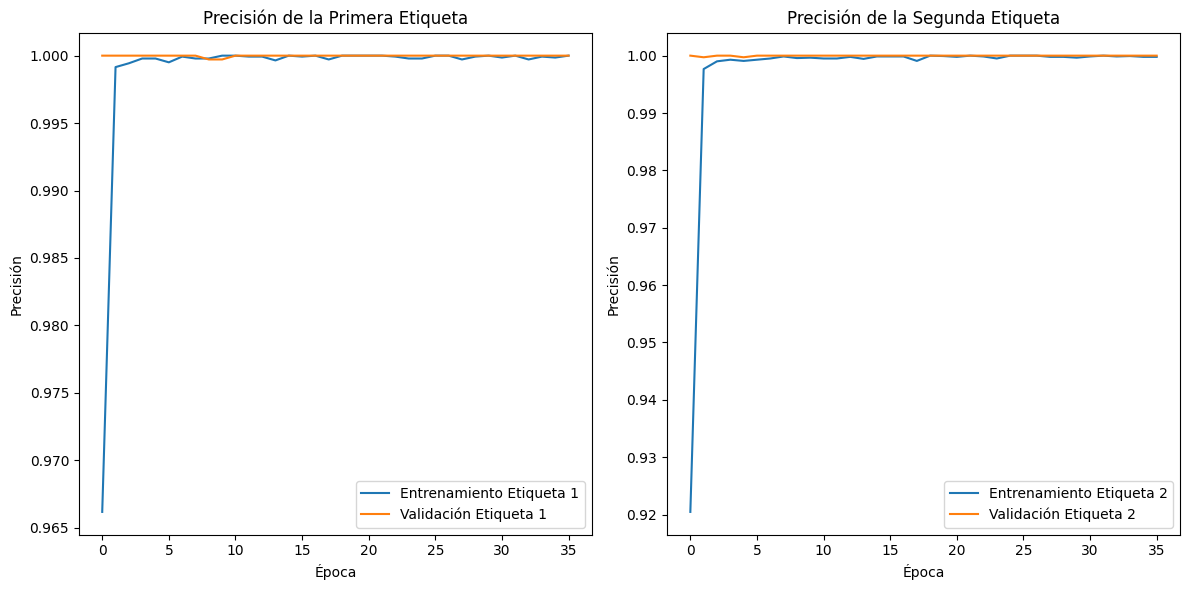

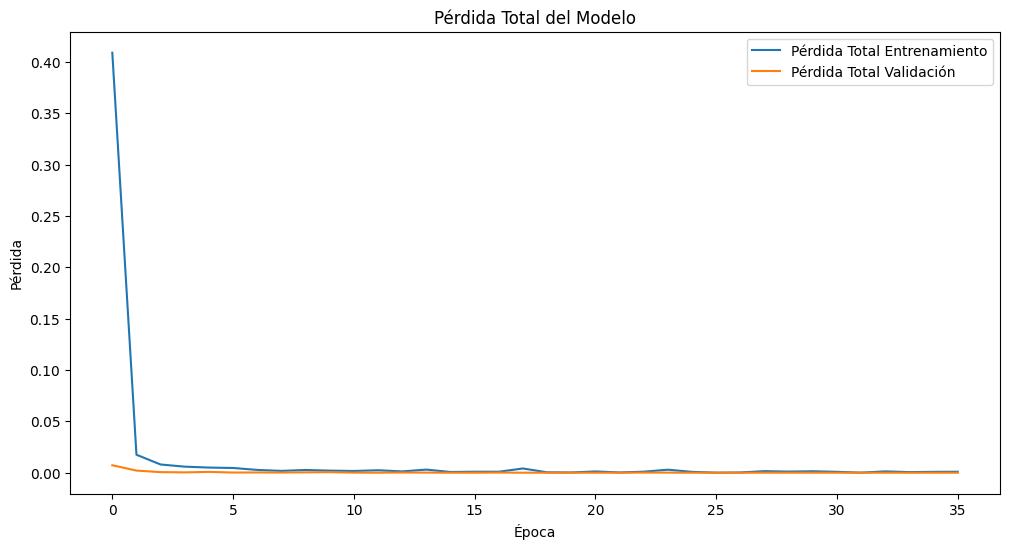

In [434]:
# Graficar la precisión del entrenamiento y validación para ambas etiquetas
def plot_accuracy(history):
    # Graficar la precisión de la primera etiqueta
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['output1_accuracy'], label='Entrenamiento Etiqueta 1')
    plt.plot(history.history['val_output1_accuracy'], label='Validación Etiqueta 1')
    plt.xlabel('Época')
    plt.ylabel('Precisión')
    plt.title('Precisión de la Primera Etiqueta')
    plt.legend()

    # Graficar la precisión de la segunda etiqueta
    plt.subplot(1, 2, 2)
    plt.plot(history.history['output2_accuracy'], label='Entrenamiento Etiqueta 2')
    plt.plot(history.history['val_output2_accuracy'], label='Validación Etiqueta 2')
    plt.xlabel('Época')
    plt.ylabel('Precisión')
    plt.title('Precisión de la Segunda Etiqueta')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Graficar la pérdida del entrenamiento y validación para ambas etiquetas
def plot_loss(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Pérdida Total Entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida Total Validación')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.title('Pérdida Total del Modelo')
    plt.legend()
    plt.show()

# Llamar a las funciones para graficar
plot_accuracy(history)
plot_loss(history)

In [436]:
# Guarda el modelo en el disco
model.save('Genomes And Genetics/HybridET_RF_FNN_Model_2.keras')  

##### 7.3.3 Modelo FNN 3

In [37]:
# Crear y entrenar los modelos ET y RF
et_model = MultiOutputClassifier(ExtraTreesClassifier(n_estimators=300, max_depth=None, 
                                                      min_samples_split=5, min_samples_leaf=2, 
                                                      random_state=42))

rf_model = MultiOutputClassifier(RandomForestClassifier(n_estimators=200, max_depth=None, 
                                                        min_samples_split=2, min_samples_leaf=4, 
                                                        random_state=42))

et_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# Extraer las probabilidades de clase
def get_probabilities(model, X):
    probas = model.predict_proba(X)
    return np.hstack([proba for proba in probas])

et_train_probas = get_probabilities(et_model, X_train)
rf_train_probas = get_probabilities(rf_model, X_train)

et_test_probas = get_probabilities(et_model, X_test)
rf_test_probas = get_probabilities(rf_model, X_test)

# Combinar las características para formar el conjunto híbrido
hybrid_train_features = np.hstack([et_train_probas, rf_train_probas])
hybrid_test_features = np.hstack([et_test_probas, rf_test_probas])

# Preparar las etiquetas
le1 = LabelEncoder()
le2 = LabelEncoder()

y_train_1 = le1.fit_transform(y_train.iloc[:, 0])
y_train_2 = le2.fit_transform(y_train.iloc[:, 1])

y_test_1 = le1.transform(y_test.iloc[:, 0])
y_test_2 = le2.transform(y_test.iloc[:, 1])

# Convertir a one-hot encoding
y_train_1 = tf.keras.utils.to_categorical(y_train_1)
y_train_2 = tf.keras.utils.to_categorical(y_train_2)
y_test_1 = tf.keras.utils.to_categorical(y_test_1)
y_test_2 = tf.keras.utils.to_categorical(y_test_2)

# Definir la arquitectura de la red con regularización aumentada y complejidad reducida
input_layer = Input(shape=(hybrid_train_features.shape[1],))

# Capas compartidas con regularización L2 y dropout aumentado
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(input_layer)
x = Dropout(0.4)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.4)(x)

# Rama para la primera etiqueta
output1 = Dense(y_train_1.shape[1], activation='softmax', name='output1', kernel_regularizer=l2(0.01))(x)

# Concatenar la salida de la primera etiqueta con las características
x_combined = concatenate([x, output1])

# Rama para la segunda etiqueta
x2 = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x_combined)
x2 = Dropout(0.4)(x2)
output2 = Dense(y_train_2.shape[1], activation='softmax', name='output2', kernel_regularizer=l2(0.01))(x2)

# Crear el modelo
model = Model(inputs=input_layer, outputs=[output1, output2])

# Compilar el modelo con una tasa de aprendizaje reducida
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss={'output1': 'categorical_crossentropy', 'output2': 'categorical_crossentropy'},
              loss_weights={'output1': 1.0, 'output2': 1.0},
              metrics={'output1': 'accuracy', 'output2': 'accuracy'})

# Entrenar el modelo con un callback de reducción de tasa de aprendizaje
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

history = model.fit(hybrid_train_features, 
                    {'output1': y_train_1, 'output2': y_train_2},
                    validation_split=0.2,
                    epochs=100,
                    batch_size=32,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True),
                               reduce_lr])

# Evaluar el modelo
test_loss, test_acc1, test_acc2 = model.evaluate(hybrid_test_features, [y_test_1, y_test_2])
print(f"Test accuracy - Etiqueta 1: {test_acc1:.4f}, Etiqueta 2: {test_acc2:.4f}")

Epoch 1/100
442/442 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 4.0895 - output1_accuracy: 0.7101 - output2_accuracy: 0.3571 - val_loss: 1.7457 - val_output1_accuracy: 0.9443 - val_output2_accuracy: 0.8115 - learning_rate: 5.0000e-04
Epoch 2/100
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.9469 - output1_accuracy: 0.9430 - output2_accuracy: 0.7555 - val_loss: 1.4039 - val_output1_accuracy: 0.9825 - val_output2_accuracy: 0.8246 - learning_rate: 5.0000e-04
Epoch 3/100
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6290 - output1_accuracy: 0.9709 - output2_accuracy: 0.7994 - val_loss: 1.2768 - val_output1_accuracy: 0.9909 - val_output2_accuracy: 0.8885 - learning_rate: 5.0000e-04
Epoch 4/100
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.5254 - output1_accuracy: 0.9761 - output2_accuracy: 0.8312 - val_loss: 1.1972 - val_output1_accuracy: 0.9941 - val_output2_accuracy: 0.9417 - learning_rate: 5.0000e-04
Epoch 5/100
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.4540 - output

In [38]:
# Hacer predicciones
predictions = model.predict(hybrid_test_features)
pred_1 = le1.inverse_transform(np.argmax(predictions[0], axis=1))
pred_2 = le2.inverse_transform(np.argmax(predictions[1], axis=1))

# Guardar las predicciones en un DataFrame
results_df = pd.DataFrame({
    'Tipo de Desorden Genético': pred_1,
    'Enfermedad': pred_2
})

print(results_df.head())

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
                     Tipo de Desorden Genético              Enfermedad
0  Mitochondrial genetic inheritance disorders  Mitochondrial myopathy
1  Mitochondrial genetic inheritance disorders          Leigh syndrome
2             Single-gene inheritance diseases                Diabetes
3             Single-gene inheritance diseases               Tay-Sachs
4             Single-gene inheritance diseases               Tay-Sachs


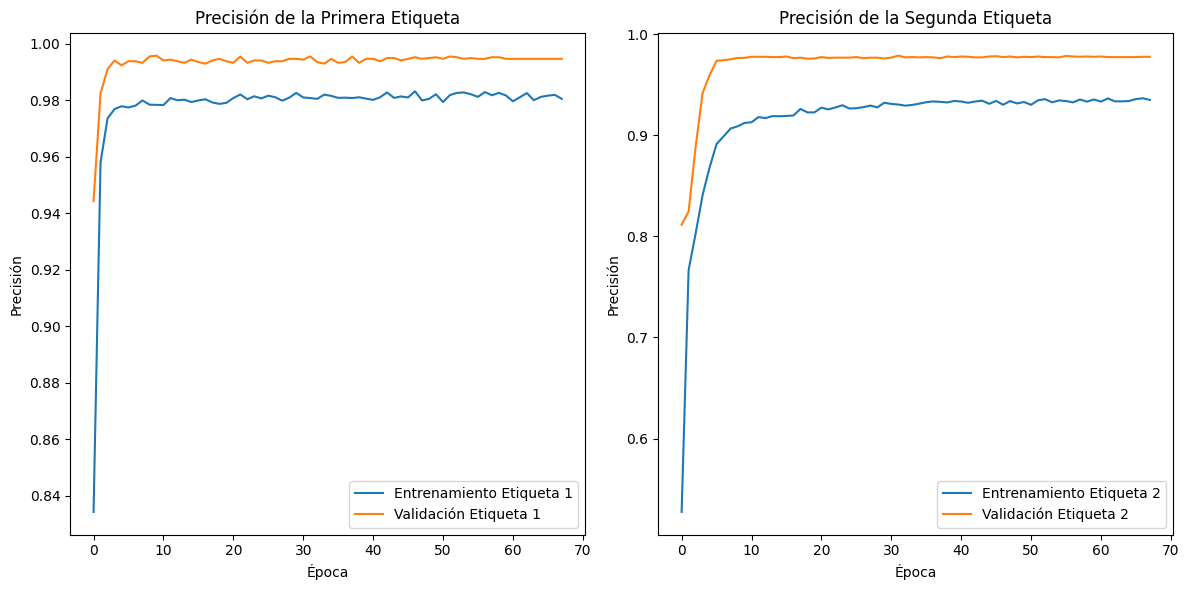

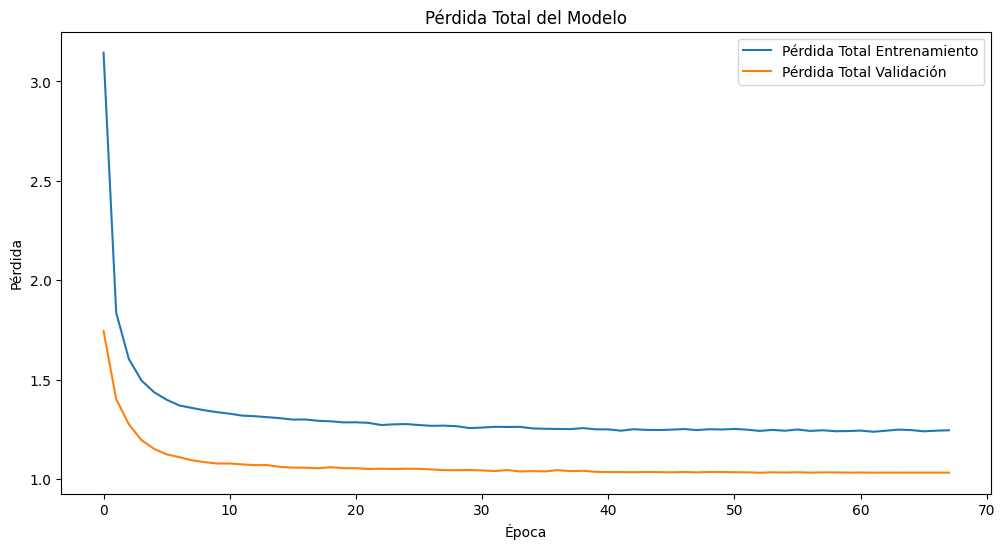

In [39]:
# Graficar la precisión del entrenamiento y validación para ambas etiquetas
def plot_accuracy(history):
    # Graficar la precisión de la primera etiqueta
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['output1_accuracy'], label='Entrenamiento Etiqueta 1')
    plt.plot(history.history['val_output1_accuracy'], label='Validación Etiqueta 1')
    plt.xlabel('Época')
    plt.ylabel('Precisión')
    plt.title('Precisión de la Primera Etiqueta')
    plt.legend()

    # Graficar la precisión de la segunda etiqueta
    plt.subplot(1, 2, 2)
    plt.plot(history.history['output2_accuracy'], label='Entrenamiento Etiqueta 2')
    plt.plot(history.history['val_output2_accuracy'], label='Validación Etiqueta 2')
    plt.xlabel('Época')
    plt.ylabel('Precisión')
    plt.title('Precisión de la Segunda Etiqueta')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Graficar la pérdida del entrenamiento y validación para ambas etiquetas
def plot_loss(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Pérdida Total Entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida Total Validación')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.title('Pérdida Total del Modelo')
    plt.legend()
    plt.show()

# Llamar a las funciones para graficar
plot_accuracy(history)
plot_loss(history)

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


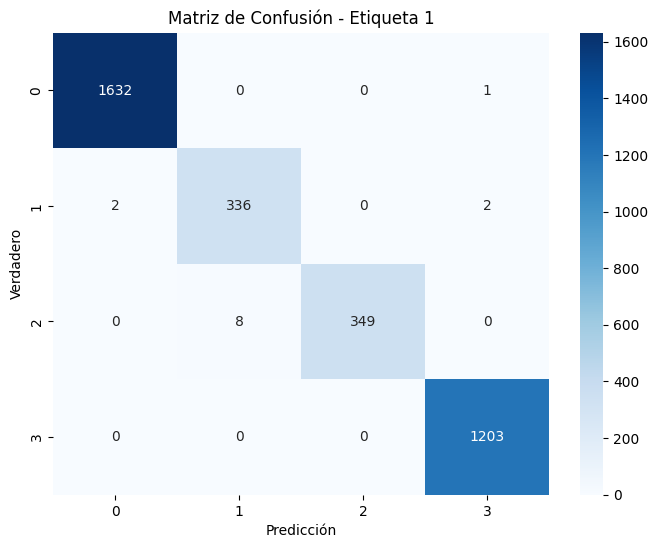

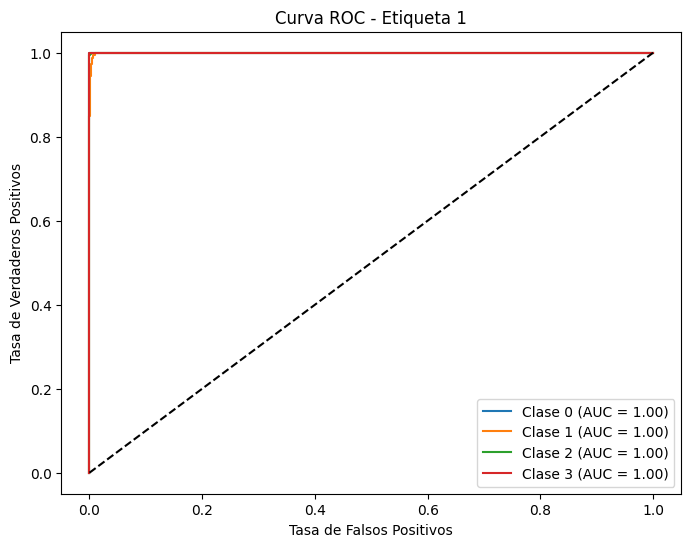

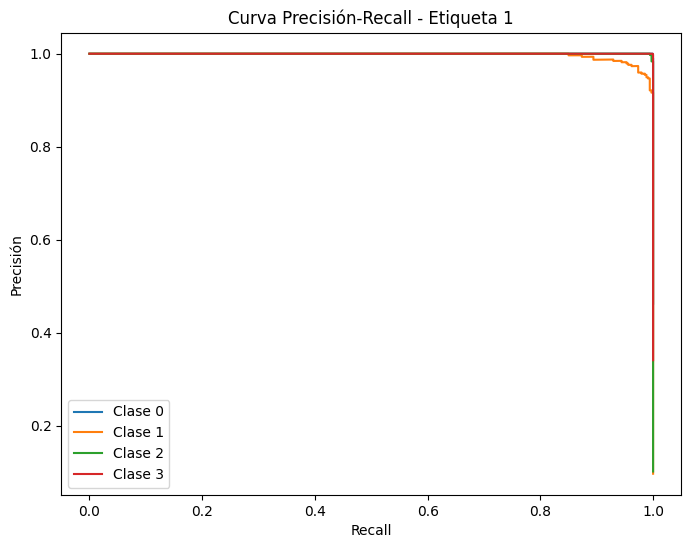

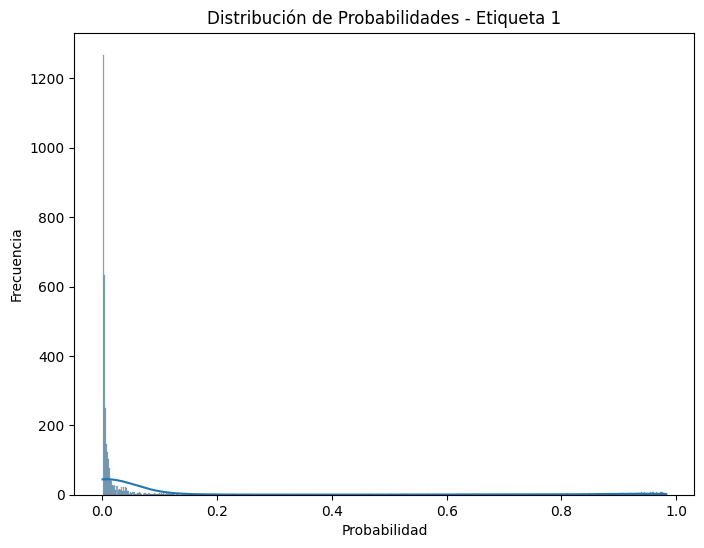

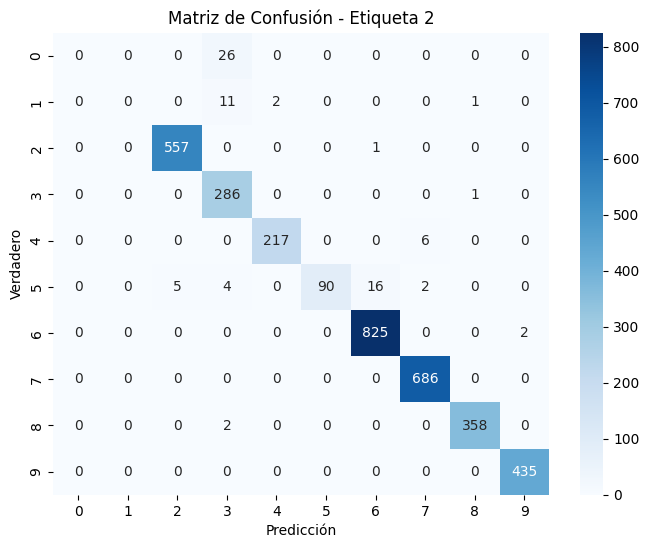

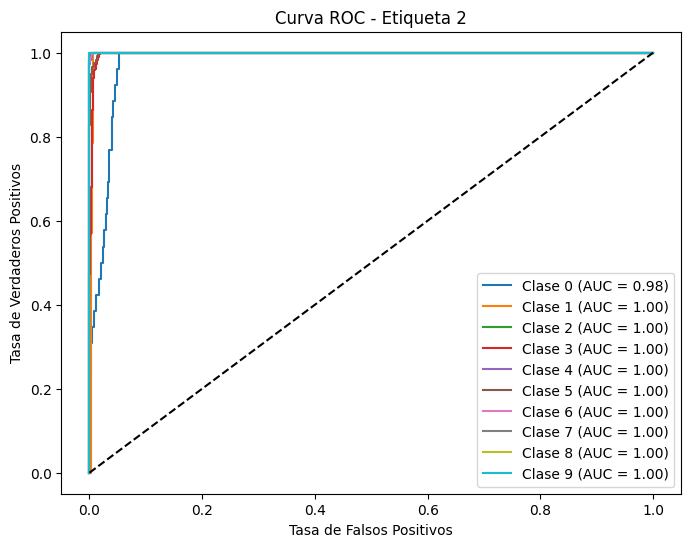

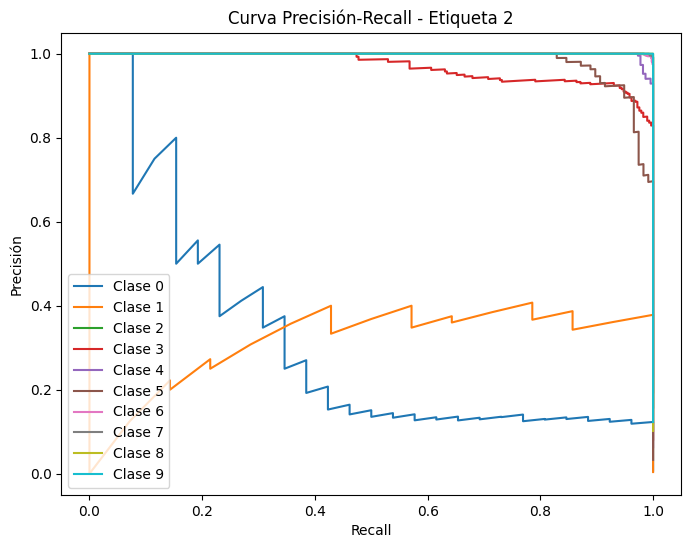

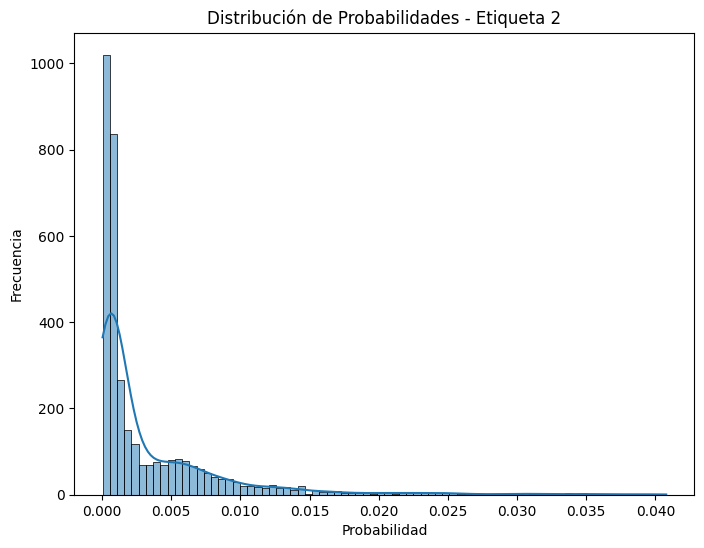

In [40]:
# Generar predicciones
val_data = (hybrid_train_features[:int(0.2*len(hybrid_train_features))], 
            {'output1': y_train_1[:int(0.2*len(y_train_1))], 'output2': y_train_2[:int(0.2*len(y_train_2))]})

val_predictions = model.predict(val_data[0])
val_pred_1 = np.argmax(val_predictions[0], axis=1)
val_pred_2 = np.argmax(val_predictions[1], axis=1)
y_val_1 = np.argmax(val_data[1]['output1'], axis=1)
y_val_2 = np.argmax(val_data[1]['output2'], axis=1)

# Funciones para generar los gráficos
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicción')
    plt.ylabel('Verdadero')
    plt.show()

def plot_roc_curve(y_true, y_pred, title):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(title)
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.legend()
    plt.show()

def plot_precision_recall_curve(y_true, y_pred, title):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision)
    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precisión')
    plt.show()

def plot_probability_distribution(y_pred, title):
    plt.figure(figsize=(8, 6))
    sns.histplot(y_pred, kde=True)
    plt.title(title)
    plt.xlabel('Probabilidad')
    plt.ylabel('Frecuencia')
    plt.show()

def plot_multiclass_roc(y_true, y_pred, n_classes, title):
    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Clase {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(title)
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.legend(loc="lower right")
    plt.show()

def plot_multiclass_precision_recall(y_true, y_pred, n_classes, title):
    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))
    precision = dict()
    recall = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_pred[:, i])

    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(recall[i], precision[i], label=f'Clase {i}')
    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precisión')
    plt.legend(loc="lower left")
    plt.show()

# Generar los gráficos para Etiqueta 1
plot_confusion_matrix(y_val_1, val_pred_1, 'Matriz de Confusión - Etiqueta 1')
plot_multiclass_roc(y_val_1, val_predictions[0], y_train_1.shape[1], 'Curva ROC - Etiqueta 1')
plot_multiclass_precision_recall(y_val_1, val_predictions[0], y_train_1.shape[1], 'Curva Precisión-Recall - Etiqueta 1')
plot_probability_distribution(val_predictions[0][:, 1], 'Distribución de Probabilidades - Etiqueta 1')

# Generar los gráficos para Etiqueta 2
plot_confusion_matrix(y_val_2, val_pred_2, 'Matriz de Confusión - Etiqueta 2')
plot_multiclass_roc(y_val_2, val_predictions[1], y_train_2.shape[1], 'Curva ROC - Etiqueta 2')
plot_multiclass_precision_recall(y_val_2, val_predictions[1], y_train_2.shape[1], 'Curva Precisión-Recall - Etiqueta 2')
plot_probability_distribution(val_predictions[1][:, 1], 'Distribución de Probabilidades - Etiqueta 2')

In [462]:
# Guarda el modelo en el disco
model.save('Genomes And Genetics/HybridET_RF_FNN_Model_3.keras')  

##### 7.3.4 Modelo FNN4

In [18]:
# Crear y entrenar los modelos ET y RF
et_model = MultiOutputClassifier(ExtraTreesClassifier(n_estimators=300, max_depth=None, 
                                                      min_samples_split=5, min_samples_leaf=2, 
                                                      random_state=42))

rf_model = MultiOutputClassifier(RandomForestClassifier(n_estimators=200, max_depth=None, 
                                                        min_samples_split=2, min_samples_leaf=4, 
                                                        random_state=42))

et_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# Extraer las probabilidades de clase
def get_probabilities(model, X):
    probas = model.predict_proba(X)
    return np.hstack([proba for proba in probas])

et_train_probas = get_probabilities(et_model, X_train)
rf_train_probas = get_probabilities(rf_model, X_train)

et_test_probas = get_probabilities(et_model, X_test)
rf_test_probas = get_probabilities(rf_model, X_test)

# Combinar las características para formar el conjunto híbrido
hybrid_train_features = np.hstack([et_train_probas, rf_train_probas])
hybrid_test_features = np.hstack([et_test_probas, rf_test_probas])

# Preparar las etiquetas
le1 = LabelEncoder()
le2 = LabelEncoder()

y_train_1 = le1.fit_transform(y_train.iloc[:, 0])
y_train_2 = le2.fit_transform(y_train.iloc[:, 1])

y_test_1 = le1.transform(y_test.iloc[:, 0])
y_test_2 = le2.transform(y_test.iloc[:, 1])

# Convertir a one-hot encoding
y_train_1 = tf.keras.utils.to_categorical(y_train_1)
y_train_2 = tf.keras.utils.to_categorical(y_train_2)
y_test_1 = tf.keras.utils.to_categorical(y_test_1)
y_test_2 = tf.keras.utils.to_categorical(y_test_2)

# Definir la arquitectura de la red con regularización aumentada y complejidad reducida
input_layer = Input(shape=(hybrid_train_features.shape[1],))

# Capas compartidas con regularización L2 y dropout aumentado
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(input_layer)
x = Dropout(0.4)(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.4)(x)

# Rama para la primera etiqueta
output1 = Dense(y_train_1.shape[1], activation='softmax', name='output1', kernel_regularizer=l2(0.01))(x)

# Concatenar la salida de la primera etiqueta con las características
x_combined = concatenate([x, output1])

# Rama para la segunda etiqueta
x2 = Dense(16, activation='relu', kernel_regularizer=l2(0.01))(x_combined)
x2 = Dropout(0.4)(x2)
output2 = Dense(y_train_2.shape[1], activation='softmax', name='output2', kernel_regularizer=l2(0.01))(x2)

# Crear el modelo
model = Model(inputs=input_layer, outputs=[output1, output2])

# Compilar el modelo con una tasa de aprendizaje reducida
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss={'output1': 'categorical_crossentropy', 'output2': 'categorical_crossentropy'},
              loss_weights={'output1': 1.0, 'output2': 1.0},
              metrics={'output1': 'accuracy', 'output2': 'accuracy'})

# Entrenar el modelo con un callback de reducción de tasa de aprendizaje
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

history = model.fit(hybrid_train_features, 
                    {'output1': y_train_1, 'output2': y_train_2},
                    validation_split=0.2,
                    epochs=100,
                    batch_size=32,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True),
                               reduce_lr])

# Evaluar el modelo
test_loss, test_acc1, test_acc2 = model.evaluate(hybrid_test_features, [y_test_1, y_test_2])
print(f"Test accuracy - Etiqueta 1: {test_acc1:.4f}, Etiqueta 2: {test_acc2:.4f}")

Epoch 1/100
442/442 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 4.0675 - output1_accuracy: 0.5683 - output2_accuracy: 0.2289 - val_loss: 2.1380 - val_output1_accuracy: 0.9162 - val_output2_accuracy: 0.6672 - learning_rate: 5.0000e-04
Epoch 2/100
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.2861 - output1_accuracy: 0.9102 - output2_accuracy: 0.4931 - val_loss: 1.6833 - val_output1_accuracy: 0.9610 - val_output2_accuracy: 0.6851 - learning_rate: 5.0000e-04
Epoch 3/100
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.9440 - output1_accuracy: 0.9429 - output2_accuracy: 0.6053 - val_loss: 1.5309 - val_output1_accuracy: 0.9856 - val_output2_accuracy: 0.7847 - learning_rate: 5.0000e-04
Epoch 4/100
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.8301 - output1_accuracy: 0.9583 - output2_accuracy: 0.6414 - val_loss: 1.4459 - val_output1_accuracy: 0.9881 - val_output2_accuracy: 0.8028 - learning_rate: 5.0000e-04
Epoch 5/100
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.7385 - output

In [19]:
# Hacer predicciones
predictions = model.predict(hybrid_test_features)
pred_1 = le1.inverse_transform(np.argmax(predictions[0], axis=1))
pred_2 = le2.inverse_transform(np.argmax(predictions[1], axis=1))

# Guardar las predicciones en un DataFrame
results_df = pd.DataFrame({
    'Tipo de Desorden Genético': pred_1,
    'Enfermedad': pred_2
})

print(results_df.head())

139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
                     Tipo de Desorden Genético       Enfermedad
0  Mitochondrial genetic inheritance disorders   Leigh syndrome
1  Mitochondrial genetic inheritance disorders   Leigh syndrome
2             Single-gene inheritance diseases  Cystic fibrosis
3             Single-gene inheritance diseases  Hemochromatosis
4             Single-gene inheritance diseases  Hemochromatosis


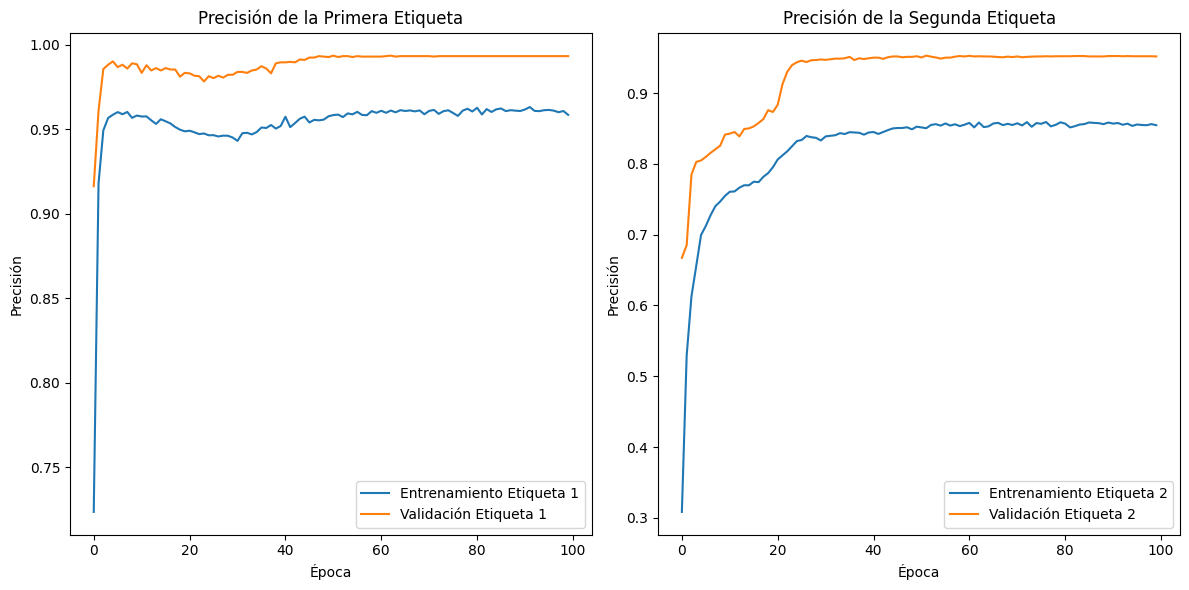

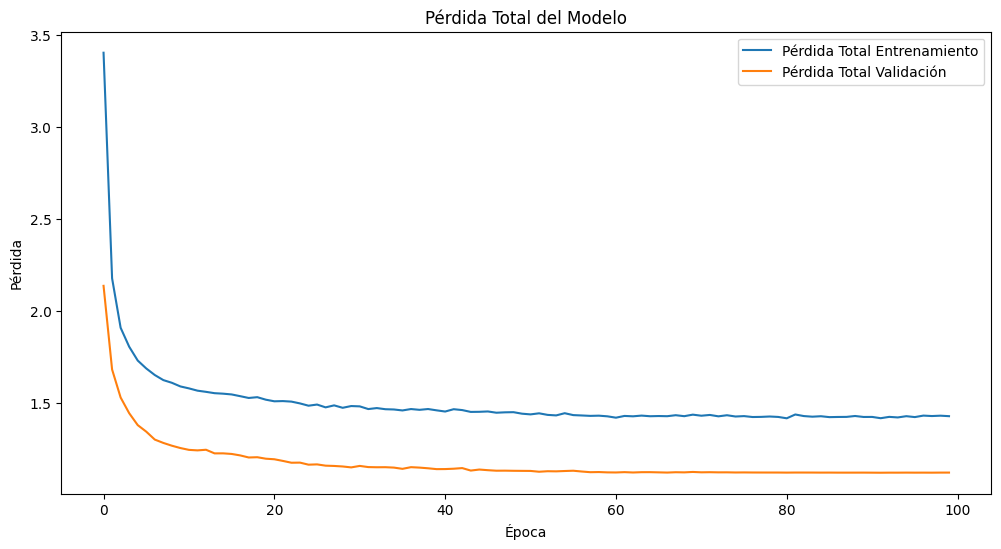

In [22]:
# Graficar la precisión del entrenamiento y validación para ambas etiquetas
def plot_accuracy(history):
    # Graficar la precisión de la primera etiqueta
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['output1_accuracy'], label='Entrenamiento Etiqueta 1')
    plt.plot(history.history['val_output1_accuracy'], label='Validación Etiqueta 1')
    plt.xlabel('Época')
    plt.ylabel('Precisión')
    plt.title('Precisión de la Primera Etiqueta')
    plt.legend()

    # Graficar la precisión de la segunda etiqueta
    plt.subplot(1, 2, 2)
    plt.plot(history.history['output2_accuracy'], label='Entrenamiento Etiqueta 2')
    plt.plot(history.history['val_output2_accuracy'], label='Validación Etiqueta 2')
    plt.xlabel('Época')
    plt.ylabel('Precisión')
    plt.title('Precisión de la Segunda Etiqueta')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Graficar la pérdida del entrenamiento y validación para ambas etiquetas
def plot_loss(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Pérdida Total Entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida Total Validación')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.title('Pérdida Total del Modelo')
    plt.legend()
    plt.show()

# Llamar a las funciones para graficar
plot_accuracy(history)
plot_loss(history)

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


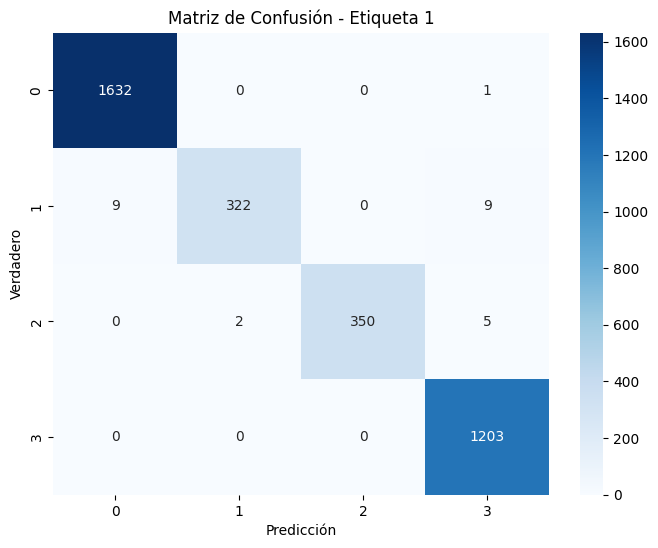

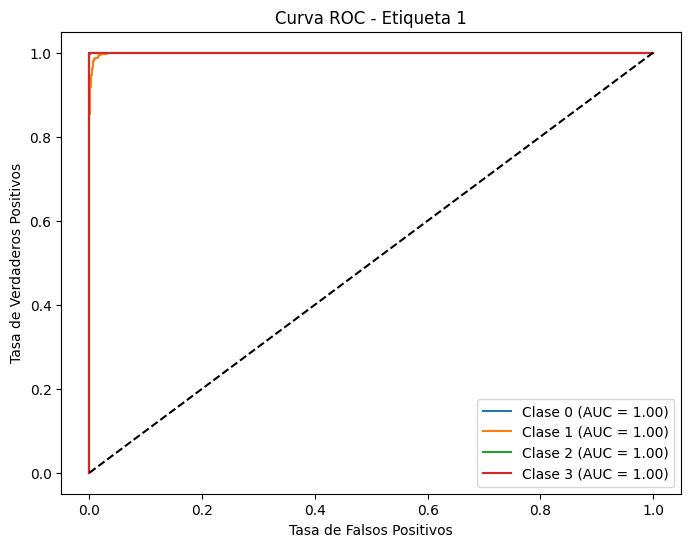

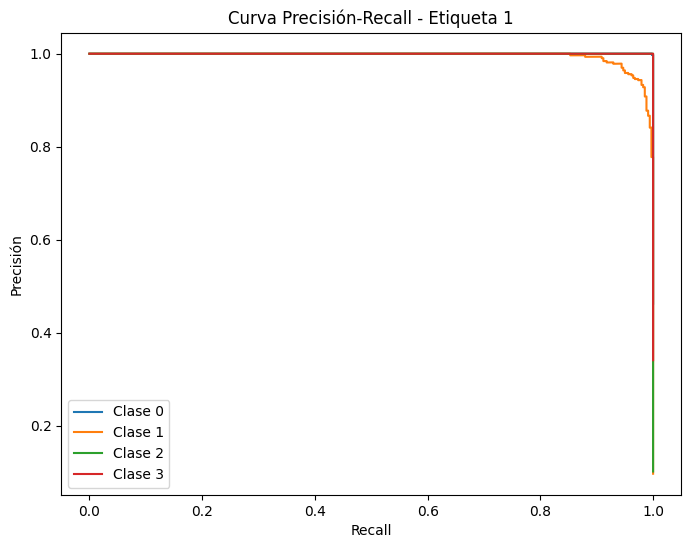

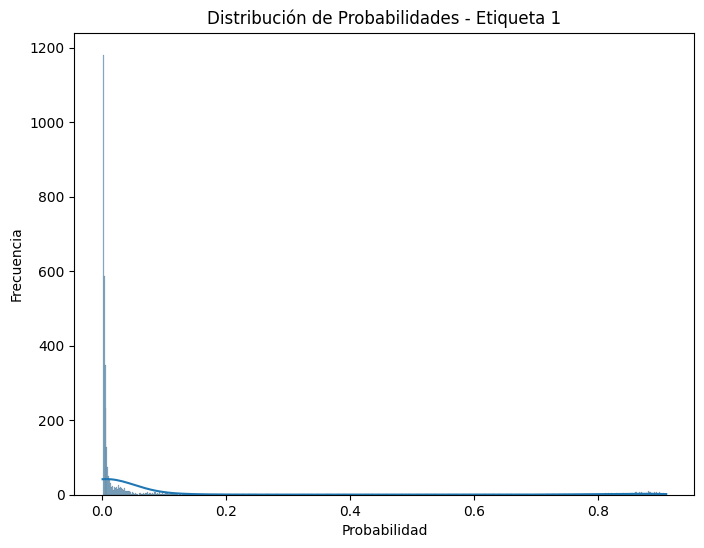

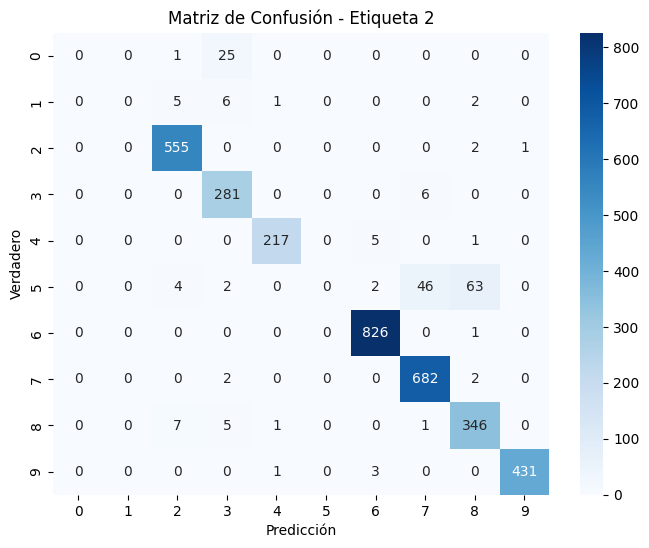

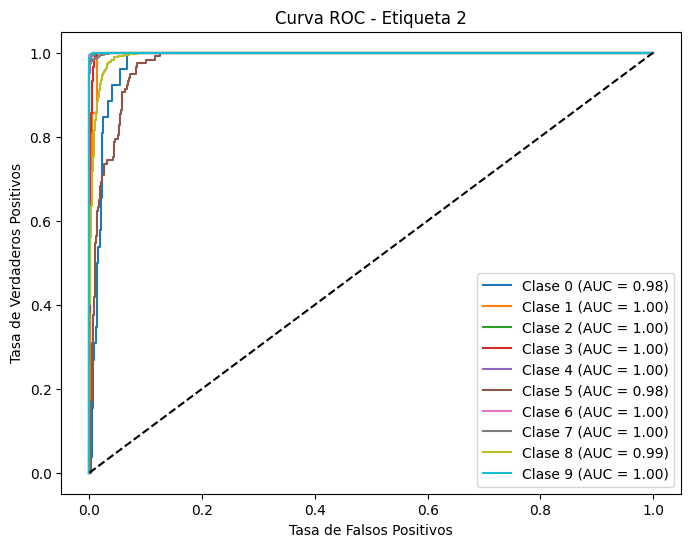

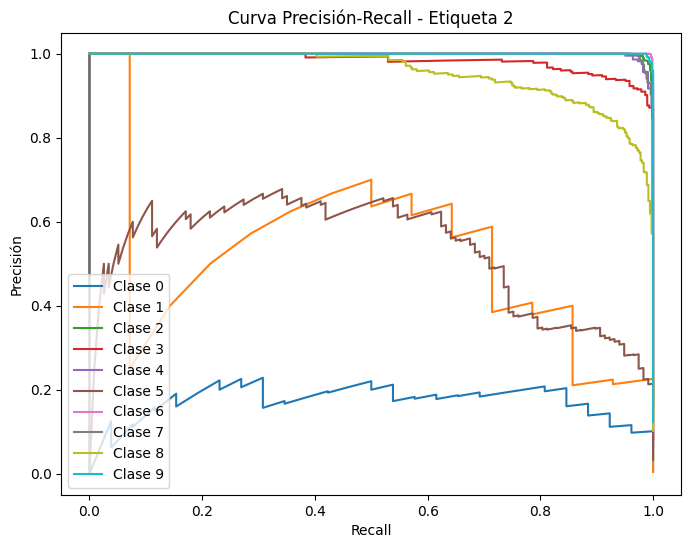

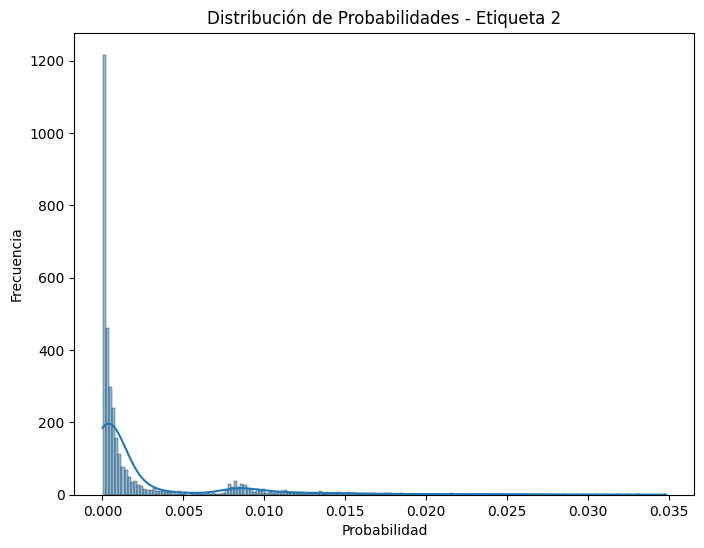

In [35]:
# Generar predicciones
val_data = (hybrid_train_features[:int(0.2*len(hybrid_train_features))], 
            {'output1': y_train_1[:int(0.2*len(y_train_1))], 'output2': y_train_2[:int(0.2*len(y_train_2))]})

val_predictions = model.predict(val_data[0])
val_pred_1 = np.argmax(val_predictions[0], axis=1)
val_pred_2 = np.argmax(val_predictions[1], axis=1)
y_val_1 = np.argmax(val_data[1]['output1'], axis=1)
y_val_2 = np.argmax(val_data[1]['output2'], axis=1)

# Funciones para generar los gráficos
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicción')
    plt.ylabel('Verdadero')
    plt.show()

def plot_roc_curve(y_true, y_pred, title):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(title)
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.legend()
    plt.show()

def plot_precision_recall_curve(y_true, y_pred, title):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision)
    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precisión')
    plt.show()

def plot_probability_distribution(y_pred, title):
    plt.figure(figsize=(8, 6))
    sns.histplot(y_pred, kde=True)
    plt.title(title)
    plt.xlabel('Probabilidad')
    plt.ylabel('Frecuencia')
    plt.show()

def plot_multiclass_roc(y_true, y_pred, n_classes, title):
    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Clase {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(title)
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.legend(loc="lower right")
    plt.show()

def plot_multiclass_precision_recall(y_true, y_pred, n_classes, title):
    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))
    precision = dict()
    recall = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_pred[:, i])

    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(recall[i], precision[i], label=f'Clase {i}')
    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precisión')
    plt.legend(loc="lower left")
    plt.show()

# Generar los gráficos para Etiqueta 1
plot_confusion_matrix(y_val_1, val_pred_1, 'Matriz de Confusión - Etiqueta 1')
plot_multiclass_roc(y_val_1, val_predictions[0], y_train_1.shape[1], 'Curva ROC - Etiqueta 1')
plot_multiclass_precision_recall(y_val_1, val_predictions[0], y_train_1.shape[1], 'Curva Precisión-Recall - Etiqueta 1')
plot_probability_distribution(val_predictions[0][:, 1], 'Distribución de Probabilidades - Etiqueta 1')

# Generar los gráficos para Etiqueta 2
plot_confusion_matrix(y_val_2, val_pred_2, 'Matriz de Confusión - Etiqueta 2')
plot_multiclass_roc(y_val_2, val_predictions[1], y_train_2.shape[1], 'Curva ROC - Etiqueta 2')
plot_multiclass_precision_recall(y_val_2, val_predictions[1], y_train_2.shape[1], 'Curva Precisión-Recall - Etiqueta 2')
plot_probability_distribution(val_predictions[1][:, 1], 'Distribución de Probabilidades - Etiqueta 2')

In [ ]:
# Guarda el modelo en el disco
model.save('Genomes And Genetics/HybridET_RF_FNN_Model_4.keras')  